# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [3]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

## Load files

### DE results

## Load normalized pseudobulks

In [4]:
pb_dir_path = '../data/pseudobulks/'

In [5]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [6]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

## Specie-specific genes

In [7]:
from statsmodels.stats.multitest import multipletests
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('results/edgeR_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('results/edgeR_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('results/edgeR_chimp_macaque.csv', index_col=0)

for key, df in res_dict.items():
    mult_test = multipletests(df['PValue'], method='fdr_bh')
    df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

logFC.spline_1.human  logFC.spline_2.human  logFC.spline_3.human  \
A1BG               0.244038              0.286535              0.252427   
AACS              -0.388070             -0.241365             -0.039750   
AADAT             -0.399771             -0.369816             -0.361727   
AAGAB              0.086928              0.361438              0.044400   
AAK1               0.231119              0.421302              0.032839   

         logCPM         F    PValue  p_val_adj  
A1BG   8.937955  1.353039  0.266747   0.847434  
AACS   8.898749  1.925657  0.131096   0.624955  
AADAT  8.822620  0.269978  0.846744   1.000000  
AAGAB  8.837510  0.579746  0.630315   1.000000  
AAK1   8.977608  0.409947  0.746269   1.000000

In [8]:
sign_genes = lambda df: df[df.p_val_adj < 0.05].index
sign_genes_dict = {key:sign_genes(df) for key, df in res_dict.items()}
sign_genes_dict

{'human-chimp': Index(['ACTN2', 'ADGRB2', 'ADGRG1', 'ADGRL1', 'ALCAM', 'AMZ2', 'ANK3', 'AP2S1',
        'APBA1', 'APBA2',
        ...
        'UQCRB', 'UQCRH', 'VAT1L', 'WDR37', 'WLS', 'ZBTB18', 'ZBTB46',
        'ZCCHC17', 'ZMYND8', 'ZNF706'],
       dtype='object', length=224),
 'human-macaque': Index(['AACS', 'AARS1', 'AATK', 'ABAT', 'ABCA2', 'ABCC10', 'ABCC5', 'ABCD3',
        'ABCD4', 'ABHD10',
        ...
        'ZNF483', 'ZNF536', 'ZNF579', 'ZNF706', 'ZNF770', 'ZNF791', 'ZNHIT3',
        'ZRANB2', 'ZYG11B', 'ZYX'],
       dtype='object', length=2141),
 'chimp-macaque': Index(['AARS1', 'AATK', 'ABAT', 'ABCD3', 'ABCD4', 'ABLIM3', 'ABTB1', 'ACAD9',
        'ACHE', 'ACOT7',
        ...
        'YPEL5', 'YWHAB', 'YWHAG', 'ZDHHC22', 'ZDHHC8', 'ZDHHC9', 'ZFAND5',
        'ZMPSTE24', 'ZNF536', 'ZNF655'],
       dtype='object', length=1057)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [9]:
hs_genes = sign_genes_dict['human-chimp'].intersection(sign_genes_dict['human-macaque']).difference(sign_genes_dict['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
        'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
        'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
        'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
        'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
        'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
        'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RBIS', 'RGS2', 'SCN3B', 'SEPTIN6',
        'ST3GAL5', 'SULF2', 'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1',
        'VAT1L', 'ZBTB18', 'ZBTB46', 'ZNF706'],
       dtype='object'),
 65)

In [10]:
background_genes = res_dict['human-chimp'].index.tolist()
len(background_genes)

7790

## Helpful functions

In [11]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [12]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [13]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        else:
            raise Exception('Error analyzing gene list')
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        else:
            raise Exception('Error analyzing gene list')
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        else:
            raise Exception('Error analyzing gene list')
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [14]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [15]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes].copy()

## Hierarchial

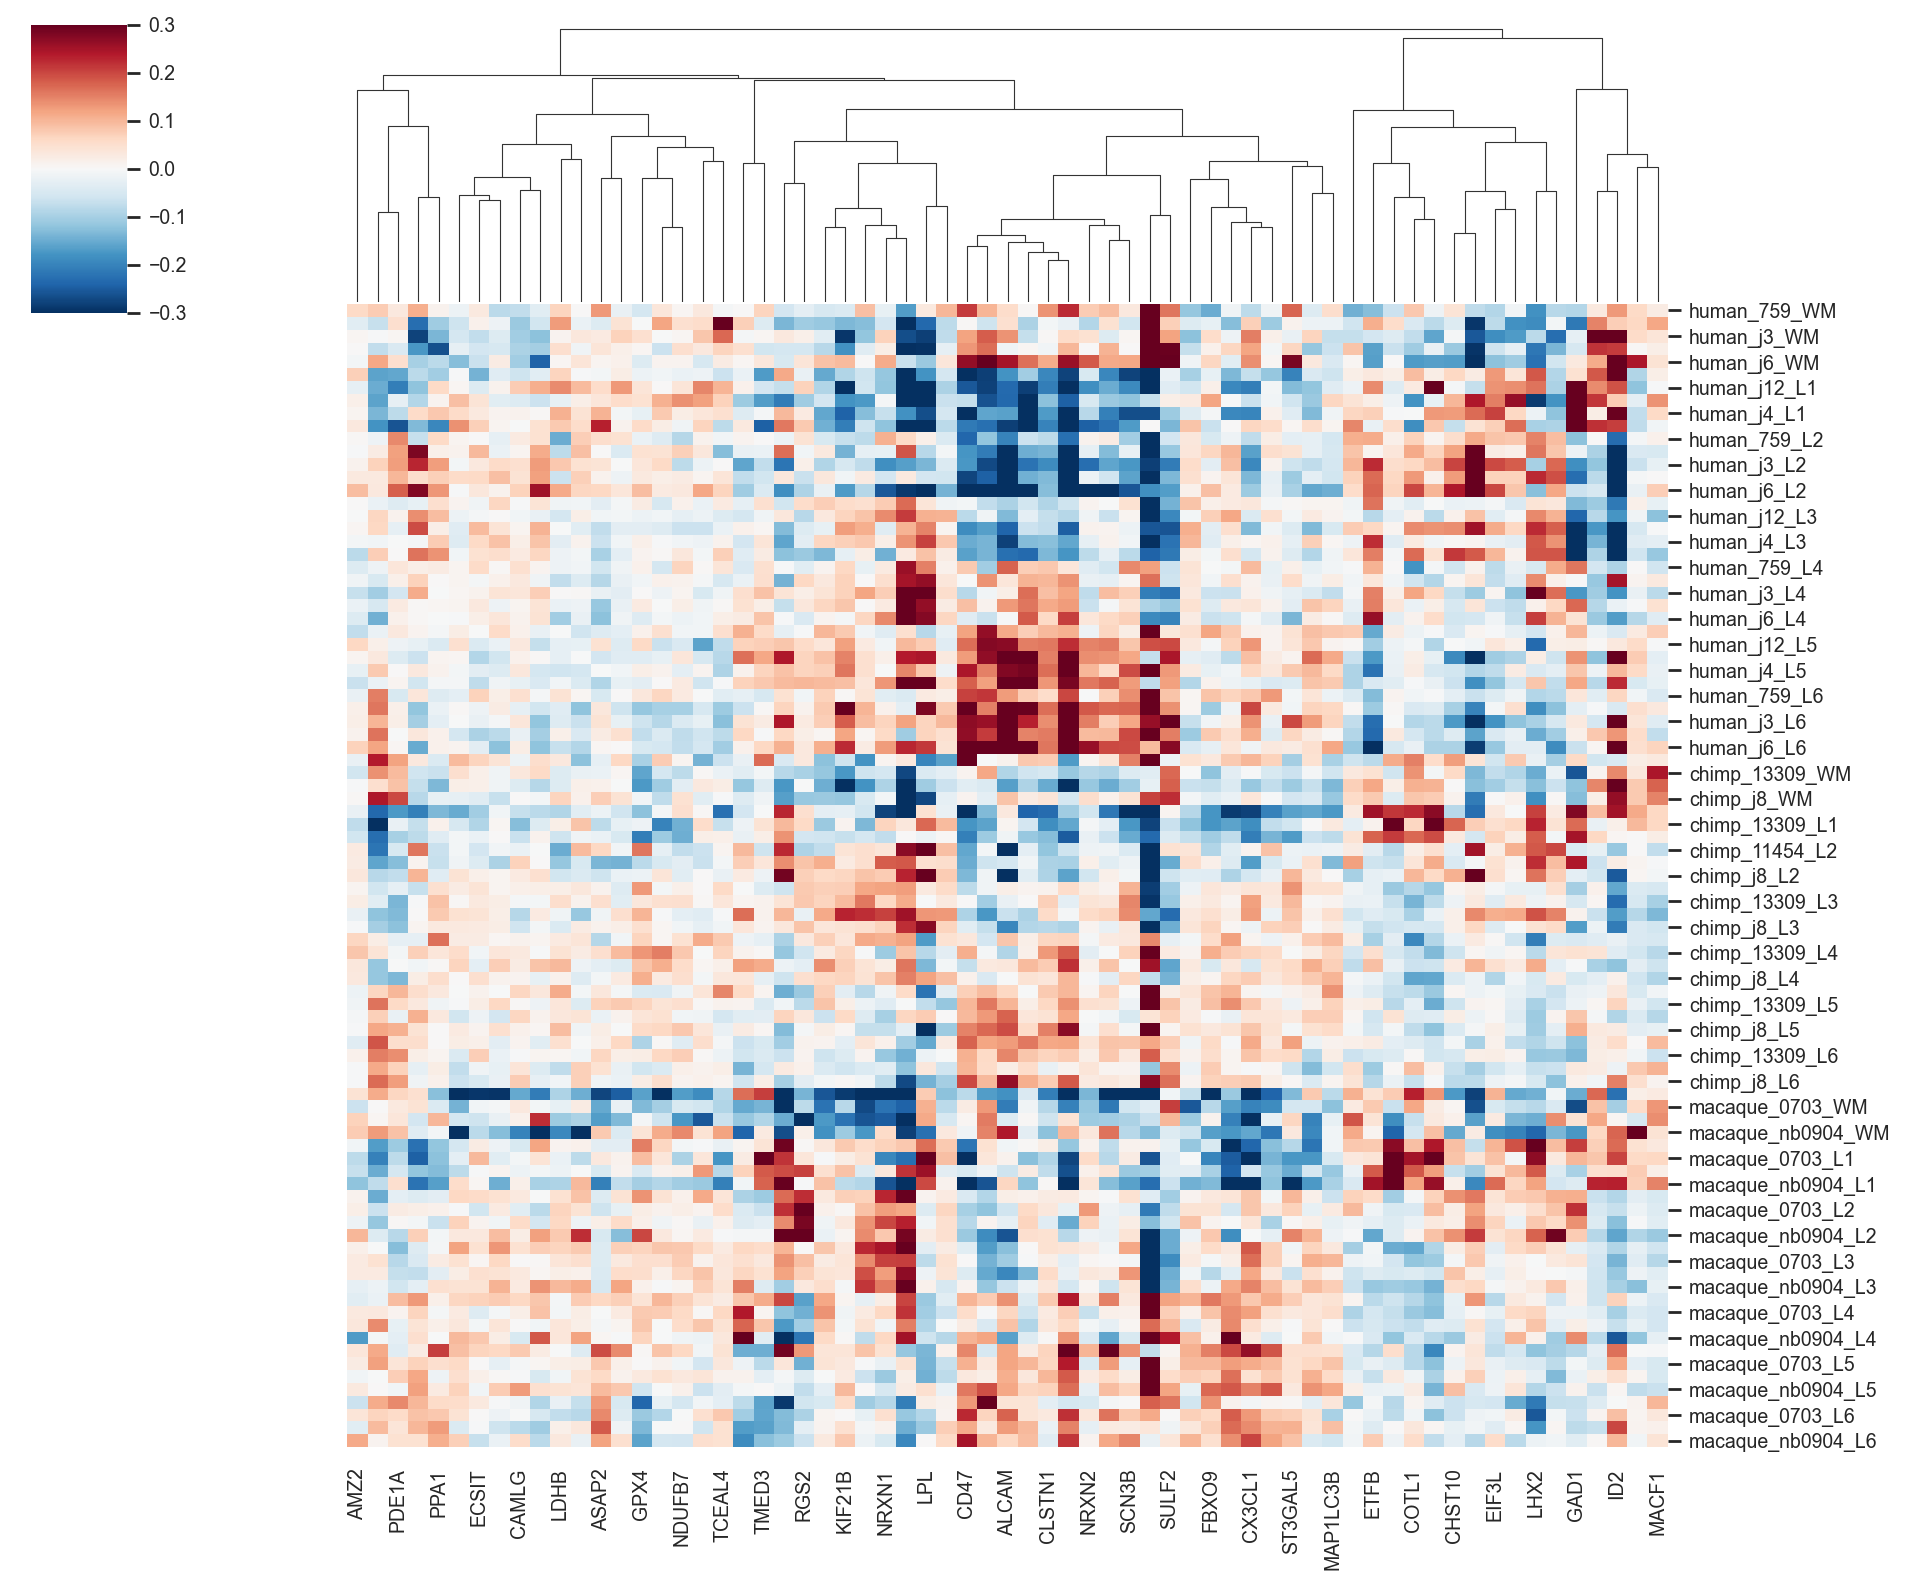

In [16]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

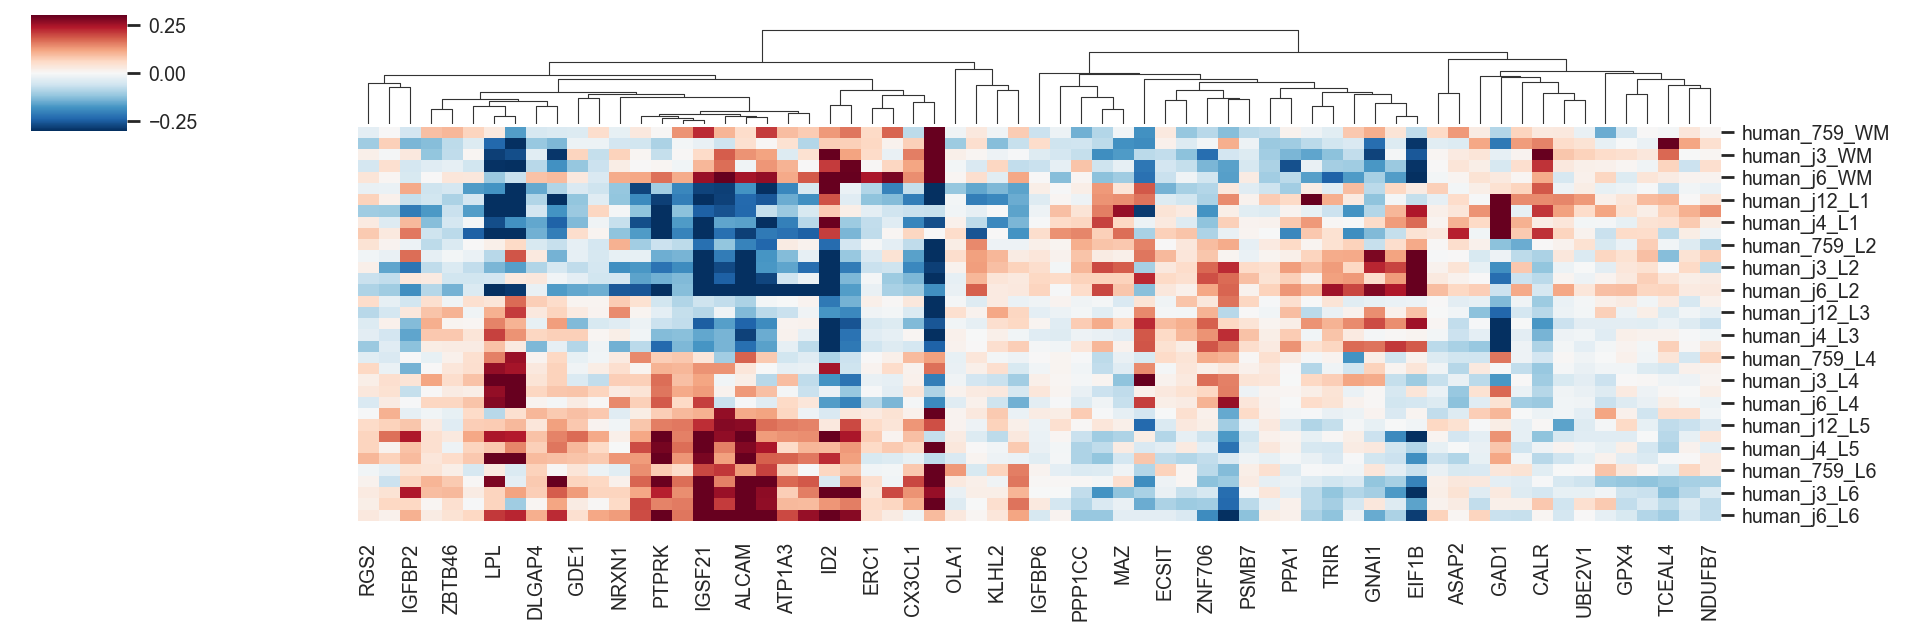

In [17]:
sns.clustermap(df_hs.loc[sample_order['human']], figsize=(12, 4), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [18]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
#aff_matrix = pairwise_kernels(df_hs.T, metric='cosine') + 1
n_clusters = 6
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=4)
#clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=4)
#clustering.fit(aff_matrix)
#clustering.fit(df_hs.T[sample_order['human']])
clustering.fit(df_hs.T)

SpectralClustering(affinity='nearest_neighbors', n_clusters=6, random_state=4)

In [19]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [20]:
labels.to_csv(f'./results/human_clusters_edgeR_{n_clusters}.csv')

In [21]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown', 'cyan', 'pink', 'violet', 'crimson']

In [22]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

[Text(0, 18.666666666666664, 'macaque'),
 Text(0, 45.333333333333336, 'chimp'),
 Text(0, 77.33333333333333, 'human')]

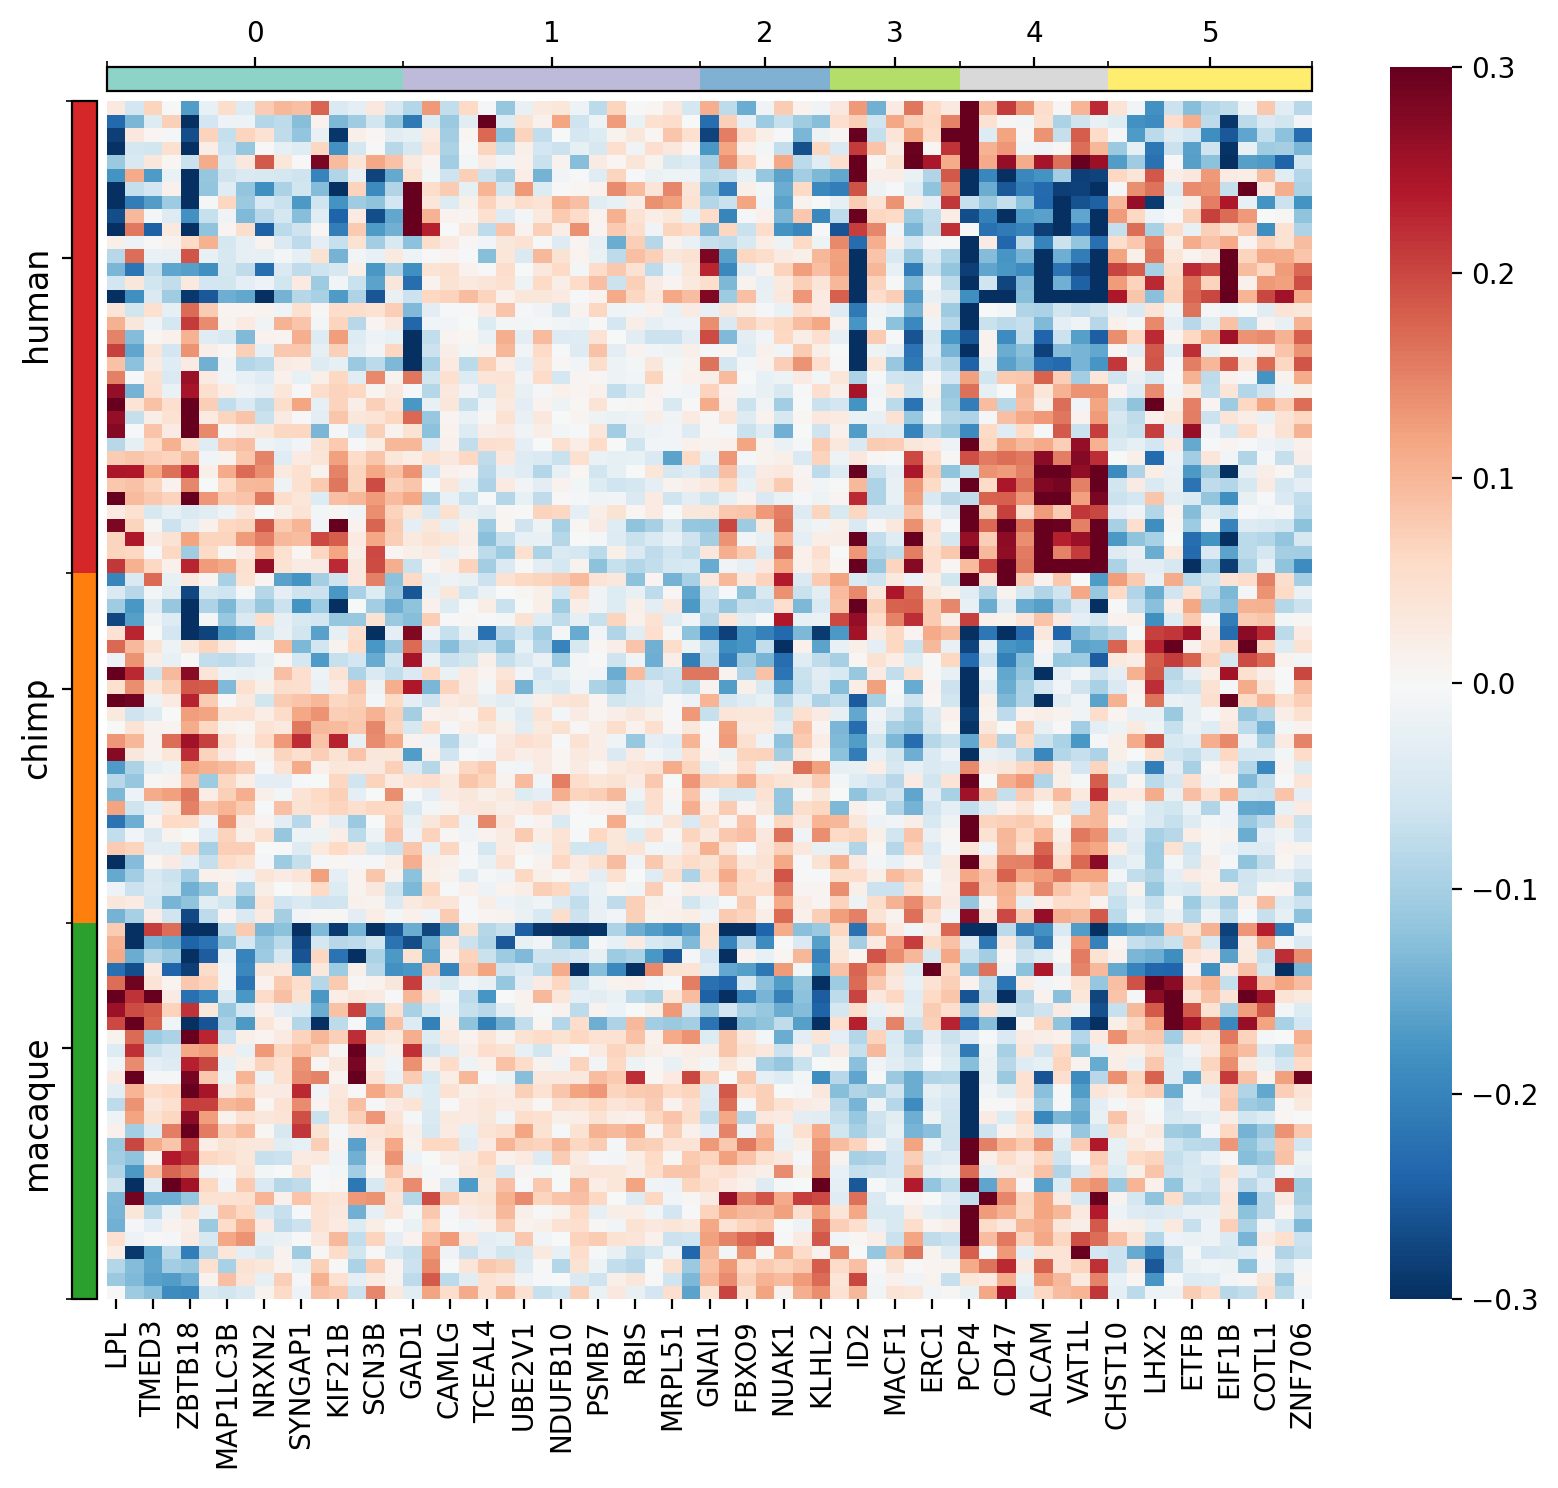

In [23]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

mpl.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0, cbar=True)
#ax.set_xticks([])
ax.set_yticks([])


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

# horisontal
cax = divider.append_axes('left', size='2%', pad=0.05)

cmap = mpl.colors.ListedColormap(['tab:red', 'tab:orange', 'tab:green'][::-1])
cond_size = adata_pb_norm.obs.condition.value_counts().loc[['human', 'chimp', 'macaque'][::-1]].values
cond_pos = cond_size.cumsum()
bounds = [0] + list(cond_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='vertical',
    spacing='proportional'
)

cax.yaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
cax.yaxis.set_major_formatter(ticker.FixedFormatter(['human', 'chimp', 'macaque'][::-1]))
cax.yaxis.tick_left()
cax.set_yticklabels(cax.get_yticklabels(), rotation=90, fontsize=12)

## Cluster profiles

In [24]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [25]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ALCAM      AMZ2     ASAH1     ASAP2    ATP1A3      CALR  \
condition layer                                                               
chimp     L1     0.009130 -0.052392 -0.031851 -0.038598 -0.103862  0.044611   
          L2    -0.242804  0.028607  0.066117 -0.045958 -0.009611 -0.049035   
          L3    -0.066325  0.001275  0.052351  0.015554  0.022002 -0.016073   
          L4     0.006249  0.053428  0.038820 -0.018668  0.020163 -0.030577   
          L5     0.134409 -0.010457  0.015541  0.026730  0.037409  0.003552   

                    CAMLG      CD47    CHST10    CLSTN1  ...     SULF2  \
condition layer                                          ...             
chimp     L1    -0.087819 -0.244322  0.040718 -0.182461  ... -0.033394   
          L2     0.025653 -0.146550  0.010696 -0.101397  ... -0.056414   
          L3    -0.033076 -0.050831  0.007123  0.014879  ... -0.149038   
          L4     0.018772  0.021584 -0.024548  0.076776  ... -0.074772   
          L5     0.037167  0.104353 -0.018866  0.084007  ...  0.045439   

                  SYNGAP1    TCEAL4     TMED3      TRIR    UBE2V1     VAT1L  \
condition layer                                                               
chimp     L1    -0.081355 -0.091458  0.020563 -0.036320 -0.043993 -0.134595   
          L2     0.062641 -0.007720 -0.013718  0.016361 -0.057331 -0.027984   
          L3     0.136546  0.020293 -0.001658  0.007374 -0.001055 -0.090556   
          L4     0.048609  0.049130  0.015202  0.016510  0.017603 -0.019777   
          L5    -0.052720  0.020766 -0.015029  0.009316  0.021531  0.138460   

                   ZBTB18    ZBTB46    ZNF706  
condition layer                                
chimp     L1    -0.154330  0.026107  0.020416  
          L2     0.229193  0.072883  0.121583  
          L3     0.178206  0.070541  0.067006  
          L4     0.129230  0.024286 -0.001815  
          L5     0.023022 -0.064324 -0.035676  

[5 rows x 65 columns]

In [26]:
# fig, axes = plt.subplots(2, 2,  figsize=(14, 3.5 * 2), gridspec_kw={'hspace': 0.4})
# for gene, ax in zip(layer_mean.columns, axes.flatten()):
#     (
#             layer_mean[gene]
#             .reorder_levels(['layer', 'condition'])
#             .unstack().loc[layers]
#             .plot
#             .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
#     )
#     ax.grid(False)

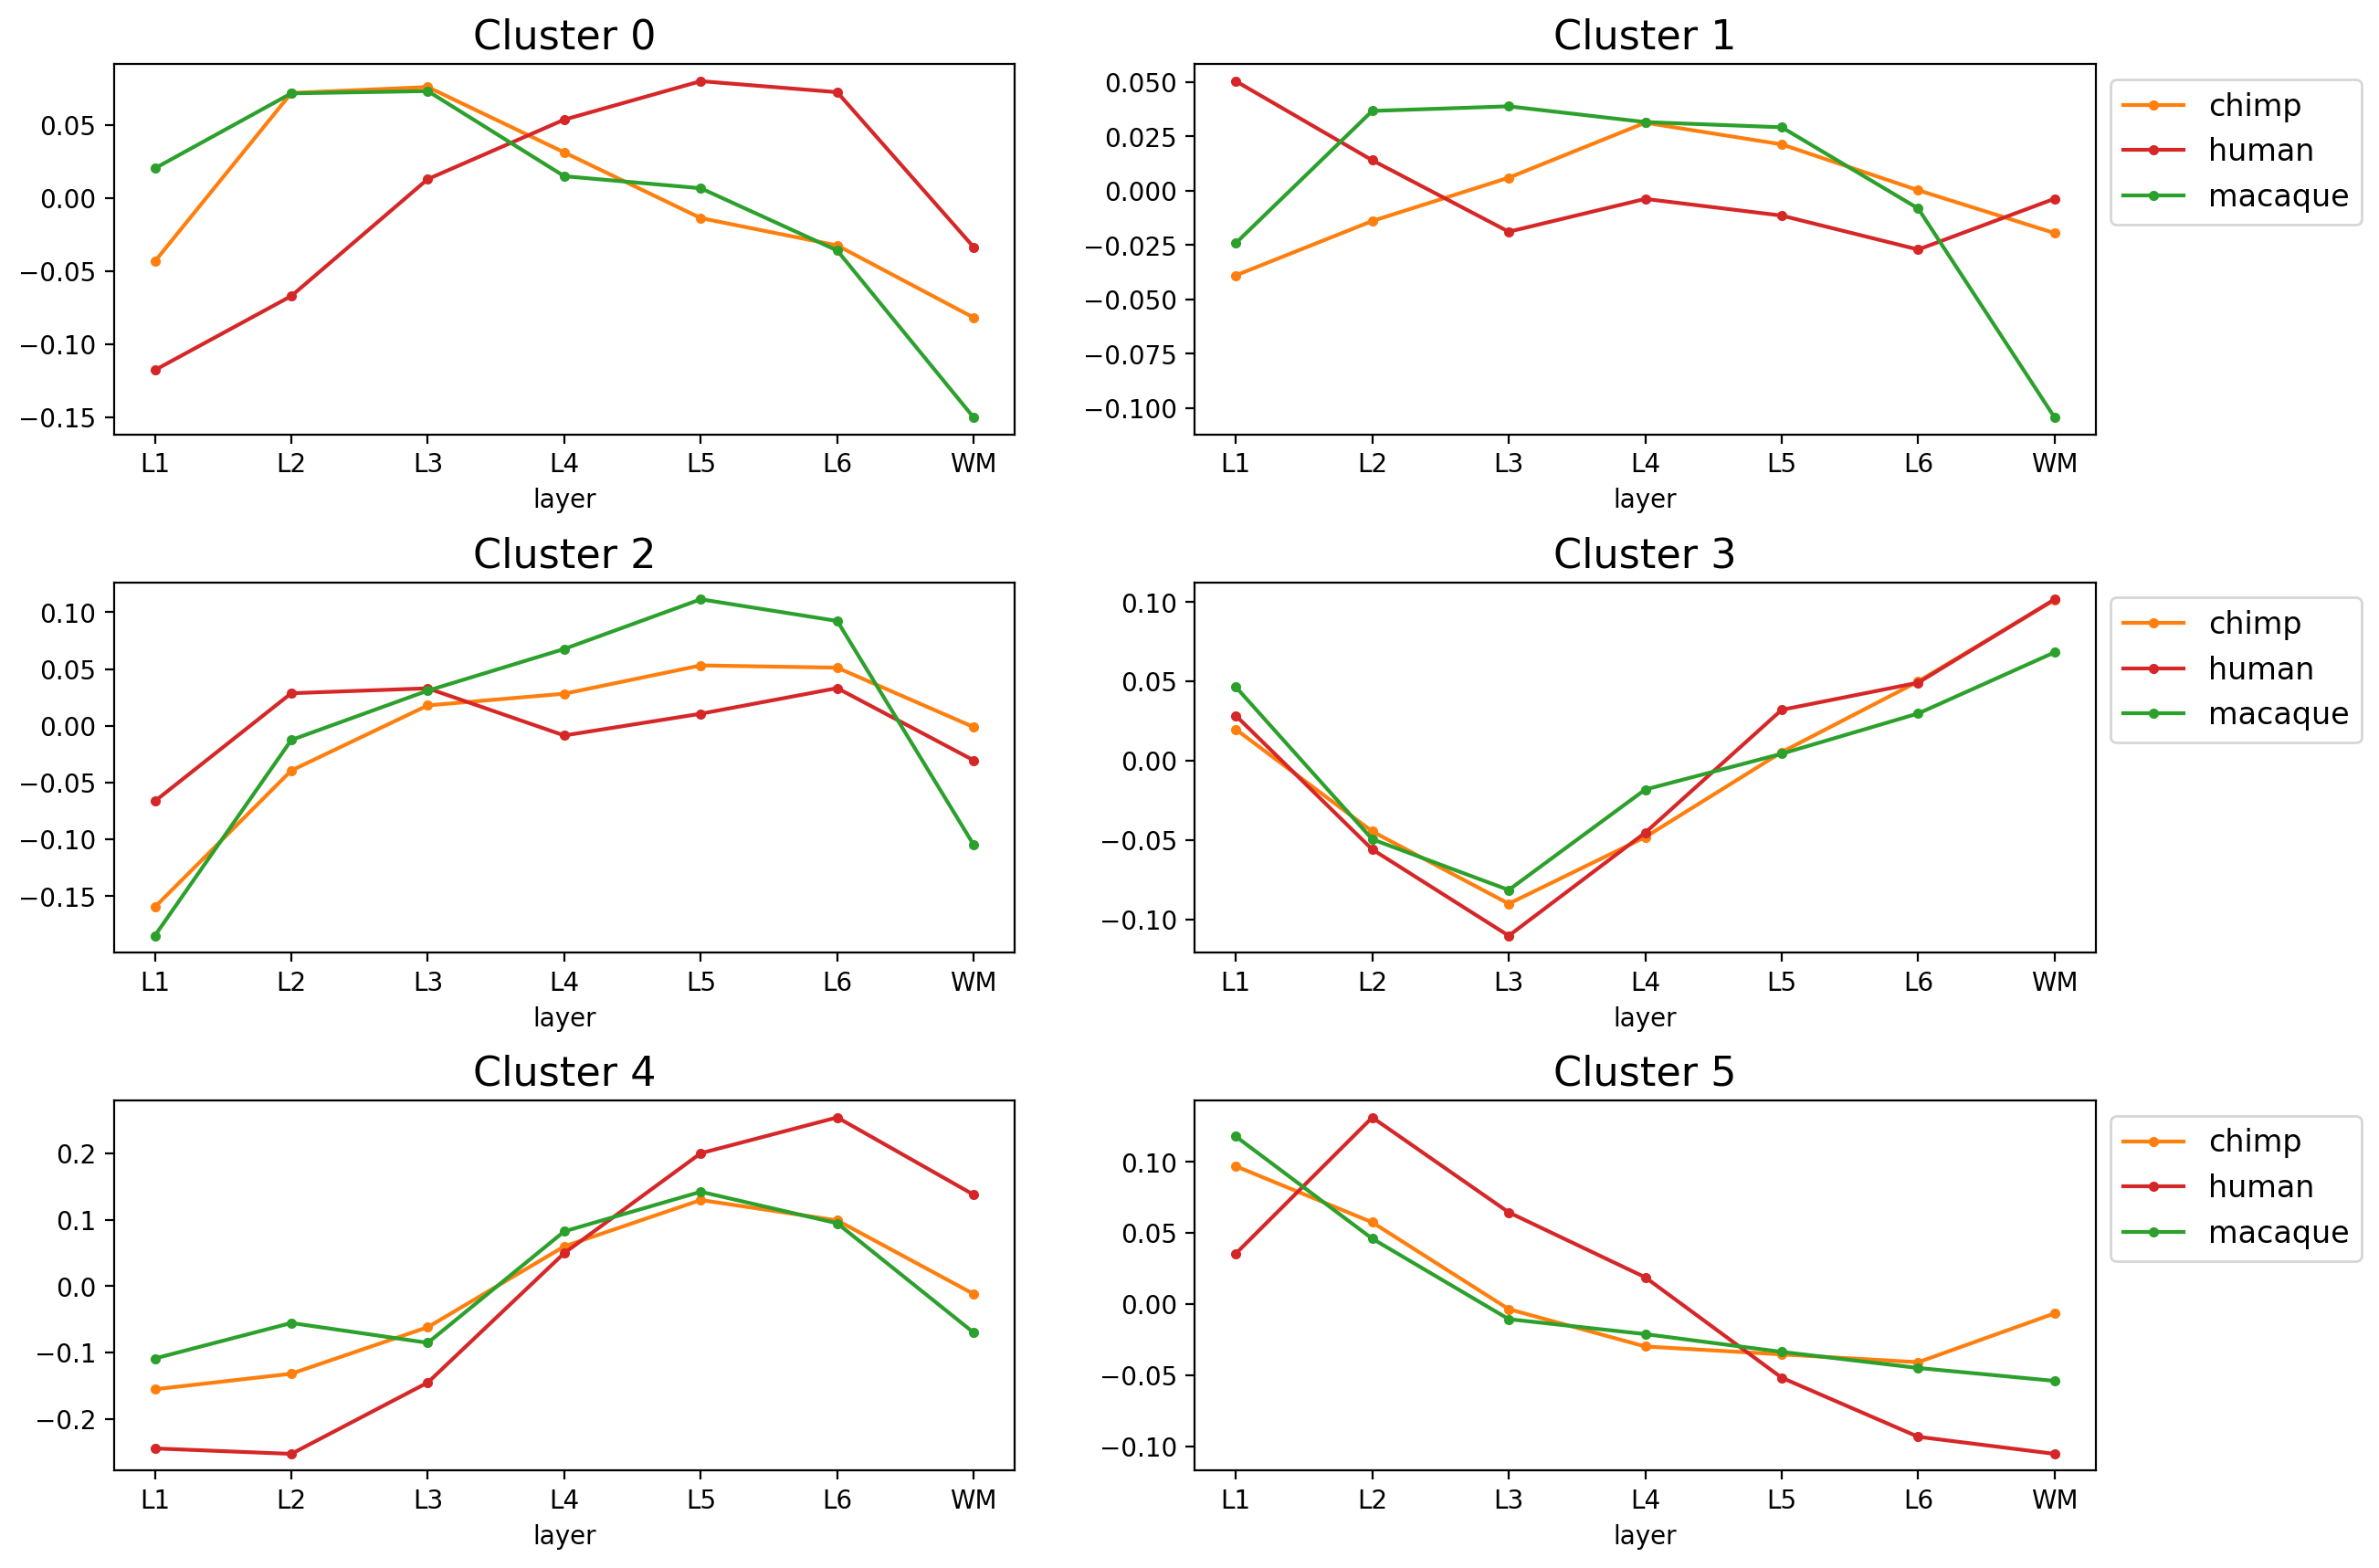

In [27]:
mpl.rcdefaults()
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    if label % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    #ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

In [28]:
grid = np.linspace(1, 7, 400)
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green']

In [29]:
df_cont = df_annotation.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

In [30]:
from scipy.interpolate import UnivariateSpline

array = np.zeros((grid.size, hs_genes.size))
df_list = []

for specie in conditions:
    for i, gene in enumerate(hs_genes.to_list()):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=hs_genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

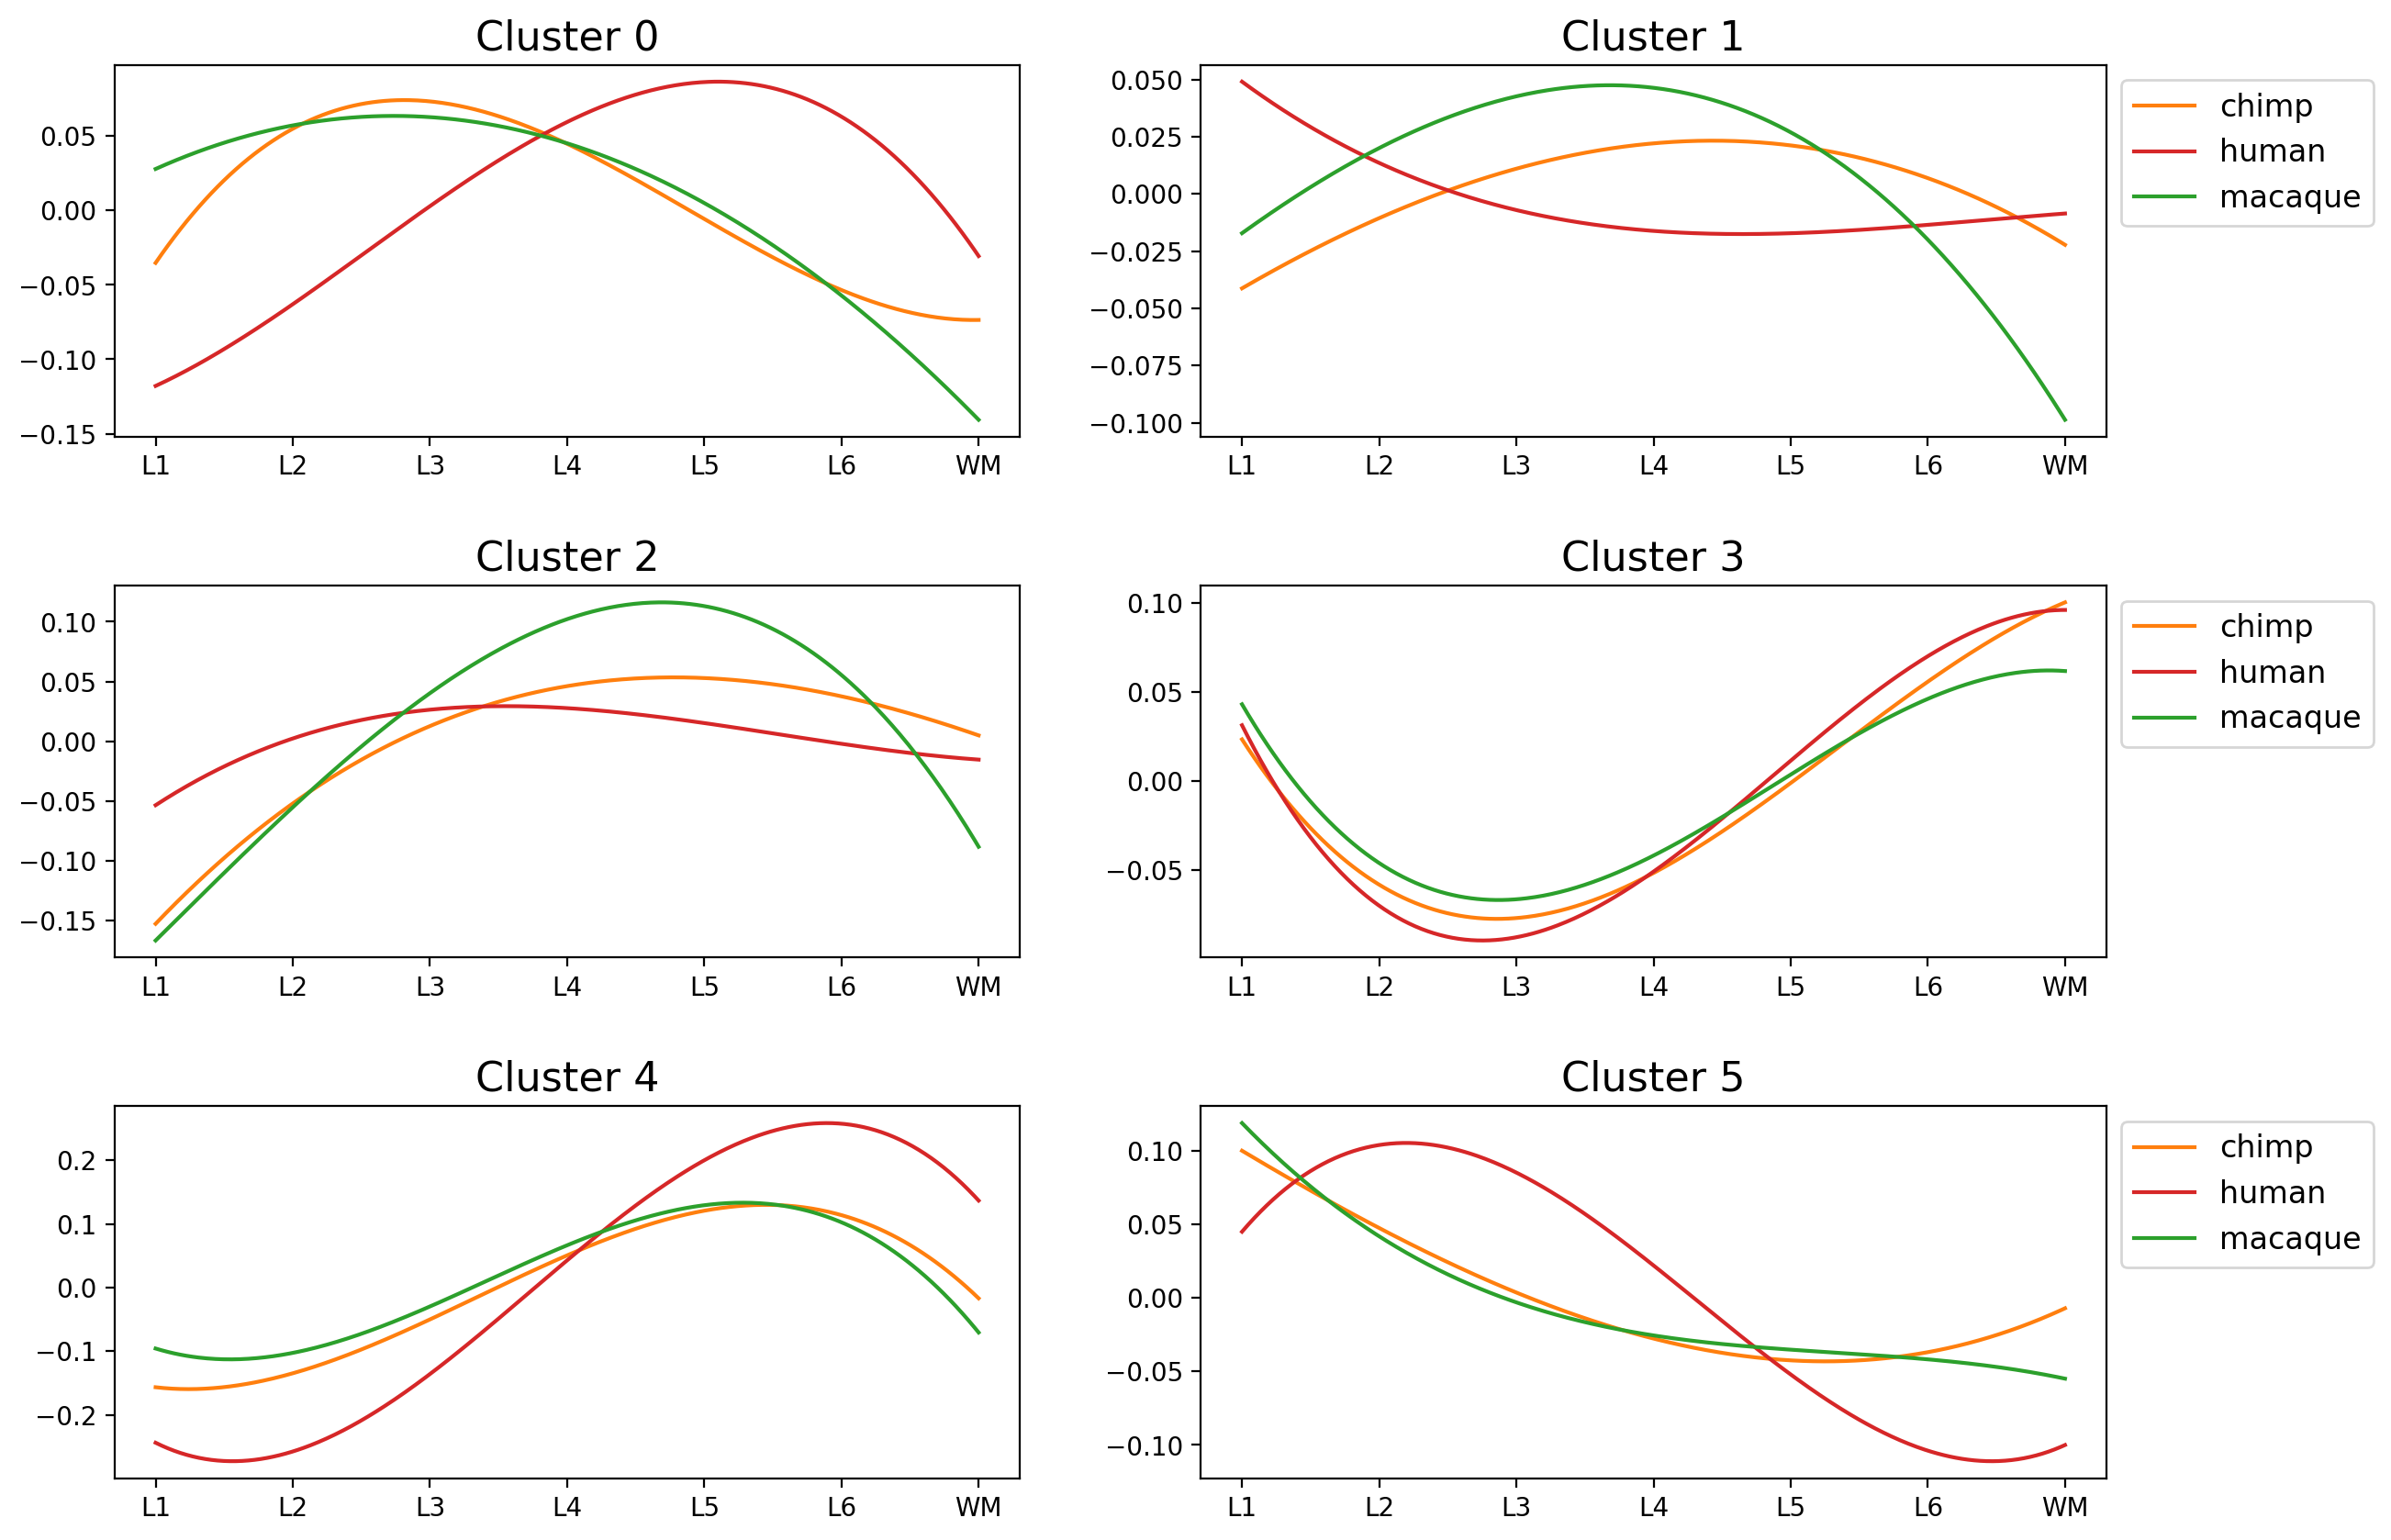

In [31]:
mpl.rcdefaults()
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()
    # plot the splines
    genes = labels[labels == label].index.tolist()
    df_cluster_spline = df_spline[genes].mean(axis=1).to_frame()
    df_cluster_spline['condition'] = df_spline['condition']
    df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=0)
    df_cluster_spline.index = grid
    df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax)

    # plot the dots
    # df_layers = layer_mean[genes].mean(axis=1).reorder_levels(['layer', 'condition']).unstack().loc[layers][conditions]
    # df_layers.index = np.arange(1, 8)
    # ax.set_prop_cycle(color=['tab:red', 'tab:orange', 'tab:green'])
    # ax.plot(df_layers, 'o', alpha=0.7)
    # ax.legend(conditions)
    
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
    
    if label % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    #ax.hlines(0, xmin=1, xmax=6, colors='gray', linestyles='dashed')

# 4 Species

In [32]:
pb_dir_path = '../data/pseudobulks/'
adata_pb_4spe = sc.read_h5ad(pb_dir_path + '4spe_pb_mean_filt_nor_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_4spe

AnnData object with n_obs × n_vars = 116 × 6523
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    var: 'gene_name'
    uns: 'log1p'

In [33]:
df_4spe = pd.DataFrame(adata_pb_4spe.X, index=adata_pb_4spe.obs_names, columns=adata_pb_4spe.var_names)

In [34]:
hs_genes_inter = df_4spe.columns.intersection(hs_genes)
hs_genes_inter.size

34

In [35]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'treeshrew']:
    samples = df_4spe.loc[df_4spe.index.str.contains(cond)].index
    order_s = sorted(samples.to_list(), key=lambda x: x[:2])
    order_laminar = list(filter(lambda x: 'L' in x, order_s))
    order_wm = list(filter(lambda x: 'WM' in x, order_s))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['treeshrew']
df_4spe = df_4spe.loc[sample_order['all']]
df_4spe_hs = df_4spe[hs_genes_inter]

In [36]:
order_4spe = order.intersection(hs_genes_inter)

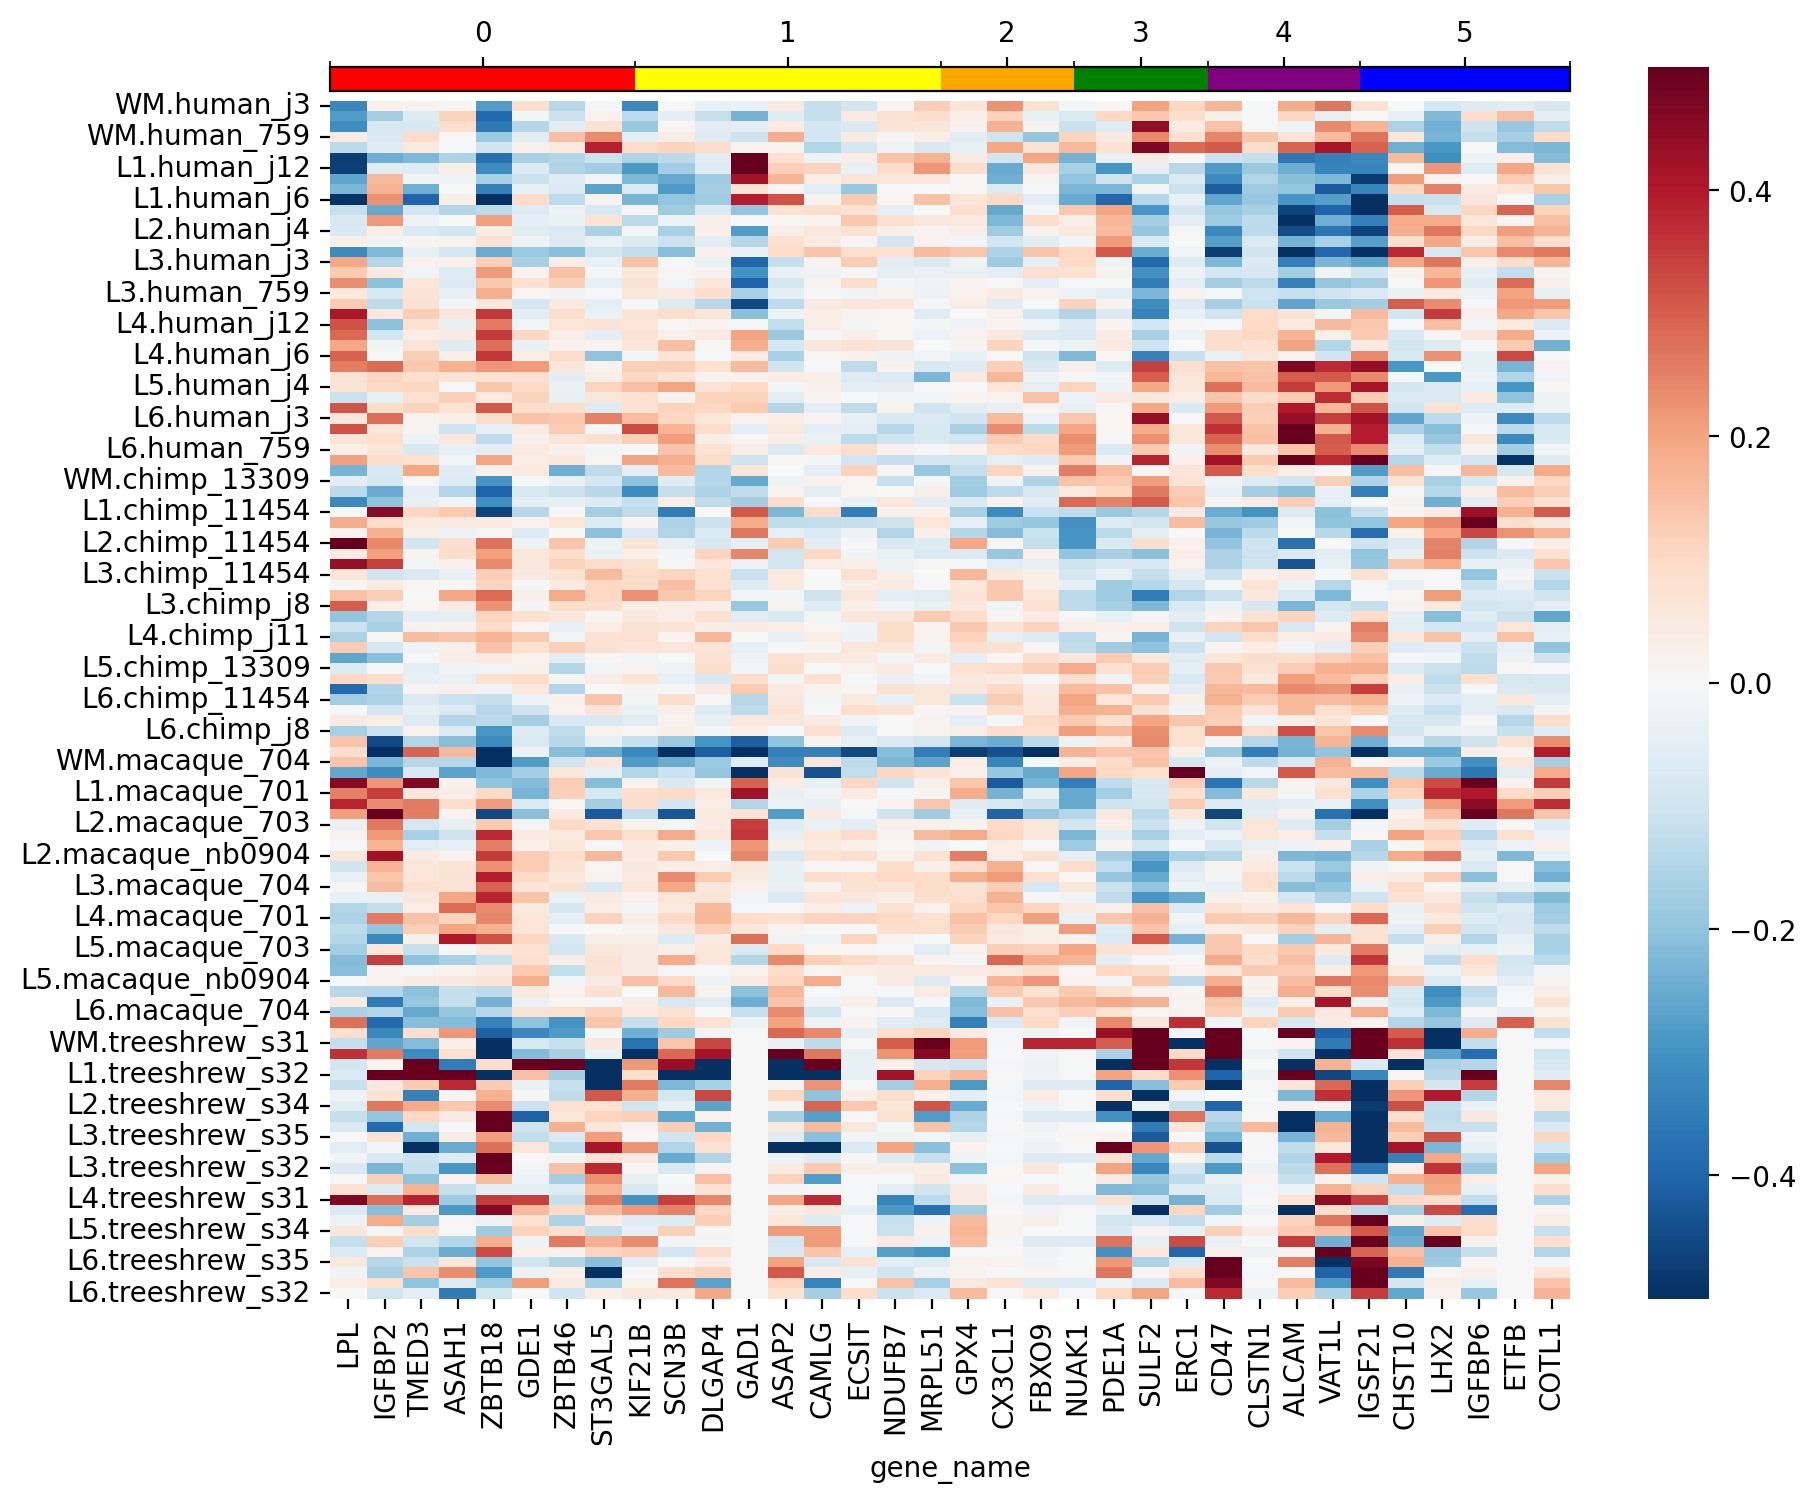

In [37]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

mpl.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_4spe_hs[order_4spe], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles (mean)

In [38]:
df_annotation = df_4spe_hs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [39]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          CLSTN1    IGSF21    KIF21B    ZBTB18     ASAP2   ST3GAL5  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.204243 -0.231617 -0.061434 -0.137080 -0.131812 -0.147280   
          L2    -0.104800 -0.164320  0.055080  0.238887 -0.019229  0.012444   
          L3     0.015519 -0.013440  0.114423  0.185809  0.024485  0.112985   
          L4     0.085212  0.176425  0.066458  0.131912 -0.022616  0.050056   

gene_name          CHST10      GAD1     PDE1A    IGFBP2  ...    CX3CL1  \
condition layer                                          ...             
chimp     6a          NaN       NaN       NaN       NaN  ...       NaN   
          L1     0.076940  0.254899 -0.130202  0.242133  ... -0.237209   
          L2     0.010290  0.057583 -0.106655  0.263202  ... -0.079315   
          L3    -0.004323 -0.096759 -0.141881  0.024044  ...  0.075322   
          L4    -0.029128 -0.015837 -0.045474 -0.096674  ...  0.029724   

gene_name           VAT1L     COTL1    DLGAP4     SULF2    ZBTB46      GPX4  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.182161  0.173074 -0.060895 -0.097234  0.019432 -0.120014   
          L2    -0.033289  0.082431  0.030224 -0.066972  0.116313  0.035109   
          L3    -0.114673 -0.103039  0.075901 -0.208340  0.099157  0.086865   
          L4    -0.013995 -0.137491  0.084863 -0.101434  0.029338  0.106402   

gene_name           ECSIT    NDUFB7      ETFB  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1    -0.162918 -0.075886  0.162136  
          L2     0.002185 -0.045815 -0.038228  
          L3     0.048177  0.000558 -0.048922  
          L4     0.017193  0.075373  0.016441  

[5 rows x 34 columns]

Text(0.5, 0.98, 'Mean averaging for profiles')

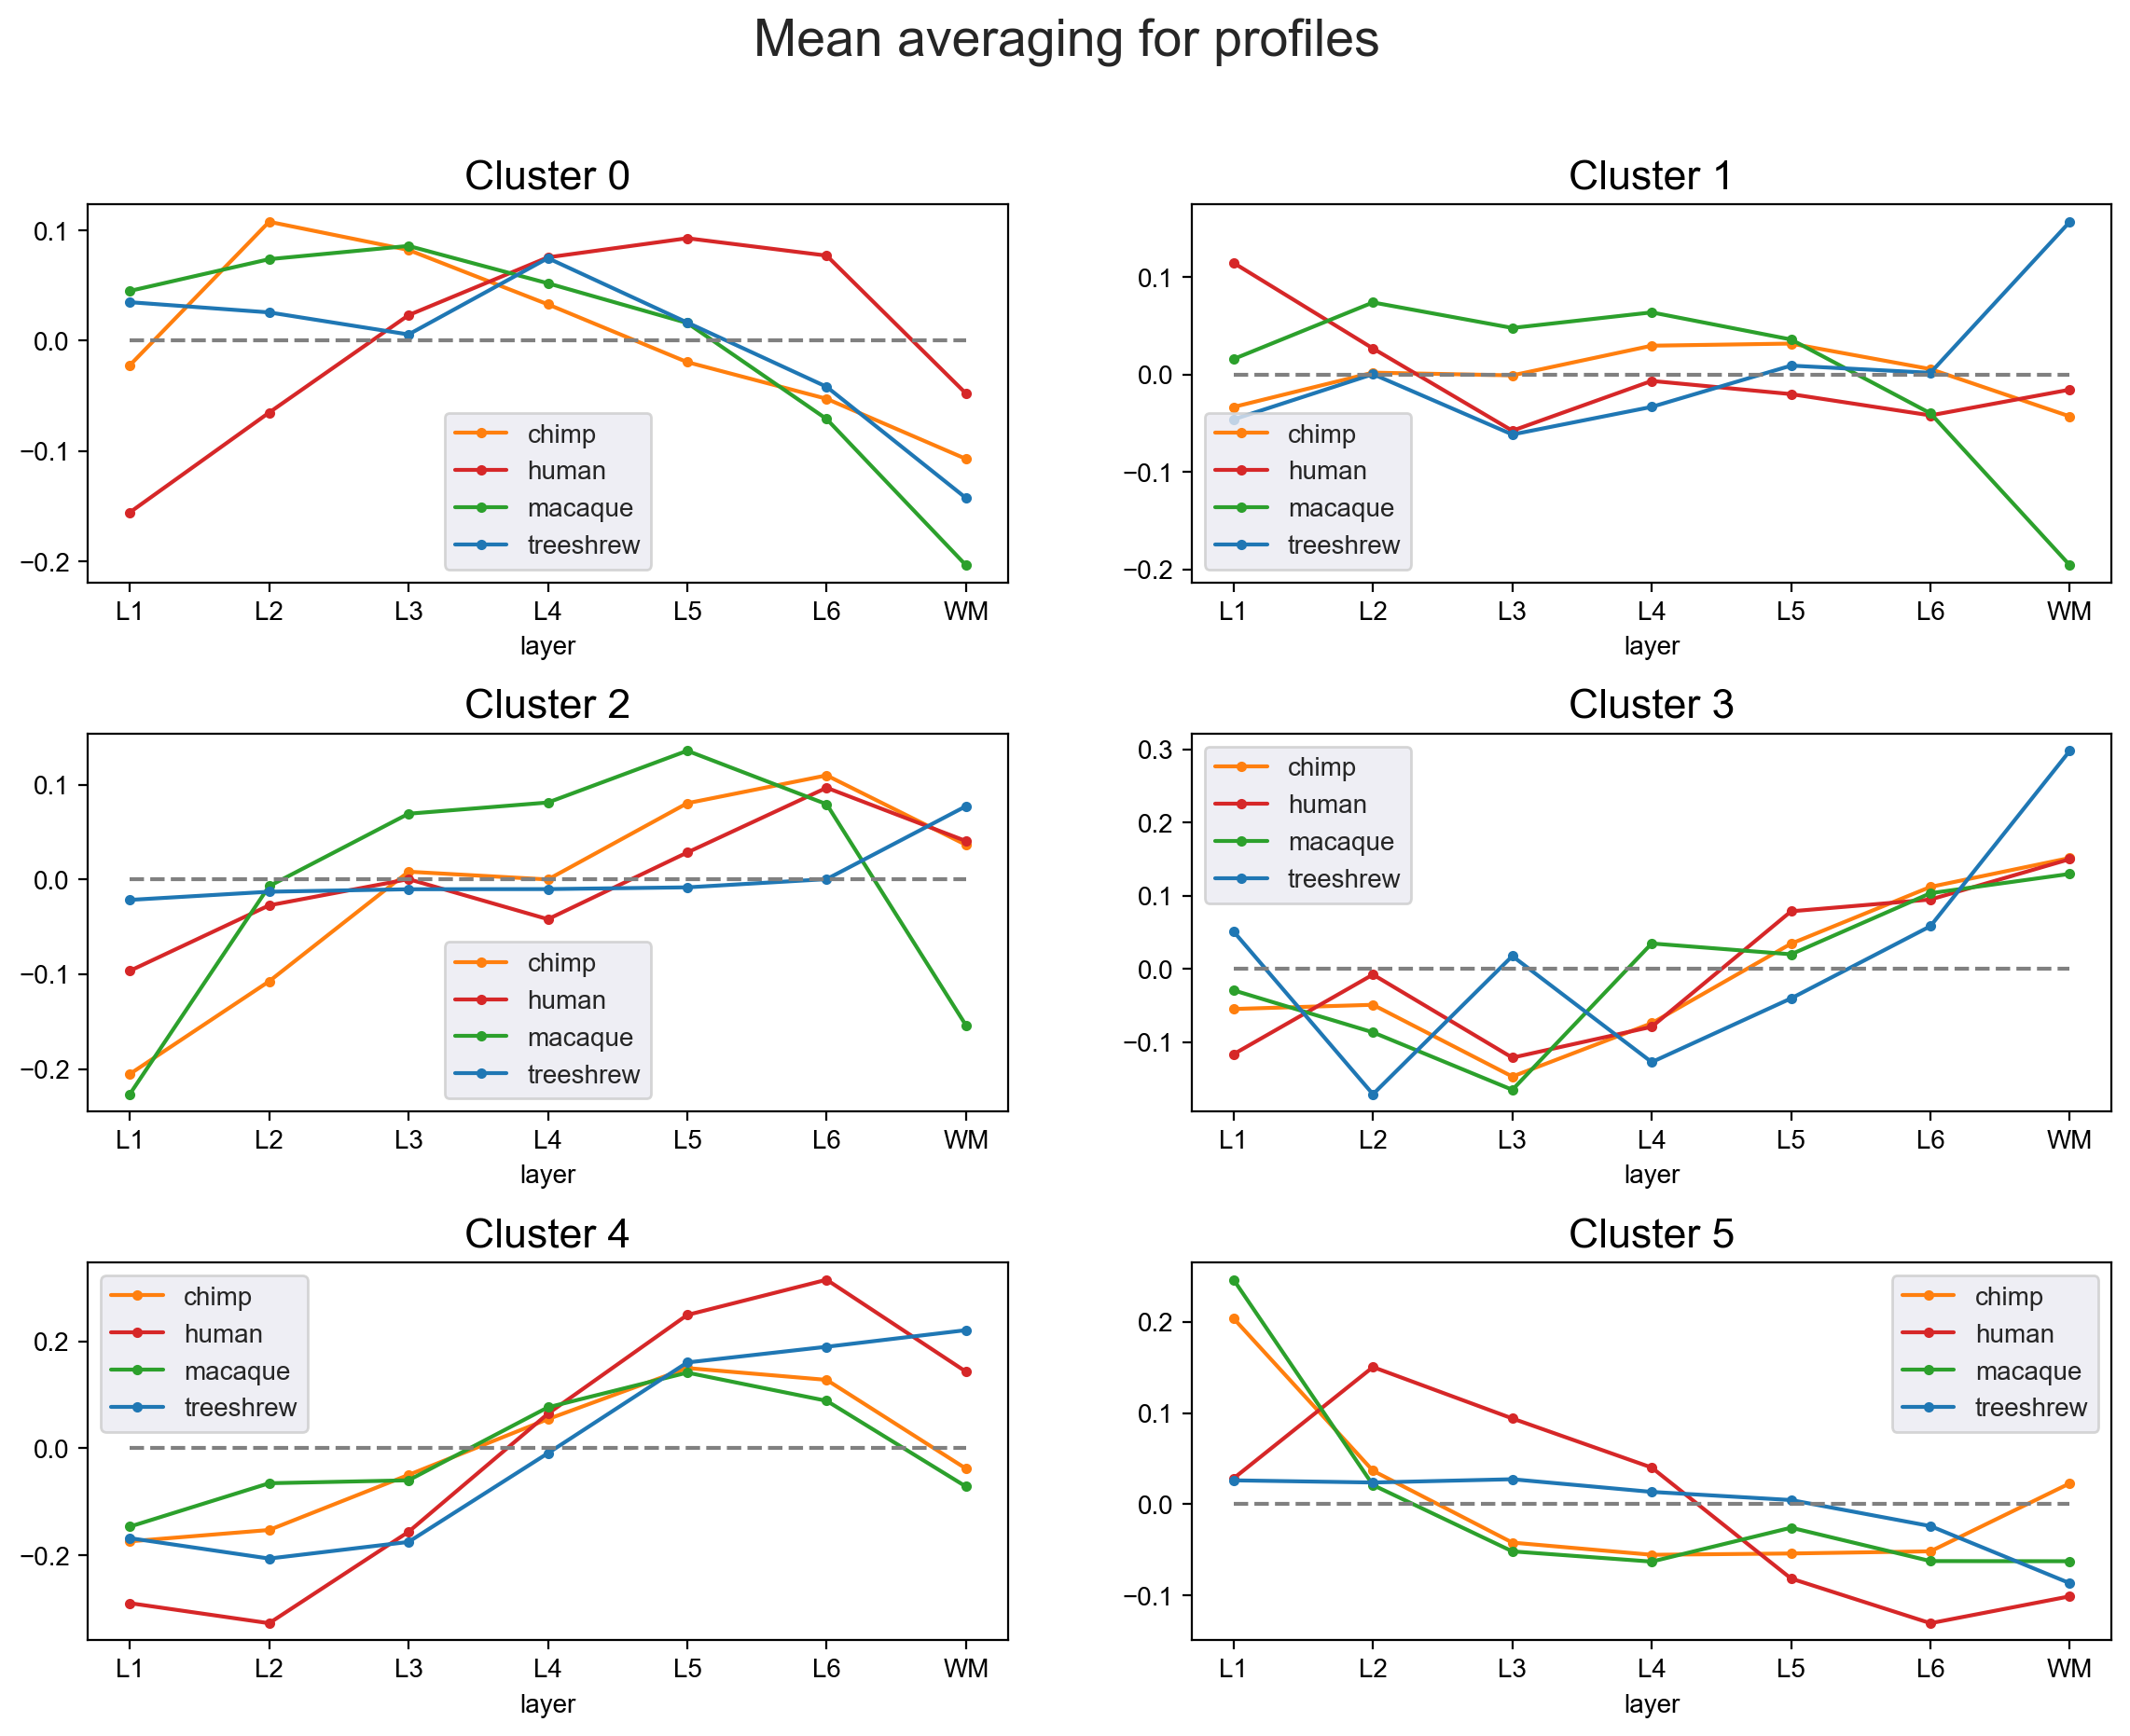

In [40]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean averaging for profiles', fontsize=20)

# Functional analysis

In [41]:
import gseapy
#gseapy.get_library_name()

In [42]:
enr_bg = gseapy.enrichr(gene_list=hs_genes.to_list(),
                        gene_sets=['GO_Biological_Process_2021', 'Azimuth_Cell_Types_2021', 'SynGO_2022', 'KEGG_2021_Human'],
                        outdir=None, # don't write to disk
                        background=background_genes
                       ).results

In [43]:
enr_bg[enr_bg['Adjusted P-value'] < 0.05].index.size

1

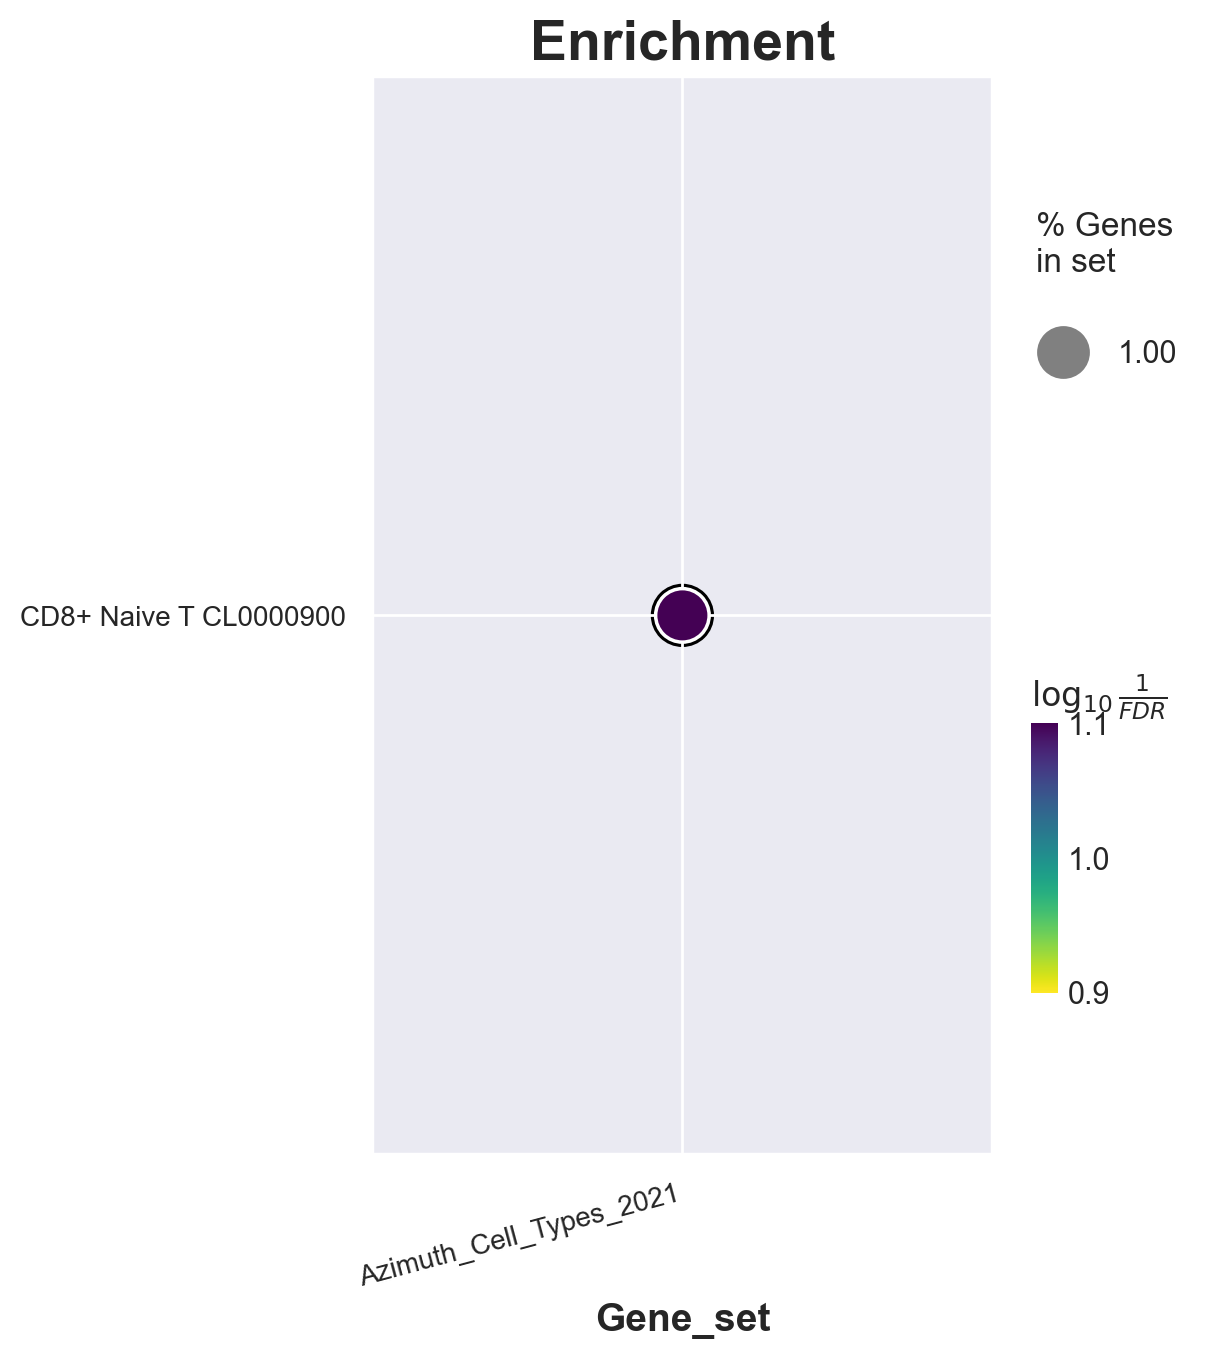

In [44]:
# categorical scatterplot
try:
    ax = gseapy.dotplot(enr_bg,
                column="Adjusted P-value",
                x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                size=3,
                top_term=6,
                figsize=(5,7),
                title = "Enrichment",
                xticklabels_rot=15, # rotate xtick labels
                show_ring=True, # set to False to revmove outer ring
                marker='o',
                )

    ax.tick_params(axis='both', which='major', labelsize=10)
except e:
    print(e)

In [45]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/6 [00:00<?, ?it/s]

## GO_Biological_Process_2023

In [46]:
db_name = 'GO_Biological_Process_2023'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [47]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Vocal Learning (GO:0042297)                            1  0.000024   
Imitative Learning (GO:0098596)                        2  0.000024   
Auditory Behavior (GO:0031223)                         3  0.000024   
Learned Vocalization Behavior Or Vocal Learning...     4  0.000024   
Postsynaptic Density Assembly (GO:0097107)             5  0.000024   

                                                       Z-score  \
Term                                                             
Vocal Learning (GO:0042297)                         555.142857   
Imitative Learning (GO:0098596)                     555.142857   
Auditory Behavior (GO:0031223)                      555.142857   
Learned Vocalization Behavior Or Vocal Learning...  555.142857   
Postsynaptic Density Assembly (GO:0097107)          555.142857   

                                                    Combined score  \
Term                                                                 
Vocal Learning (GO:0042297)                            5912.892048   
Imitative Learning (GO:0098596)                        5912.892048   
Auditory Behavior (GO:0031223)                         5912.892048   
Learned Vocalization Behavior Or Vocal Learning...     5912.892048   
Postsynaptic Density Assembly (GO:0097107)             5912.892048   

                                                   Overlapping genes  \
Term                                                                   
Vocal Learning (GO:0042297)                           [NRXN1, NRXN2]   
Imitative Learning (GO:0098596)                       [NRXN1, NRXN2]   
Auditory Behavior (GO:0031223)                        [NRXN1, NRXN2]   
Learned Vocalization Behavior Or Vocal Learning...    [NRXN1, NRXN2]   
Postsynaptic Density Assembly (GO:0097107)            [NRXN1, NRXN2]   

                                                    Adjusted P-value  \
Term                                                                   
Vocal Learning (GO:0042297)                                 0.000843   
Imitative Learning (GO:0098596)                             0.000843   
Auditory Behavior (GO:0031223)                              0.000843   
Learned Vocalization Behavior Or Vocal Learning...          0.000843   
Postsynaptic Density Assembly (GO:0097107)                  0.000843   

                                                    Old p-value  \
Term                                                              
Vocal Learning (GO:0042297)                                   0   
Imitative Learning (GO:0098596)                               0   
Auditory Behavior (GO:0031223)                                0   
Learned Vocalization Behavior Or Vocal Learning...            0   
Postsynaptic Density Assembly (GO:0097107)                    0   

                                                    Old adjusted p-value  \
Term                                                                       
Vocal Learning (GO:0042297)                                            0   
Imitative Learning (GO:0098596)                                        0   
Auditory Behavior (GO:0031223)                                         0   
Learned Vocalization Behavior Or Vocal Learning...                     0   
Postsynaptic Density Assembly (GO:0097107)                             0   

                                                    num_overlap_genes  \
Term                                                                    
Vocal Learning (GO:0042297)                                         2   
Imitative Learning (GO:0098596)                                     2   
Auditory Behavior (GO:0031223)                                      2   
Learned Vocalization Behavior Or Vocal Learning...                  2   
Postsynaptic Density Assembly (GO:0097107)                          2   

                                                    neg_log10(p_adj)  \
Term      

In [48]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

37

In [49]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

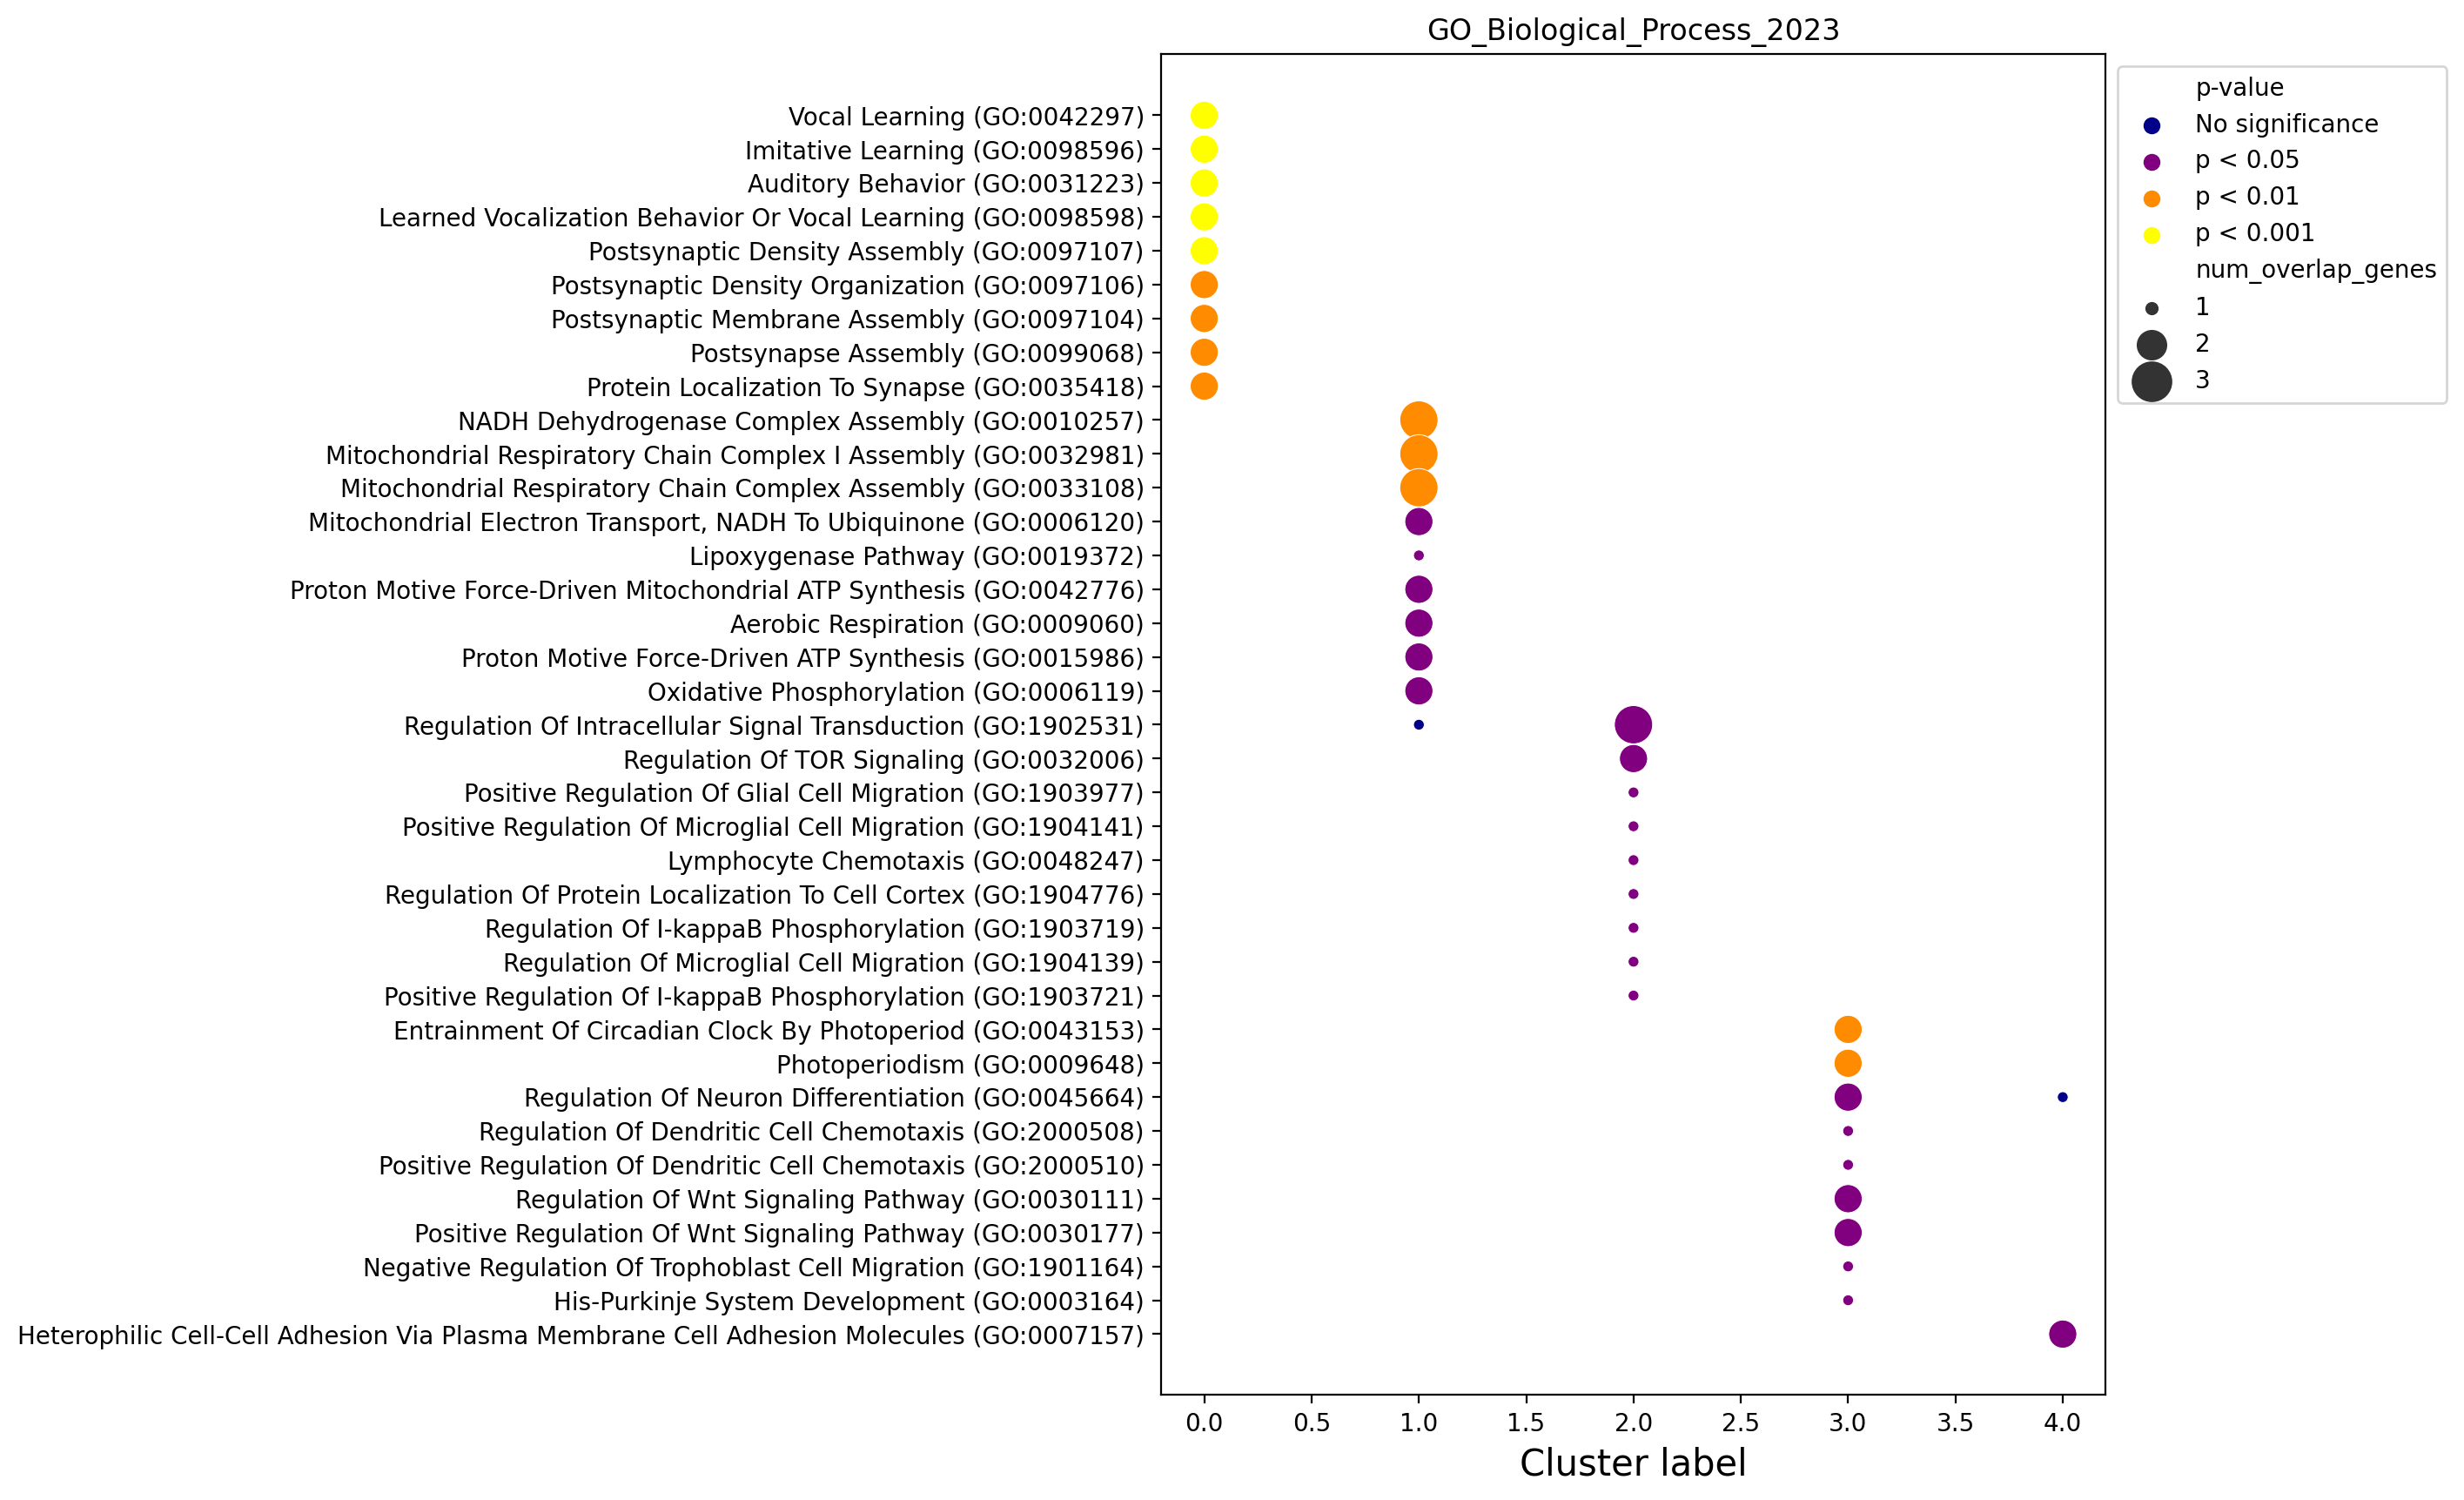

In [50]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## GO_Molecular_Function_2023

In [51]:
db_name = 'GO_Molecular_Function_2023'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [52]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Calcium Channel Regulator Activity (GO:0005246)        1  0.000594   
N-acylsphingosine Amidohydrolase Activity (GO:0...     2  0.004104   
Acetylcholine Receptor Binding (GO:0033130)            3  0.006150   
Sodium Channel Inhibitor Activity (GO:0019871)         4  0.008192   
DNA-binding Transcription Repressor Activity, R...     5  0.011114   

                                                       Z-score  \
Term                                                             
Calcium Channel Regulator Activity (GO:0005246)      69.267857   
N-acylsphingosine Amidohydrolase Activity (GO:0...  518.200000   
Acetylcholine Receptor Binding (GO:0033130)         259.066667   
Sodium Channel Inhibitor Activity (GO:0019871)      172.688889   
DNA-binding Transcription Repressor Activity, R...   14.280148   

                                                    Combined score  \
Term                                                                 
Calcium Channel Regulator Activity (GO:0005246)         514.604235   
N-acylsphingosine Amidohydrolase Activity (GO:0...     2847.943283   
Acetylcholine Receptor Binding (GO:0033130)            1318.994950   
Sodium Channel Inhibitor Activity (GO:0019871)          829.703384   
DNA-binding Transcription Repressor Activity, R...       64.254443   

                                                   Overlapping genes  \
Term                                                                   
Calcium Channel Regulator Activity (GO:0005246)       [NRXN1, NRXN2]   
N-acylsphingosine Amidohydrolase Activity (GO:0...           [ASAH1]   
Acetylcholine Receptor Binding (GO:0033130)                  [NRXN1]   
Sodium Channel Inhibitor Activity (GO:0019871)               [SCN3B]   
DNA-binding Transcription Repressor Activity, R...  [ZBTB18, ZBTB46]   

                                                    Adjusted P-value  \
Term                                                                   
Calcium Channel Regulator Activity (GO:0005246)             0.020185   
N-acylsphingosine Amidohydrolase Activity (GO:0...          0.059569   
Acetylcholine Receptor Binding (GO:0033130)                 0.059569   
Sodium Channel Inhibitor Activity (GO:0019871)              0.059569   
DNA-binding Transcription Repressor Activity, R...          0.059569   

                                                    Old p-value  \
Term                                                              
Calcium Channel Regulator Activity (GO:0005246)               0   
N-acylsphingosine Amidohydrolase Activity (GO:0...            0   
Acetylcholine Receptor Binding (GO:0033130)                   0   
Sodium Channel Inhibitor Activity (GO:0019871)                0   
DNA-binding Transcription Repressor Activity, R...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Calcium Channel Regulator Activity (GO:0005246)                        0   
N-acylsphingosine Amidohydrolase Activity (GO:0...                     0   
Acetylcholine Receptor Binding (GO:0033130)                            0   
Sodium Channel Inhibitor Activity (GO:0019871)                         0   
DNA-binding Transcription Repressor Activity, R...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Calcium Channel Regulator Activity (GO:0005246)                     2   
N-acylsphingosine Amidohydrolase Activity (GO:0...                  1   
Acetylcholine Receptor Binding (GO:0033130)                         1   
Sodium Channel Inhibitor Activity (GO:0019871)                      1   
DNA-binding Transcription Repressor Activity, R...                  2   

                                                    neg_log10(p_adj)  \
Term      

In [53]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

26

In [54]:
enrich_res[enrich_res.cluster_label == 5]

Rank     p-val  \
Term                                                                 
Translation Initiation Factor Activity (GO:0003...     1  0.000992   
5'-3' Exonuclease Activity (GO:0008409)                2  0.007042   
Insulin-Like Growth Factor II Binding (GO:0031995)     3  0.008445   
Insulin-Like Growth Factor I Binding (GO:0031994)      4  0.011246   
Insulin-Like Growth Factor Binding (GO:0005520)        5  0.012643   
Ribosomal Small Subunit Binding (GO:0043024)           6  0.016825   
Sulfotransferase Activity (GO:0008146)                 7  0.018216   
Exonuclease Activity (GO:0004527)                      8  0.030650   
3'-5' Exonuclease Activity (GO:0008408)                9  0.032022   
RNA Polymerase II Transcription Regulatory Regi...    10  0.079710   
Ribosome Binding (GO:0043022)                         11  0.080277   
Actin Binding (GO:0003779)                            12  0.122578   
RNA Binding (GO:0003723)                              13  0.139889   
Transcription Cis-Regulatory Region Binding (GO...    14  0.227998   
Cadherin Binding (GO:0045296)                         15  0.279943   
Cis-Regulatory Region Sequence-Specific DNA Bin...    16  0.349059   
RNA Polymerase II Cis-Regulatory Region Sequenc...    17  0.353825   

                                                       Z-score  \
Term                                                             
Translation Initiation Factor Activity (GO:0003...   53.798611   
5'-3' Exonuclease Activity (GO:0008409)             194.375000   
Insulin-Like Growth Factor II Binding (GO:0031995)  155.480000   
Insulin-Like Growth Factor I Binding (GO:0031994)   111.028571   
Insulin-Like Growth Factor Binding (GO:0005520)      97.137500   
Ribosomal Small Subunit Binding (GO:0043024)         70.618182   
Sulfotransferase Activity (GO:0008146)               64.725000   
Exonuclease Activity (GO:0004527)                    36.942857   
3'-5' Exonuclease Activity (GO:0008408)              35.259091   
RNA Polymerase II Transcription Regulatory Regi...    4.922619   
Ribosome Binding (GO:0043022)                        13.312069   
Actin Binding (GO:0003779)                            8.448352   
RNA Binding (GO:0003723)                              2.721736   
Transcription Cis-Regulatory Region Binding (GO...    4.221667   
Cadherin Binding (GO:0045296)                         3.311842   
Cis-Regulatory Region Sequence-Specific DNA Bin...    2.519192   
RNA Polymerase II Cis-Regulatory Region Sequenc...    2.475828   

                                                    Combined score  \
Term                                                                 
Translation Initiation Factor Activity (GO:0003...      372.046911   
5'-3' Exonuclease Activity (GO:0008409)                 963.291953   
Insulin-Like Growth Factor II Binding (GO:0031995)      742.286750   
Insulin-Like Growth Factor I Binding (GO:0031994)       498.269841   
Insulin-Like Growth Factor Binding (GO:0005520)         424.551137   
Ribosomal Small Subunit Binding (GO:0043024)            288.465484   
Sulfotransferase Activity (GO:0008146)                  259.253373   
Exonuclease Activity (GO:0004527)                       128.750735   
3'-5' Exonuclease Activity (GO:0008408)                 121.337834   
RNA Polymerase II Transcription Regulatory Regi...       12.451085   
Ribosome Binding (GO:0043022)                            33.576675   
Actin Binding (GO:0003779)                               17.733143   
RNA Binding (GO:0003723)                                  5.353405   
Transcription Cis-Regulatory Region Binding (GO...        6.241397   
Cadherin Binding (GO:0045296)                             4.216536   
Cis-Regulatory Region Sequence-Specific DNA Bin...        2.651486   
RNA Polymerase II Cis-Regulatory Region Sequenc...        2.572270   

                                                      Overlapping genes  \
Term                                                        

In [55]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

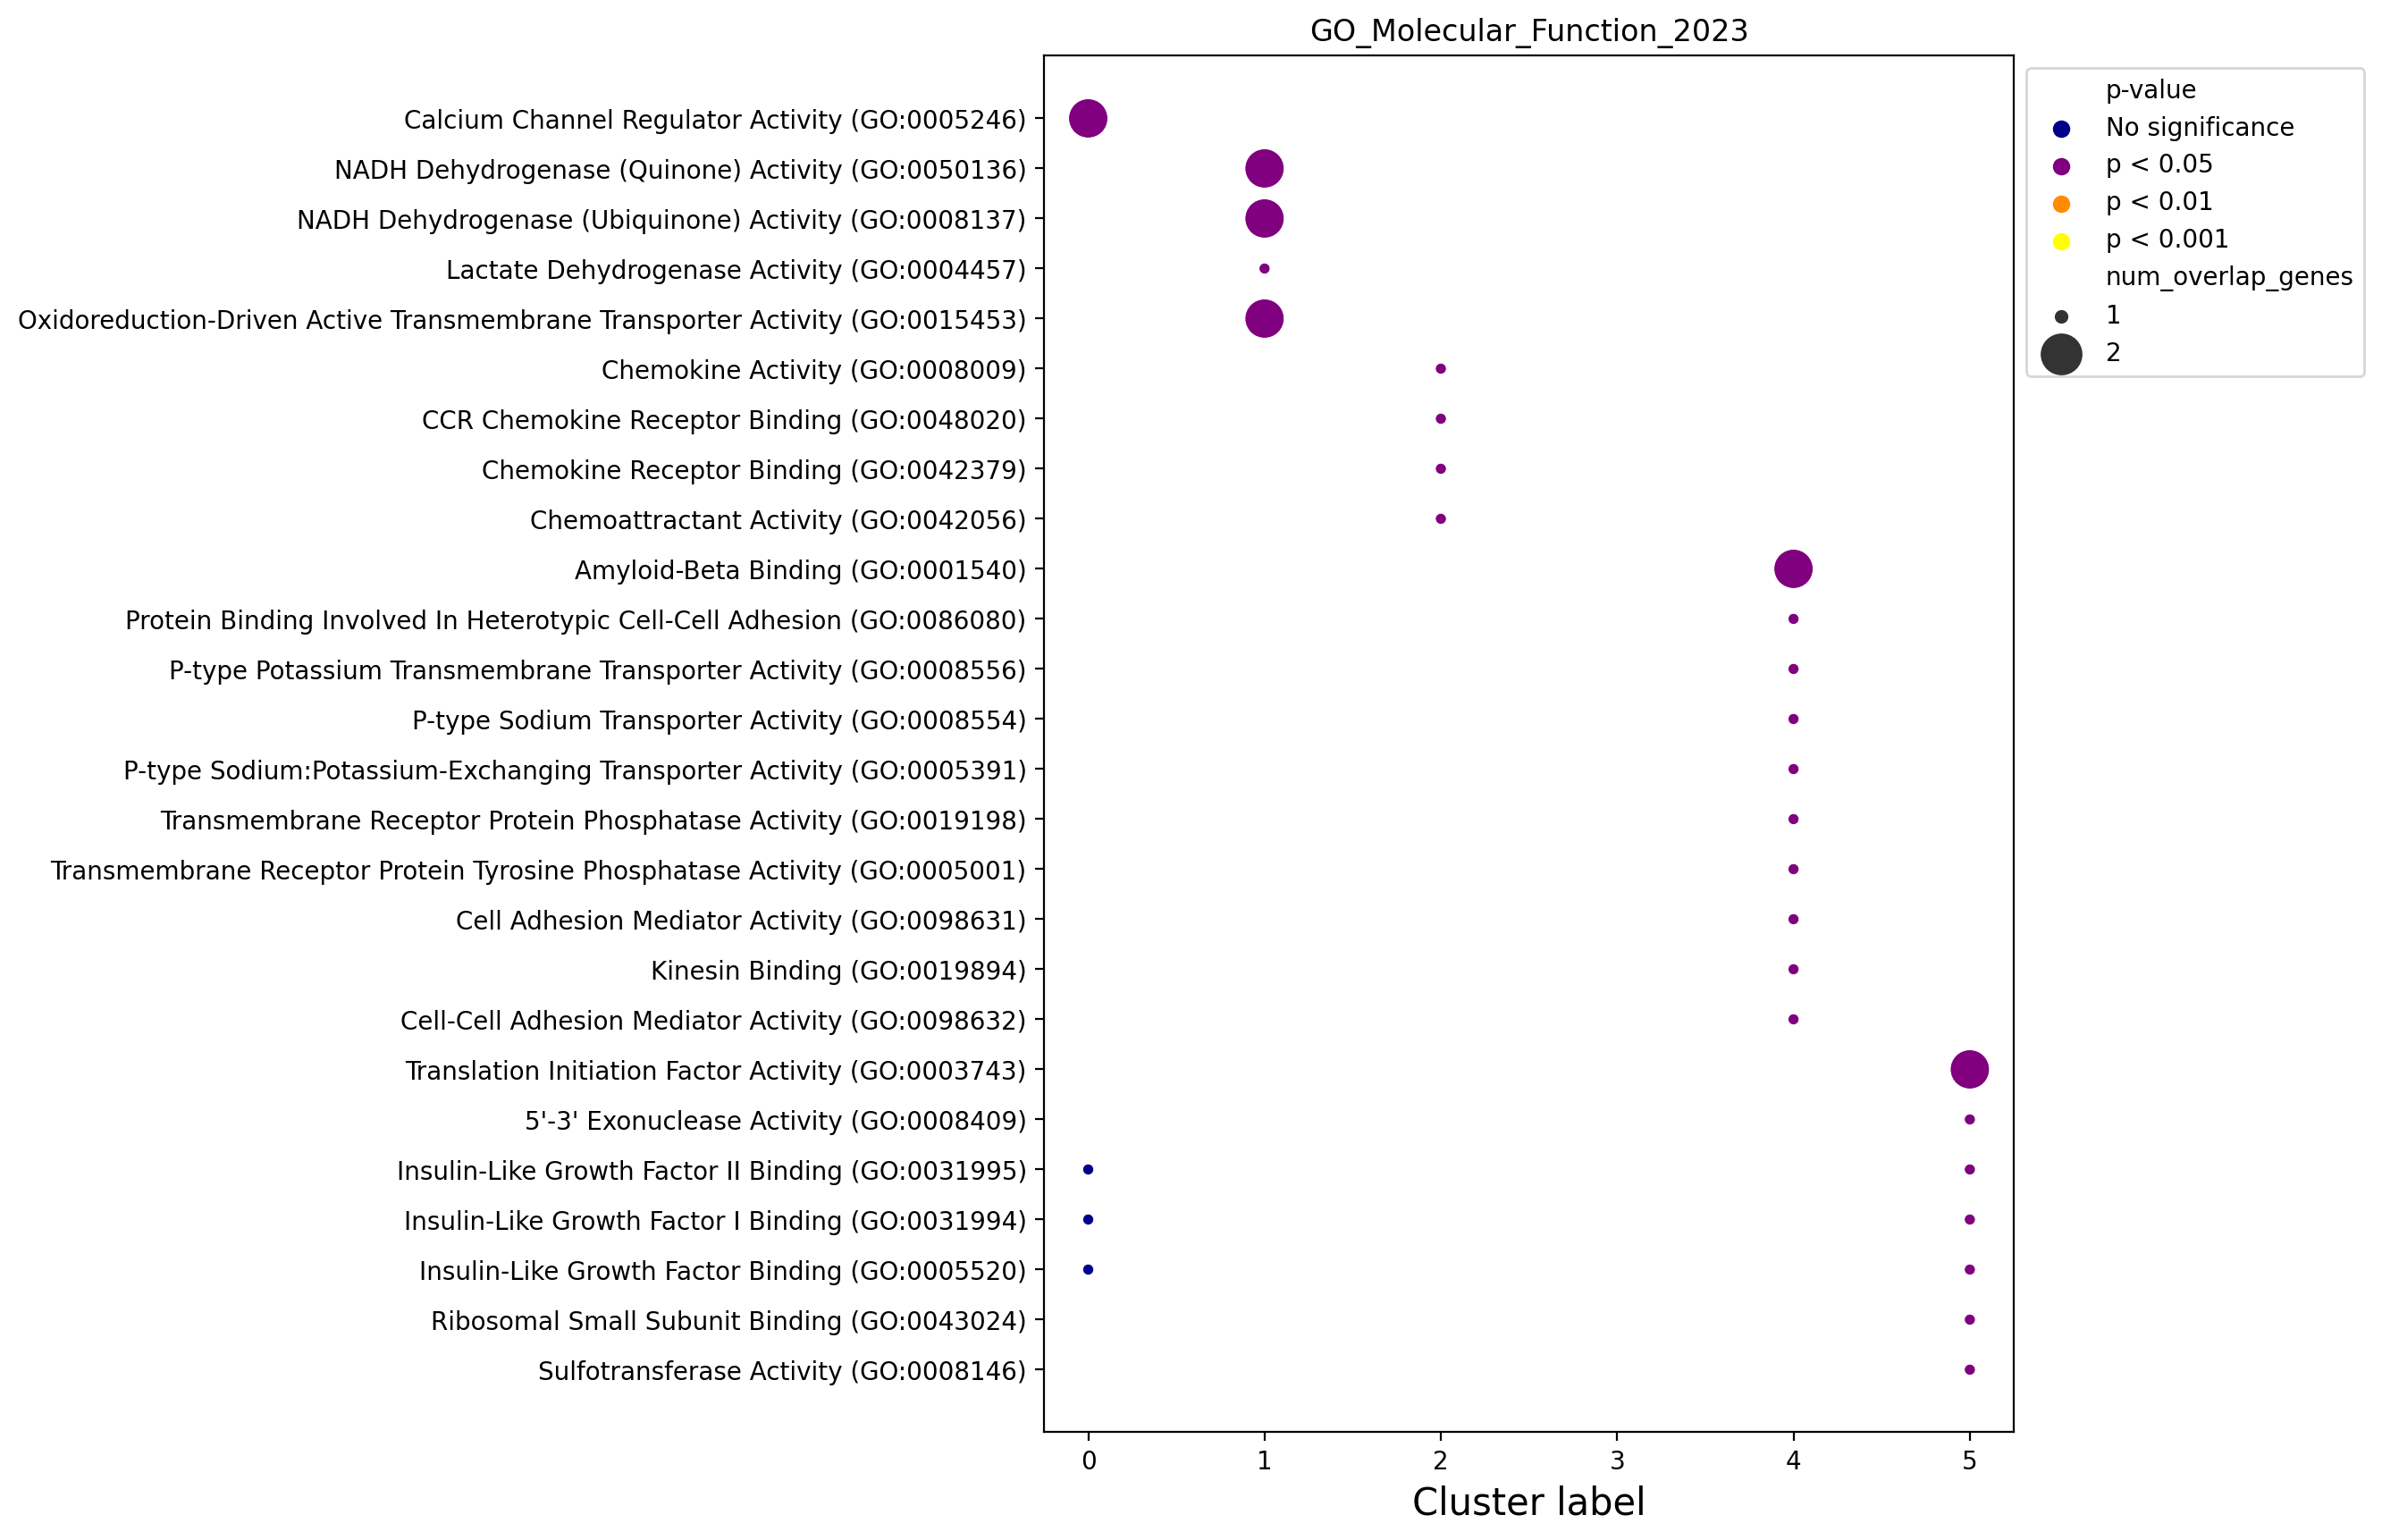

In [56]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## GO_Cellular_Component_2023

In [57]:
db_name = 'GO_Cellular_Component_2023'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [58]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                            
Voltage-Gated Sodium Channel Complex (GO:0001518)     1  0.010230  129.500000   
COPI Vesicle Coat (GO:0030126)                        2  0.018343   64.716667   
Sodium Channel Complex (GO:0034706)                   3  0.020362   57.518519   
COPI-coated Vesicle Membrane (GO:0030663)             4  0.024387   47.048485   
Autophagosome Membrane (GO:0000421)                   5  0.036371   30.419608   

                                                   Combined score  \
Term                                                                
Voltage-Gated Sodium Channel Complex (GO:0001518)      593.424913   
COPI Vesicle Coat (GO:0030126)                         258.769025   
Sodium Channel Complex (GO:0034706)                    223.982396   
COPI-coated Vesicle Membrane (GO:0030663)              174.723587   
Autophagosome Membrane (GO:0000421)                    100.810199   

                                                  Overlapping genes  \
Term                                                                  
Voltage-Gated Sodium Channel Complex (GO:0001518)           [SCN3B]   
COPI Vesicle Coat (GO:0030126)                              [TMED3]   
Sodium Channel Complex (GO:0034706)                         [SCN3B]   
COPI-coated Vesicle Membrane (GO:0030663)                   [TMED3]   
Autophagosome Membrane (GO:0000421)                      [MAP1LC3B]   

                                                   Adjusted P-value  \
Term                                                                  
Voltage-Gated Sodium Channel Complex (GO:0001518)          0.225583   
COPI Vesicle Coat (GO:0030126)                             0.225583   
Sodium Channel Complex (GO:0034706)                        0.225583   
COPI-coated Vesicle Membrane (GO:0030663)                  0.225583   
Autophagosome Membrane (GO:0000421)                        0.236053   

                                                   Old p-value  \
Term                                                             
Voltage-Gated Sodium Channel Complex (GO:0001518)            0   
COPI Vesicle Coat (GO:0030126)                               0   
Sodium Channel Complex (GO:0034706)                          0   
COPI-coated Vesicle Membrane (GO:0030663)                    0   
Autophagosome Membrane (GO:0000421)                          0   

                                                   Old adjusted p-value  \
Term                                                                      
Voltage-Gated Sodium Channel Complex (GO:0001518)                     0   
COPI Vesicle Coat (GO:0030126)                                        0   
Sodium Channel Complex (GO:0034706)                                   0   
COPI-coated Vesicle Membrane (GO:0030663)                             0   
Autophagosome Membrane (GO:0000421)                                   0   

                                                   num_overlap_genes  \
Term                                                                   
Voltage-Gated Sodium Channel Complex (GO:0001518)                  1   
COPI Vesicle Coat (GO:0030126)                                     1   
Sodium Channel Complex (GO:0034706)                                1   
COPI-coated Vesicle Membrane (GO:0030663)                          1   
Autophagosome Membrane (GO:0000421)                                1   

                                                   neg_log10(p_adj)  \
Term                                                                  
Voltage-Gated Sodium Channel Complex (GO:0001518)          0.646694   
COPI Vesicle Coat (GO:0030126)                             0.646694   
Sodium Channel Complex (GO:0034706)                        0.646694   
COPI-coated Vesicle Membrane (GO:0030663)                  0.646694   
Autophagosome Membrane (GO:0000421)                        0.626991   

           

In [59]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

18

In [60]:
enrich_res[enrich_res.cluster_label == 5]

Rank     p-val    Z-score  \
Term                                                                            
Cortical Actin Cytoskeleton (GO:0030864)               1  0.033393  33.721739   
Actin Filament (GO:0005884)                            2  0.052401  20.924324   
Cortical Cytoskeleton (GO:0030863)                     3  0.052401  20.924324   
Cytoplasmic Vesicle Lumen (GO:0060205)                 4  0.090699  11.686364   
Ficolin-1-Rich Granule Lumen (GO:1904813)              5  0.108679   9.623750   
Intracellular Organelle Lumen (GO:0070013)             6  0.113783   3.953301   
Ficolin-1-Rich Granule (GO:0101002)                    7  0.138751   7.379808   
Polymeric Cytoskeletal Fiber (GO:0099513)              8  0.180955   5.496403   
Secretory Granule Lumen (GO:0034774)                   9  0.194986   5.051656   
Actin Cytoskeleton (GO:0015629)                       10  0.214490   4.530357   
Mitochondrial Matrix (GO:0005759)                     11  0.259774   3.622010   
Golgi Membrane (GO:0000139)                           12  0.295512   3.101235   
Nucleus (GO:0005634)                                  13  0.413852   1.370530   
Bounding Membrane Of Organelle (GO:0098588)           14  0.463939   1.717523   
Intracellular Membrane-Bounded Organelle (GO:00...    15  0.542632   1.116173   

                                                    Combined score  \
Term                                                                 
Cortical Actin Cytoskeleton (GO:0030864)                114.633717   
Actin Filament (GO:0005884)                              61.702131   
Cortical Cytoskeleton (GO:0030863)                       61.702131   
Cytoplasmic Vesicle Lumen (GO:0060205)                   28.049769   
Ficolin-1-Rich Granule Lumen (GO:1904813)                21.358578   
Intracellular Organelle Lumen (GO:0070013)                8.592348   
Ficolin-1-Rich Granule (GO:0101002)                      14.575677   
Polymeric Cytoskeletal Fiber (GO:0099513)                 9.396141   
Secretory Granule Lumen (GO:0034774)                      8.258580   
Actin Cytoskeleton (GO:0015629)                           6.974450   
Mitochondrial Matrix (GO:0005759)                         4.882267   
Golgi Membrane (GO:0000139)                               3.780551   
Nucleus (GO:0005634)                                      1.209146   
Bounding Membrane Of Organelle (GO:0098588)               1.319063   
Intracellular Membrane-Bounded Organelle (GO:00...        0.682344   

                                                             Overlapping genes  \
Term                                                                             
Cortical Actin Cytoskeleton (GO:0030864)                               [COTL1]   
Actin Filament (GO:0005884)                                            [COTL1]   
Cortical Cytoskeleton (GO:0030863)                                     [COTL1]   
Cytoplasmic Vesicle Lumen (GO:0060205)                                 [COTL1]   
Ficolin-1-Rich Granule Lumen (GO:1904813)                              [COTL1]   
Intracellular Organelle Lumen (GO:0070013)                       [COTL1, ETFB]   
Ficolin-1-Rich Granule (GO:0101002)                                    [COTL1]   
Polymeric Cytoskeletal Fiber (GO:0099513)                              [COTL1]   
Secretory Granule Lumen (GO:0034774)                                   [COTL1]   
Actin Cytoskeleton (GO:0015629)                                        [COTL1]   
Mitochondrial Matrix (GO:0005759)                                       [ETFB]   
Golgi Membrane (GO:0000139)                                           [CHST10]   
Nucleus (GO:0005634)                                [EEF1G, ZNF706, LHX2, MAZ]   
Bounding Membrane Of Organelle (GO:0098588)                           [CHST10]   
Intracellular Membrane-Bounded Organelle (GO:00...  [EEF1G, ZNF706, LHX2, MAZ]   

                                                    Adjusted P-value  \
Term            

In [61]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

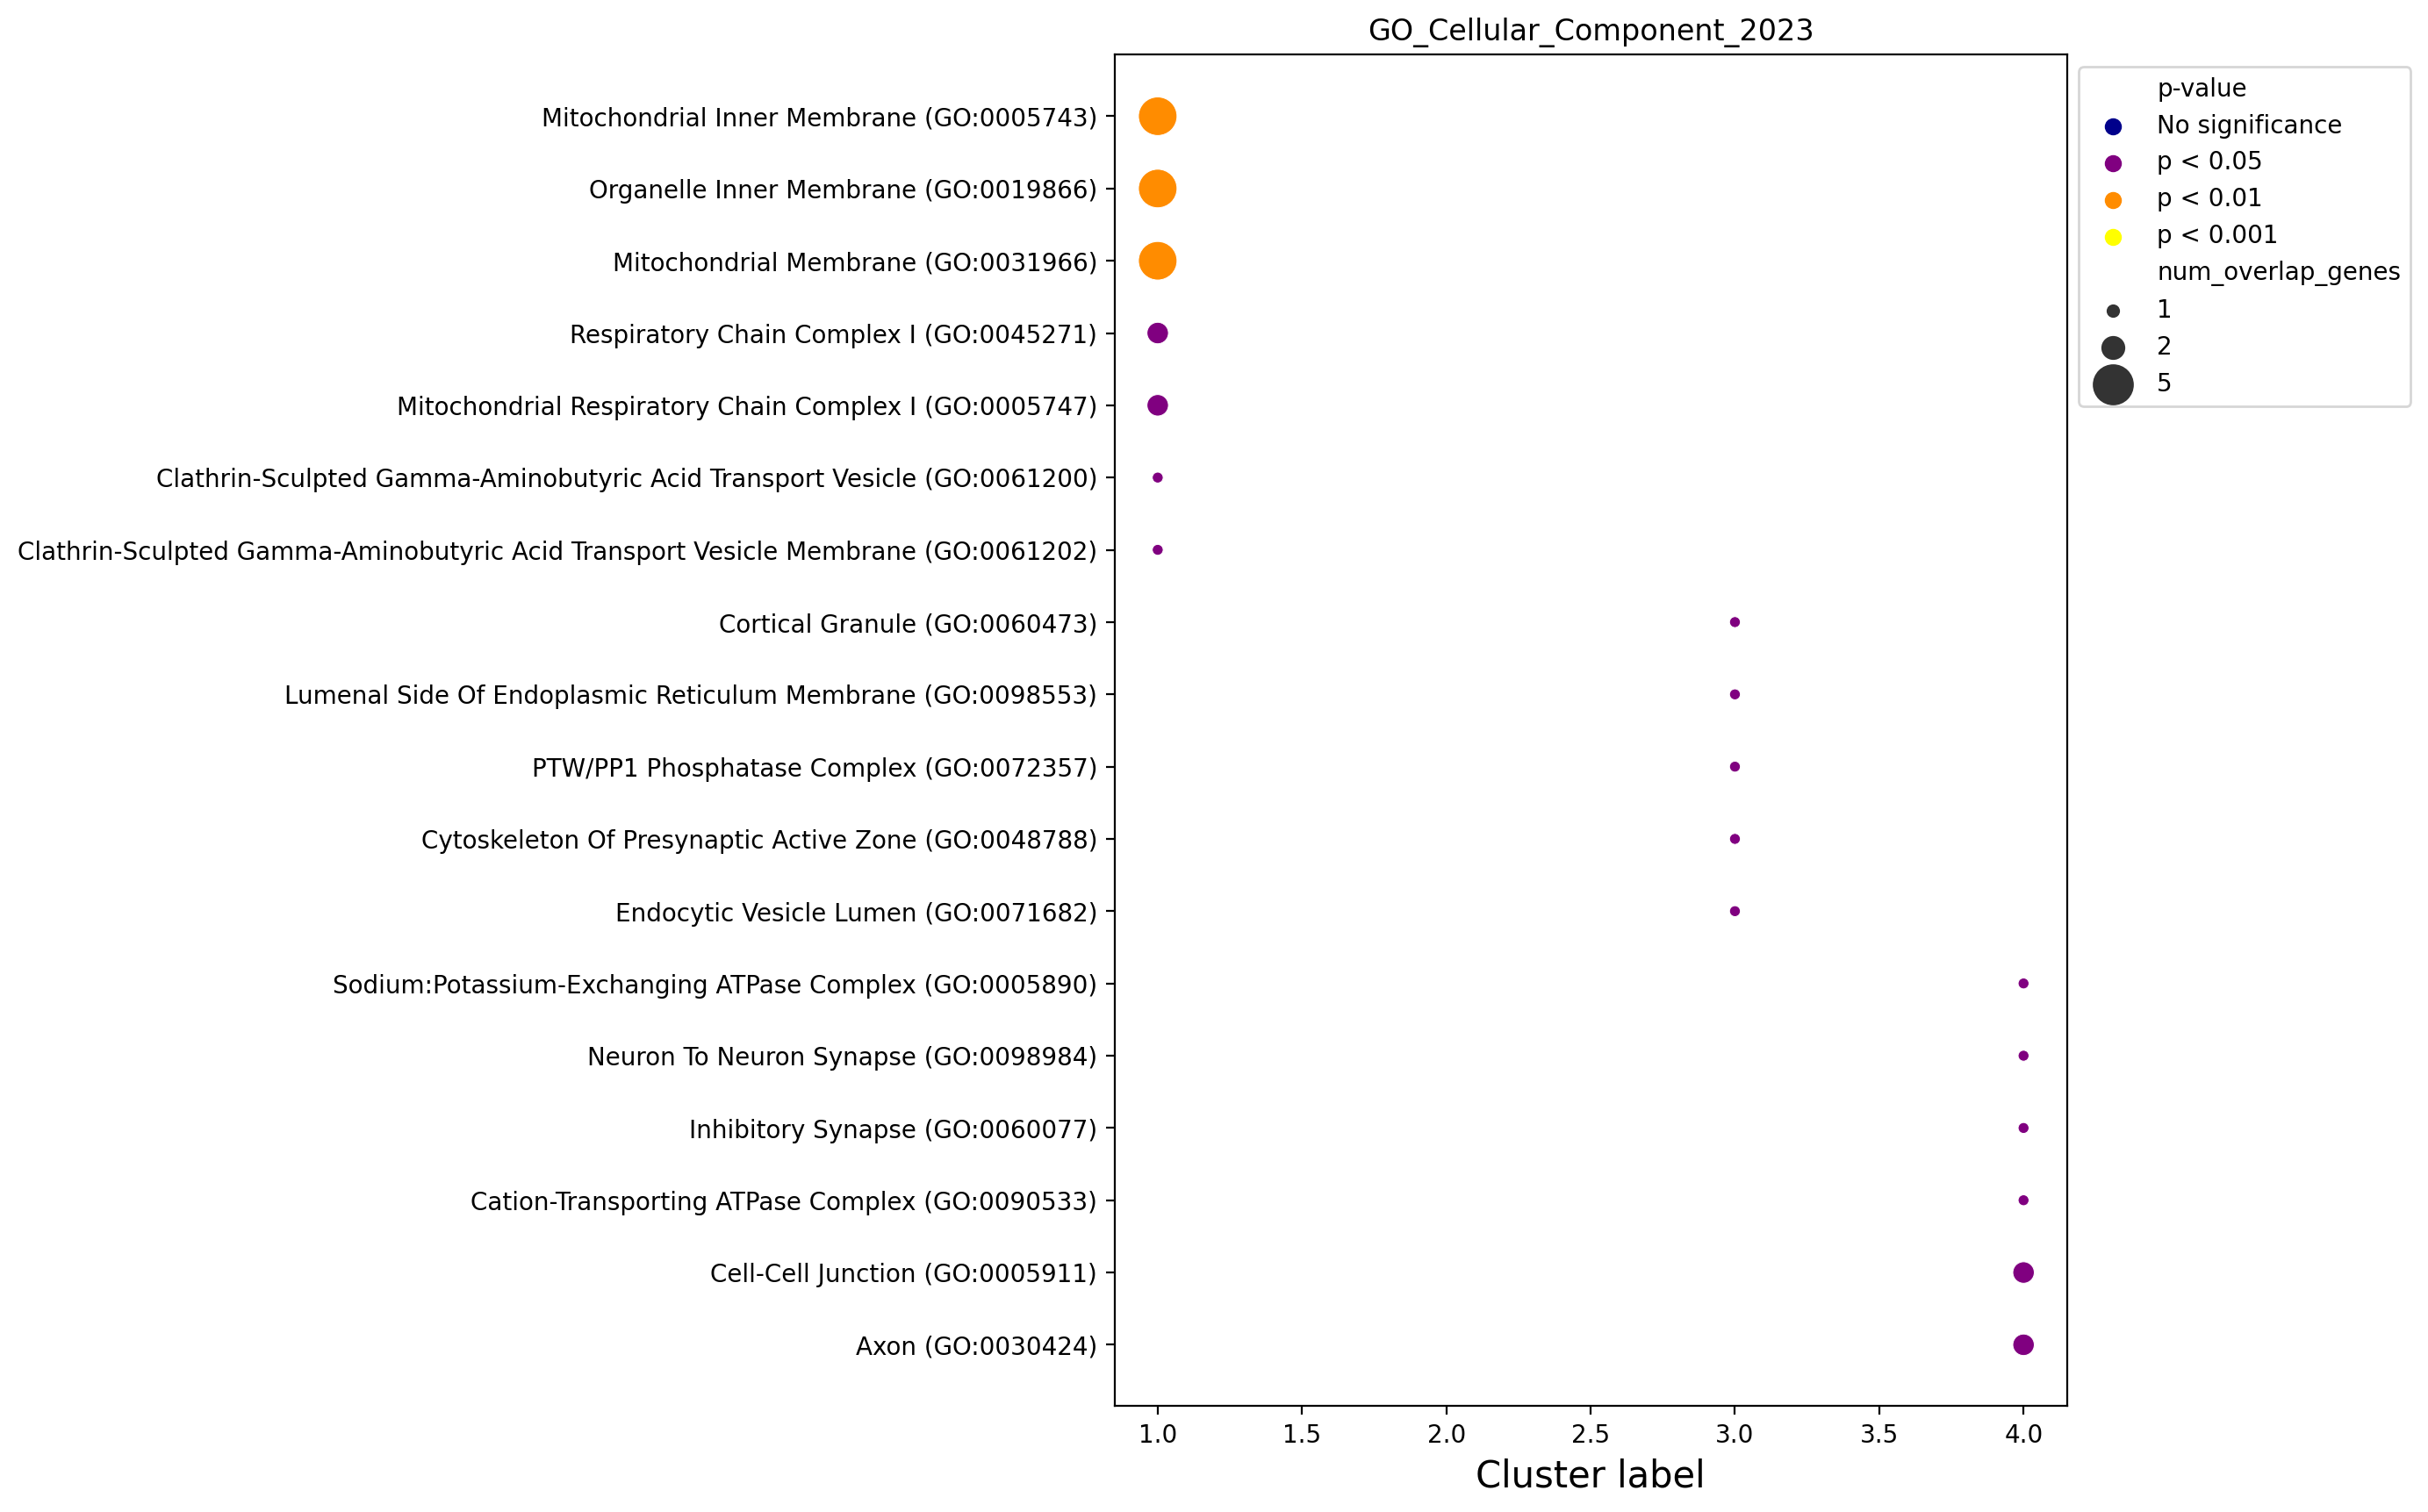

In [62]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## WikiPathway_2023_Human

In [63]:
db_name = 'WikiPathway_2023_Human'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [64]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Disruption Of Postsynaptic Signaling By CNV WP4875     1  0.000023   
Lipid Particles Composition WP3601                     2  0.004104   
Familial Hyperlipidemia Type 2 WP5109                  3  0.006150   
Metabolic Pathway Of LDL HDL And TG Including D...     4  0.008192   
Biosynthesis And Turnover Of 1 Deoxy Sphingoid ...     5  0.010230   

                                                       Z-score  \
Term                                                             
Disruption Of Postsynaptic Signaling By CNV WP4875   71.529231   
Lipid Particles Composition WP3601                  518.200000   
Familial Hyperlipidemia Type 2 WP5109               259.066667   
Metabolic Pathway Of LDL HDL And TG Including D...  172.688889   
Biosynthesis And Turnover Of 1 Deoxy Sphingoid ...  129.500000   

                                                    Combined score  \
Term                                                                 
Disruption Of Postsynaptic Signaling By CNV WP4875      765.270690   
Lipid Particles Composition WP3601                     2847.943283   
Familial Hyperlipidemia Type 2 WP5109                  1318.994950   
Metabolic Pathway Of LDL HDL And TG Including D...      829.703384   
Biosynthesis And Turnover Of 1 Deoxy Sphingoid ...      593.424913   

                                                          Overlapping genes  \
Term                                                                          
Disruption Of Postsynaptic Signaling By CNV WP4875  [SYNGAP1, NRXN1, NRXN2]   
Lipid Particles Composition WP3601                                    [LPL]   
Familial Hyperlipidemia Type 2 WP5109                                 [LPL]   
Metabolic Pathway Of LDL HDL And TG Including D...                    [LPL]   
Biosynthesis And Turnover Of 1 Deoxy Sphingoid ...                  [ASAH1]   

                                                    Adjusted P-value  \
Term                                                                   
Disruption Of Postsynaptic Signaling By CNV WP4875          0.001196   
Lipid Particles Composition WP3601                          0.057747   
Familial Hyperlipidemia Type 2 WP5109                       0.057747   
Metabolic Pathway Of LDL HDL And TG Including D...          0.057747   
Biosynthesis And Turnover Of 1 Deoxy Sphingoid ...          0.057747   

                                                    Old p-value  \
Term                                                              
Disruption Of Postsynaptic Signaling By CNV WP4875            0   
Lipid Particles Composition WP3601                            0   
Familial Hyperlipidemia Type 2 WP5109                         0   
Metabolic Pathway Of LDL HDL And TG Including D...            0   
Biosynthesis And Turnover Of 1 Deoxy Sphingoid ...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Disruption Of Postsynaptic Signaling By CNV WP4875                     0   
Lipid Particles Composition WP3601                                     0   
Familial Hyperlipidemia Type 2 WP5109                                  0   
Metabolic Pathway Of LDL HDL And TG Including D...                     0   
Biosynthesis And Turnover Of 1 Deoxy Sphingoid ...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Disruption Of Postsynaptic Signaling By CNV WP4875                  3   
Lipid Particles Composition WP3601                                  1   
Familial Hyperlipidemia Type 2 WP5109                               1   
Metabolic Pathway Of LDL HDL And TG Including D...                  1   
Biosynthesis And Turnover Of 1 Deoxy Sphingoid ...                  1   

                                 

In [65]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 20)].index.unique()
terms.size

40

In [66]:
enrich_res[enrich_res.cluster_label == 5]

Rank     p-val    Z-score  \
Term                                                                            
Hair Follicle Development Cytodifferentiation P...     1  0.045652  24.209375   
Neural Crest Differentiation WP2064                    2  0.052401  20.924324   
Translation Factors WP107                              3  0.057769  18.873171   
16P11 2 Proximal Deletion Syndrome WP4949              4  0.063110  17.186667   
Metapathway Biotransformation Phase I And II WP702     5  0.067097  16.106250   
Sudden Infant Death Syndrome SIDS Susceptibilit...     6  0.099729  10.556164   
Myometrial Relaxation And Contraction Pathways ...     7  0.115021   9.051765   

                                                    Combined score  \
Term                                                                 
Hair Follicle Development Cytodifferentiation P...       74.727211   
Neural Crest Differentiation WP2064                      61.702131   
Translation Factors WP107                                53.812979   
16P11 2 Proximal Deletion Syndrome WP4949                47.484654   
Metapathway Biotransformation Phase I And II WP702       43.512859   
Sudden Infant Death Syndrome SIDS Susceptibilit...       24.335076   
Myometrial Relaxation And Contraction Pathways ...       19.575701   

                                                   Overlapping genes  \
Term                                                                   
Hair Follicle Development Cytodifferentiation P...            [LHX2]   
Neural Crest Differentiation WP2064                           [LHX2]   
Translation Factors WP107                                    [EEF1G]   
16P11 2 Proximal Deletion Syndrome WP4949                      [MAZ]   
Metapathway Biotransformation Phase I And II WP702          [CHST10]   
Sudden Infant Death Syndrome SIDS Susceptibilit...             [MAZ]   
Myometrial Relaxation And Contraction Pathways ...          [IGFBP6]   

                                                    Adjusted P-value  \
Term                                                                   
Hair Follicle Development Cytodifferentiation P...          0.093936   
Neural Crest Differentiation WP2064                         0.093936   
Translation Factors WP107                                   0.093936   
16P11 2 Proximal Deletion Syndrome WP4949                   0.093936   
Metapathway Biotransformation Phase I And II WP702          0.093936   
Sudden Infant Death Syndrome SIDS Susceptibilit...          0.115021   
Myometrial Relaxation And Contraction Pathways ...          0.115021   

                                                    Old p-value  \
Term                                                              
Hair Follicle Development Cytodifferentiation P...            0   
Neural Crest Differentiation WP2064                           0   
Translation Factors WP107                                     0   
16P11 2 Proximal Deletion Syndrome WP4949                     0   
Metapathway Biotransformation Phase I And II WP702            0   
Sudden Infant Death Syndrome SIDS Susceptibilit...            0   
Myometrial Relaxation And Contraction Pathways ...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Hair Follicle Development Cytodifferentiation P...                     0   
Neural Crest Differentiation WP2064                                    0   
Translation Factors WP107                                              0   
16P11 2 Proximal Deletion Syndrome WP4949                              0   
Metapathway Biotransformation Phase I And II WP702                     0   
Sudden Infant Death Syndrome SIDS Susceptibilit...                     0   
Myometrial Relaxation And Contraction Pathways ...                     0   

                                                    num_overlap_genes  \
Term                           

In [67]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

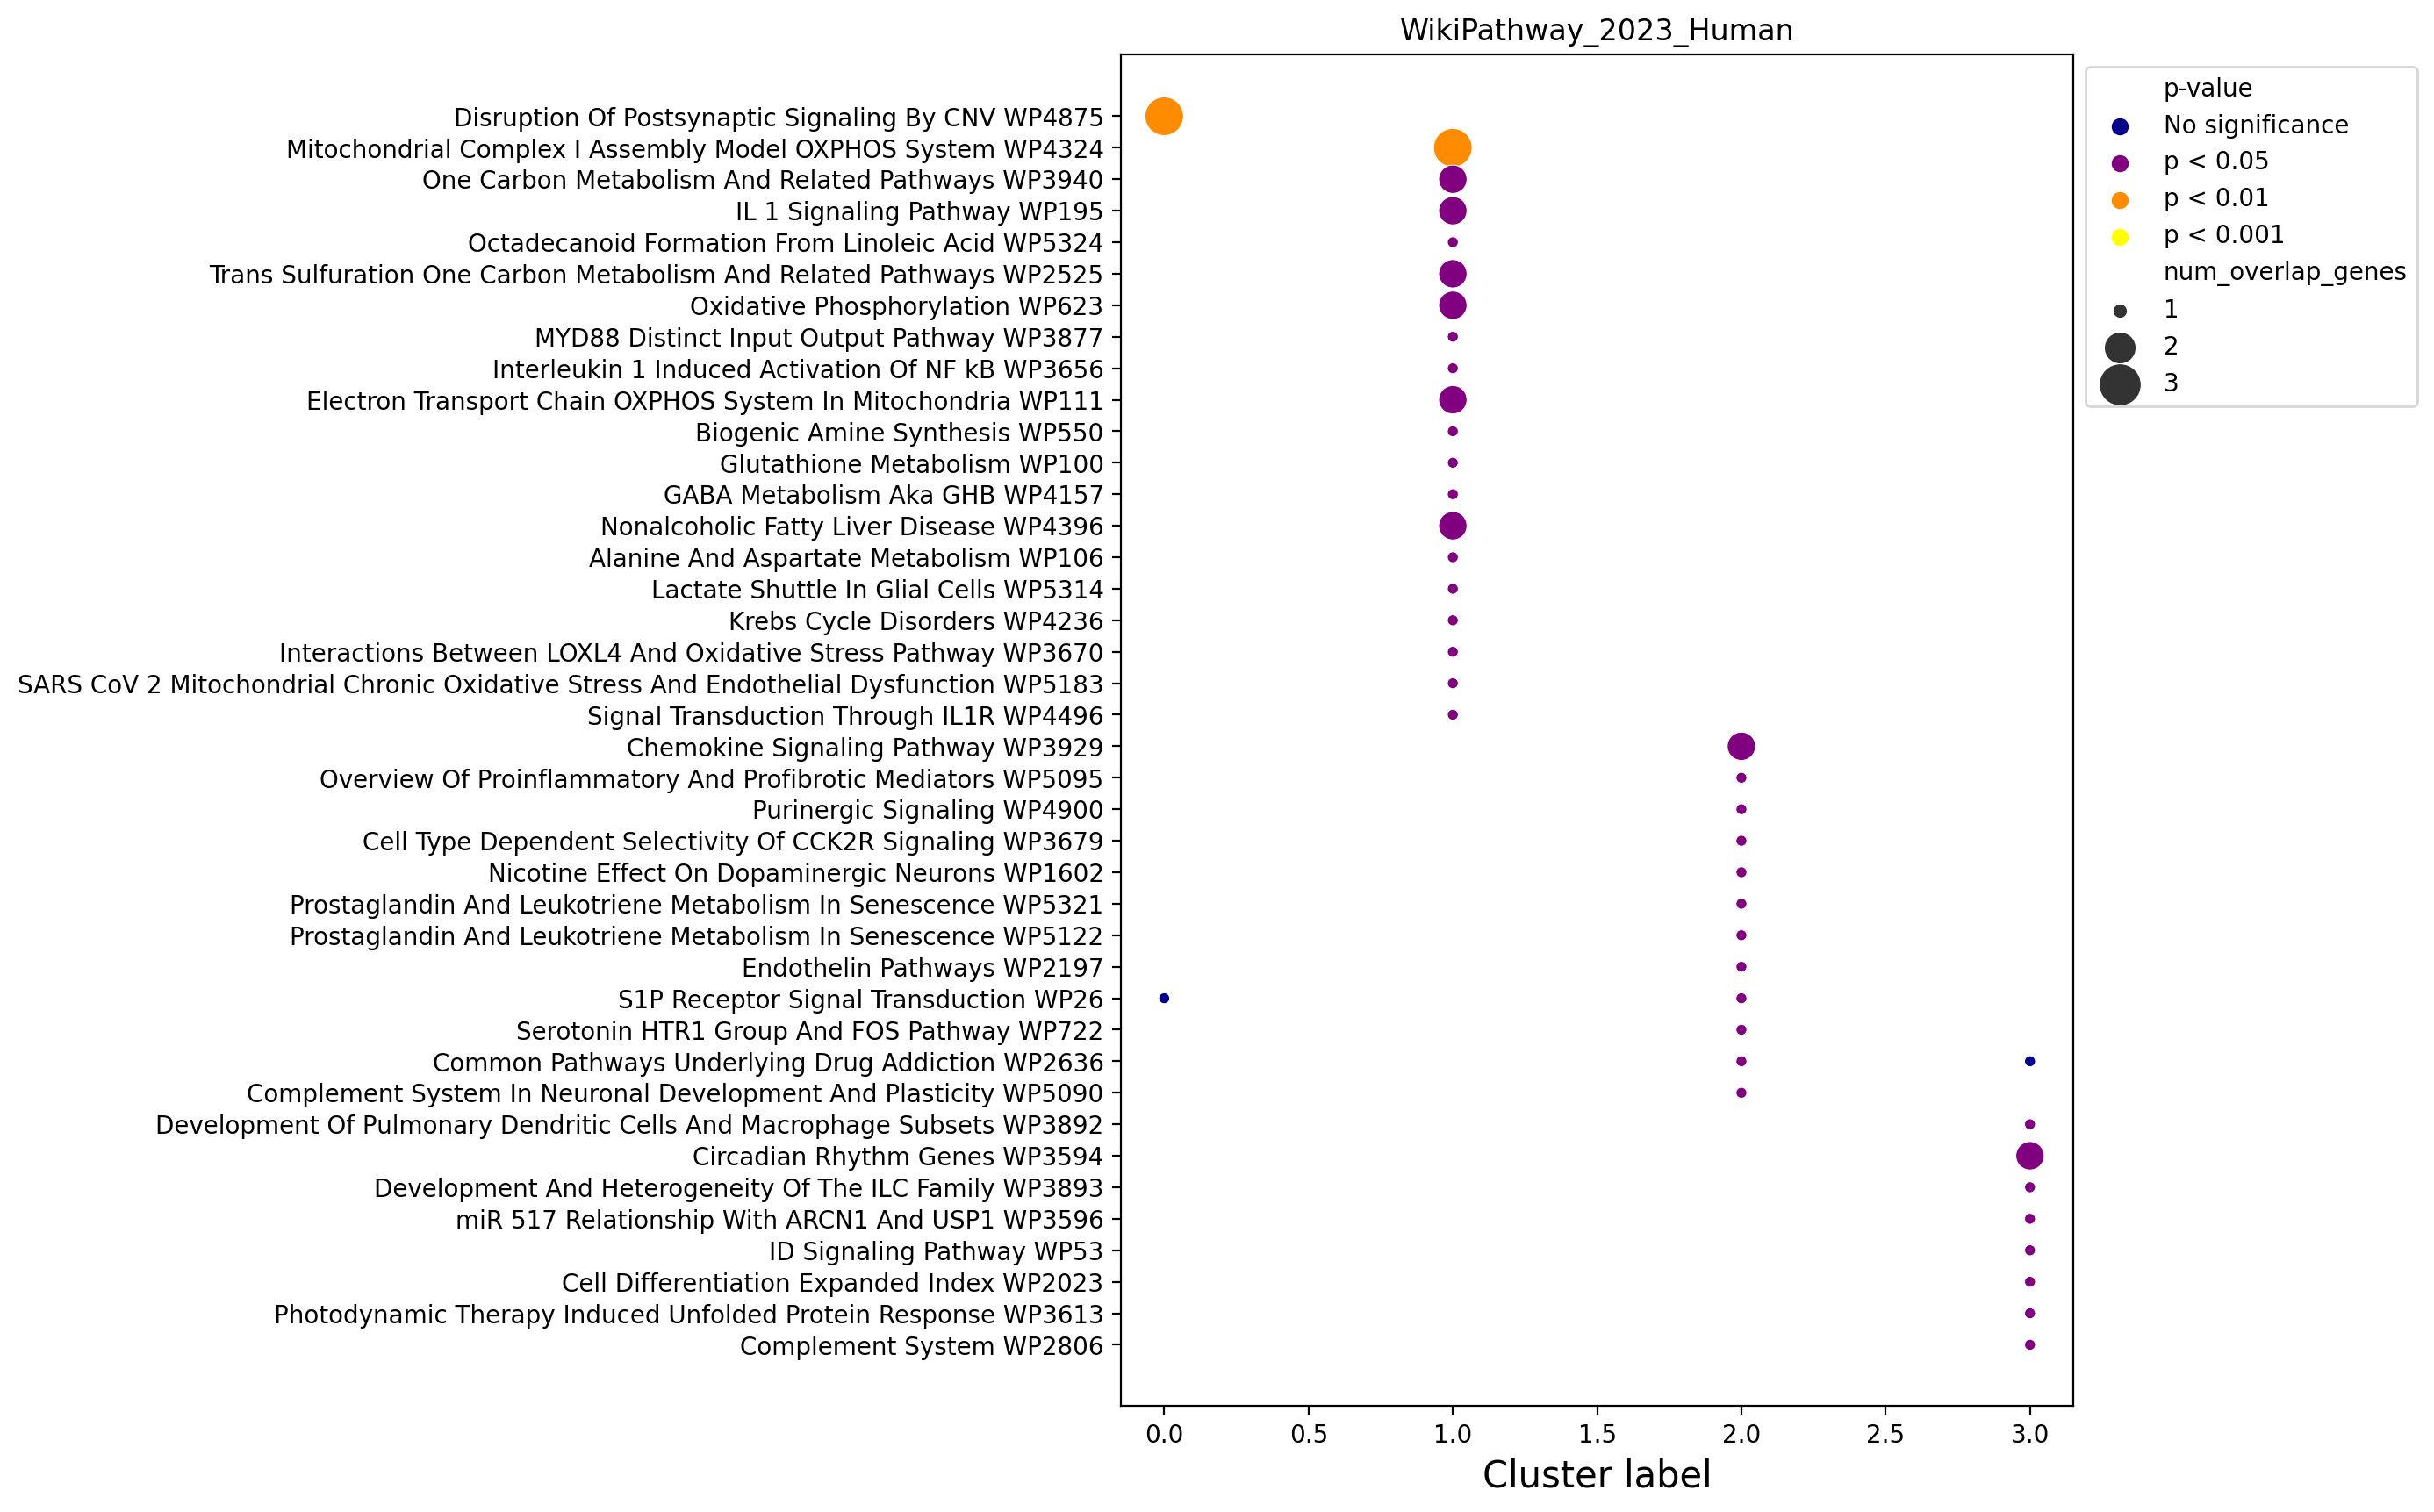

In [68]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [69]:
db_name = 'Azimuth_Cell_Types_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [70]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  Combined score  \
Term                                                                            
Vip+ GABAergic Neuron 2 CL0000617     1  0.012264  103.586667      455.892368   
Delta Islet Cell CL0000173            2  0.014294   86.311111      366.639488   
Double-negative T 1 CL0000935         1  0.004104  518.200000     2847.943283   
CD8+ Central Memory T CL0000909       2  0.004104  518.200000     2847.943283   
Naive Regulatory T CL0000815          3  0.004104  518.200000     2847.943283   

                                  Overlapping genes  Adjusted P-value  \
Term                                                                    
Vip+ GABAergic Neuron 2 CL0000617           [NRXN1]          0.014294   
Delta Islet Cell CL0000173                   [RGS2]          0.014294   
Double-negative T 1 CL0000935                [LDHB]          0.009840   
CD8+ Central Memory T CL0000909              [LDHB]          0.009840   
Naive Regulatory T CL0000815                 [LDHB]          0.009840   

                                   Old p-value  Old adjusted p-value  \
Term                                                                   
Vip+ GABAergic Neuron 2 CL0000617            0                     0   
Delta Islet Cell CL0000173                   0                     0   
Double-negative T 1 CL0000935                0                     0   
CD8+ Central Memory T CL0000909              0                     0   
Naive Regulatory T CL0000815                 0                     0   

                                   num_overlap_genes  neg_log10(p_adj)  \
Term                                                                     
Vip+ GABAergic Neuron 2 CL0000617                  1          1.844832   
Delta Islet Cell CL0000173                         1          1.844832   
Double-negative T 1 CL0000935                      1          2.007018   
CD8+ Central Memory T CL0000909                    1          2.007018   
Naive Regulatory T CL0000815                       1          2.007018   

                                   cluster_label  
Term                                              
Vip+ GABAergic Neuron 2 CL0000617              0  
Delta Islet Cell CL0000173                     0  
Double-negative T 1 CL0000935                  1  
CD8+ Central Memory T CL0000909                1  
Naive Regulatory T CL0000815                   1

In [71]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

29

In [72]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

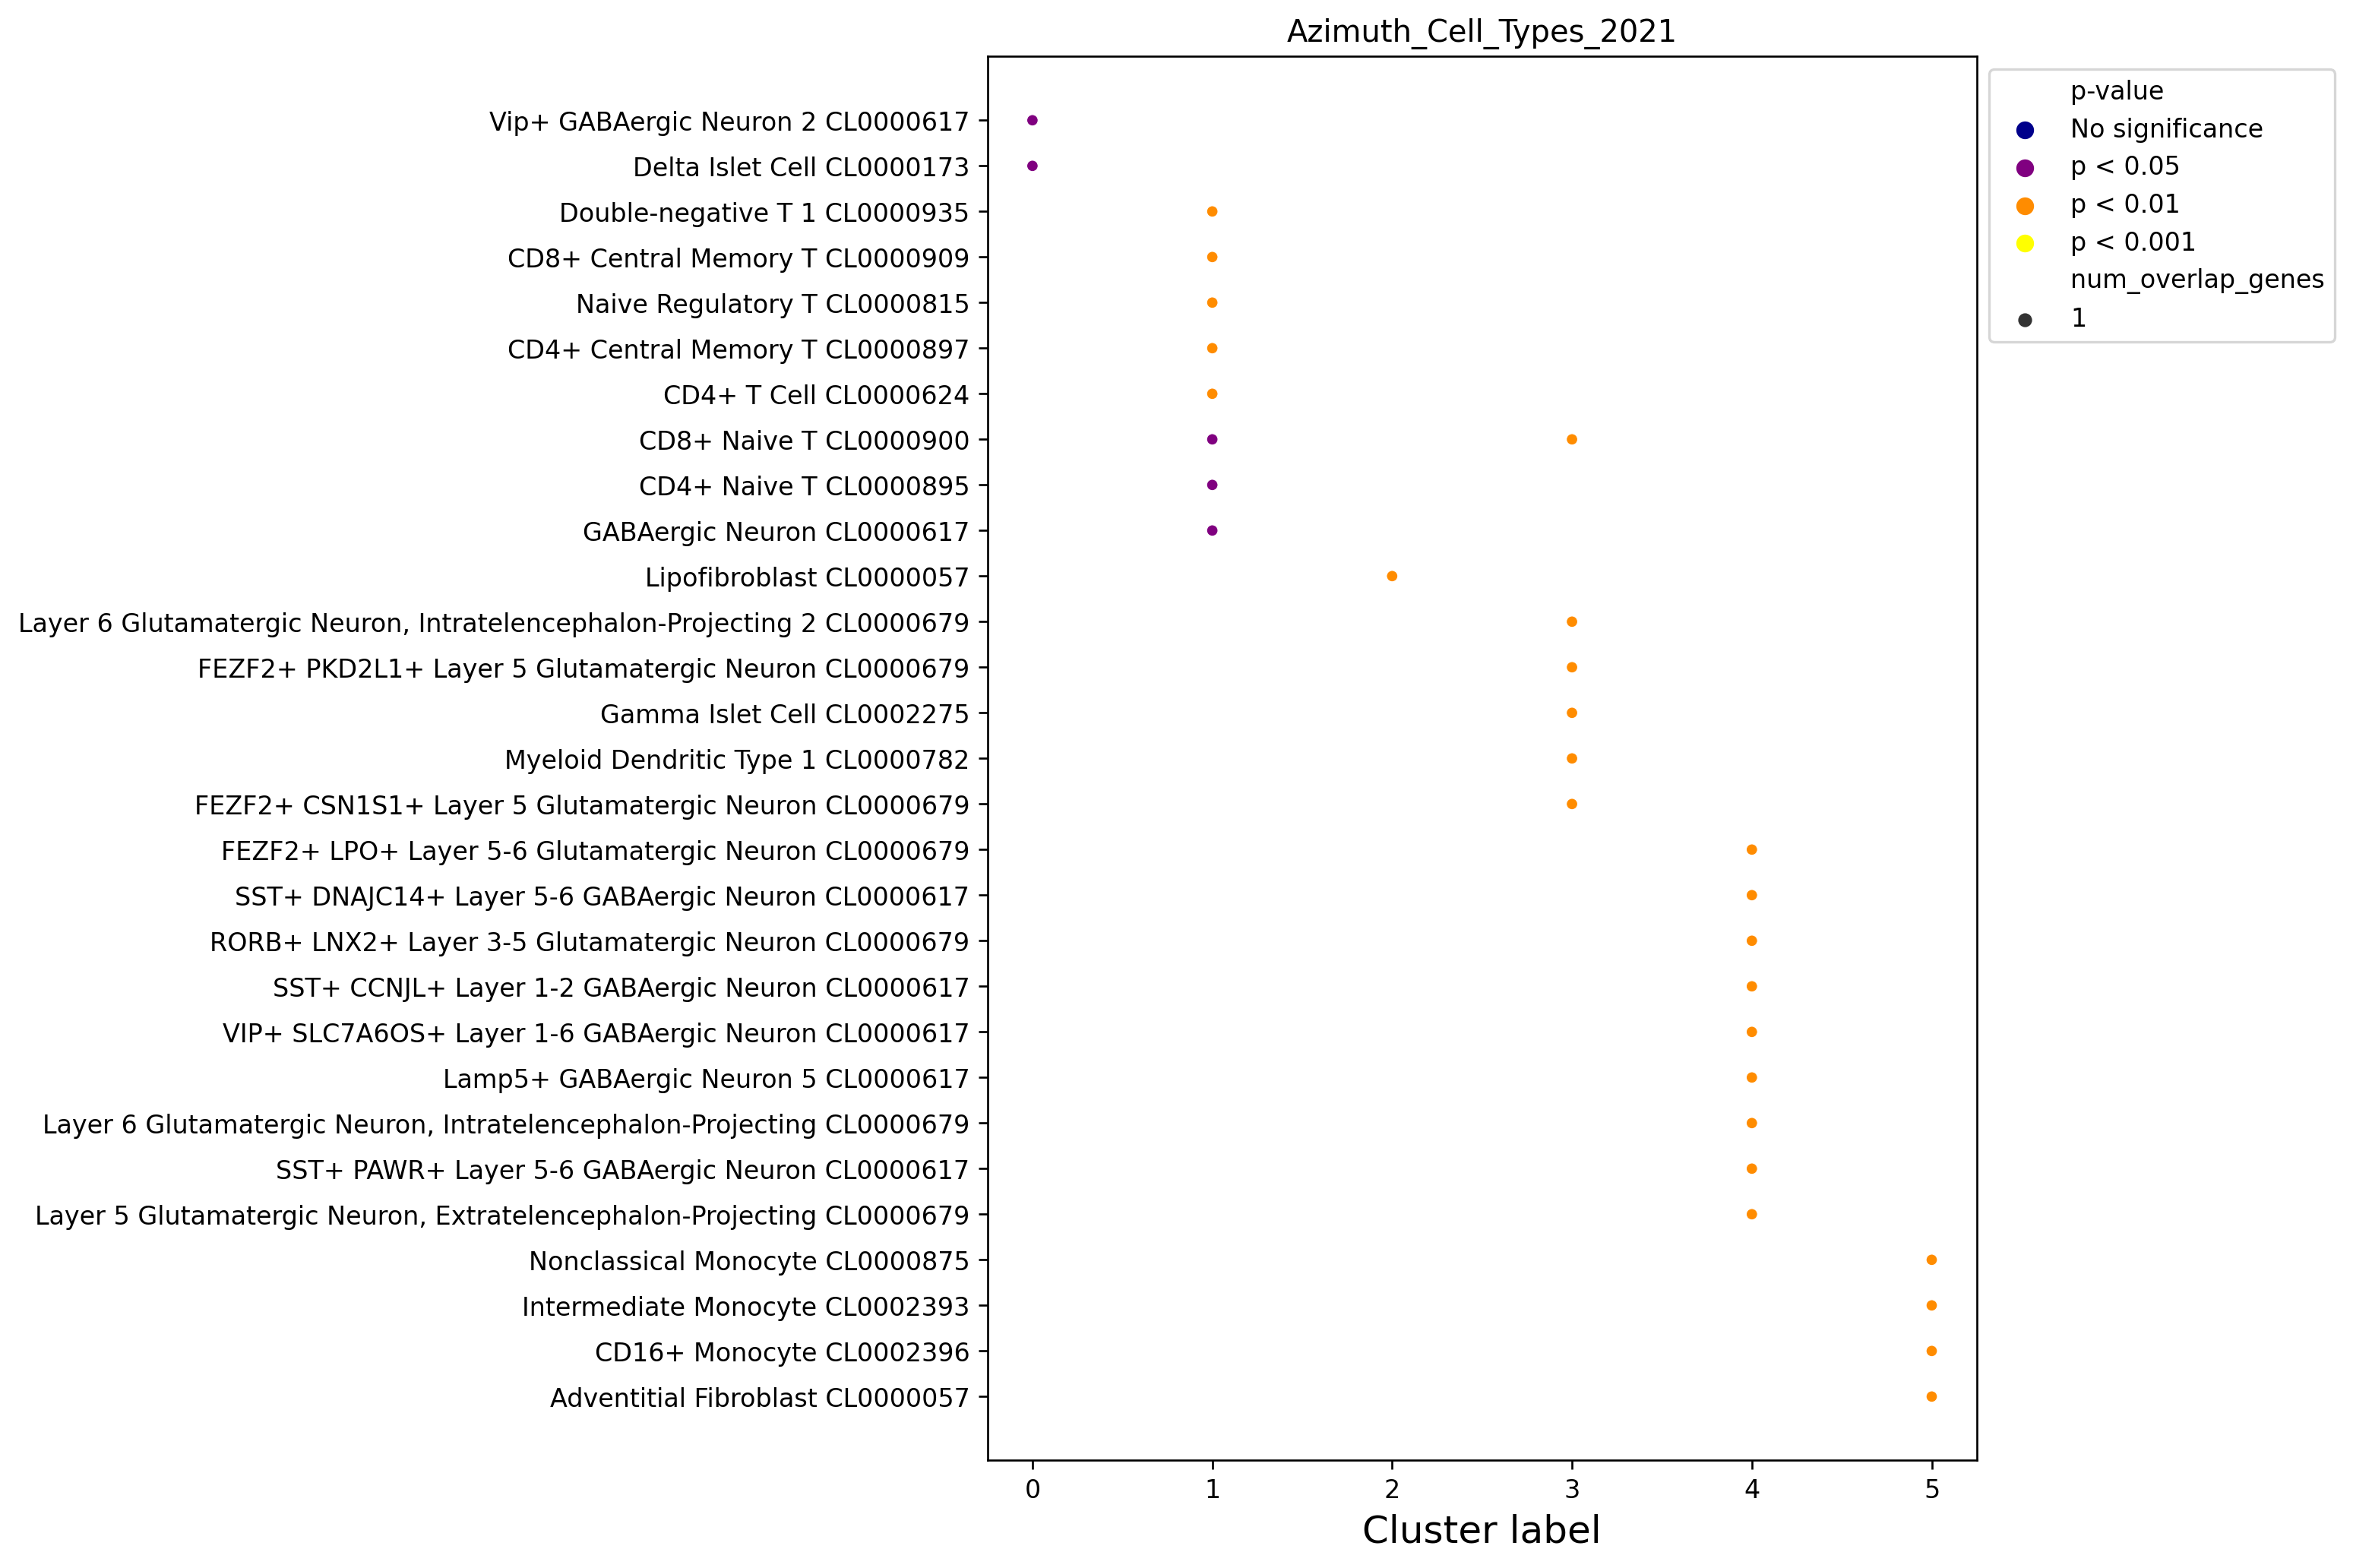

In [73]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth 2023


In [74]:
db_name = 'Azimuth_2023'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [75]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Tonsil-L2-aDC2                                         1  0.002054   
Lung V2 (HLCA)-ann Level 4-Basal Resting               2  0.004104   
Lung V2 (HLCA)-ann Finest level-Basal Resting          3  0.004104   
Fetal Development-L2-Stomach-Parietal And Chief...     4  0.006150   
Fetal Development-L1-Parietal And Chief Cells          5  0.006150   

                                                       Z-score  \
Term                                                             
Tonsil-L2-aDC2                                             inf   
Lung V2 (HLCA)-ann Level 4-Basal Resting            518.200000   
Lung V2 (HLCA)-ann Finest level-Basal Resting       518.200000   
Fetal Development-L2-Stomach-Parietal And Chief...  259.066667   
Fetal Development-L1-Parietal And Chief Cells       259.066667   

                                                    Combined score  \
Term                                                                 
Tonsil-L2-aDC2                                                 inf   
Lung V2 (HLCA)-ann Level 4-Basal Resting               2847.943283   
Lung V2 (HLCA)-ann Finest level-Basal Resting          2847.943283   
Fetal Development-L2-Stomach-Parietal And Chief...     1318.994950   
Fetal Development-L1-Parietal And Chief Cells          1318.994950   

                                                   Overlapping genes  \
Term                                                                   
Tonsil-L2-aDC2                                               [NRXN2]   
Lung V2 (HLCA)-ann Level 4-Basal Resting                    [IGFBP2]   
Lung V2 (HLCA)-ann Finest level-Basal Resting               [IGFBP2]   
Fetal Development-L2-Stomach-Parietal And Chief...          [IGFBP2]   
Fetal Development-L1-Parietal And Chief Cells               [IGFBP2]   

                                                    Adjusted P-value  \
Term                                                                   
Tonsil-L2-aDC2                                              0.017034   
Lung V2 (HLCA)-ann Level 4-Basal Resting                    0.017034   
Lung V2 (HLCA)-ann Finest level-Basal Resting               0.017034   
Fetal Development-L2-Stomach-Parietal And Chief...          0.017034   
Fetal Development-L1-Parietal And Chief Cells               0.017034   

                                                    Old p-value  \
Term                                                              
Tonsil-L2-aDC2                                                0   
Lung V2 (HLCA)-ann Level 4-Basal Resting                      0   
Lung V2 (HLCA)-ann Finest level-Basal Resting                 0   
Fetal Development-L2-Stomach-Parietal And Chief...            0   
Fetal Development-L1-Parietal And Chief Cells                 0   

                                                    Old adjusted p-value  \
Term                                                                       
Tonsil-L2-aDC2                                                         0   
Lung V2 (HLCA)-ann Level 4-Basal Resting                               0   
Lung V2 (HLCA)-ann Finest level-Basal Resting                          0   
Fetal Development-L2-Stomach-Parietal And Chief...                     0   
Fetal Development-L1-Parietal And Chief Cells                          0   

                                                    num_overlap_genes  \
Term                                                                    
Tonsil-L2-aDC2                                                      1   
Lung V2 (HLCA)-ann Level 4-Basal Resting                            1   
Lung V2 (HLCA)-ann Finest level-Basal Resting                       1   
Fetal Development-L2-Stomach-Parietal And Chief...                  1   
Fetal Development-L1-Parietal And Chief Cells                       1   

                                                    neg_log10(p_adj)  \
Term      

In [76]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

46

In [77]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

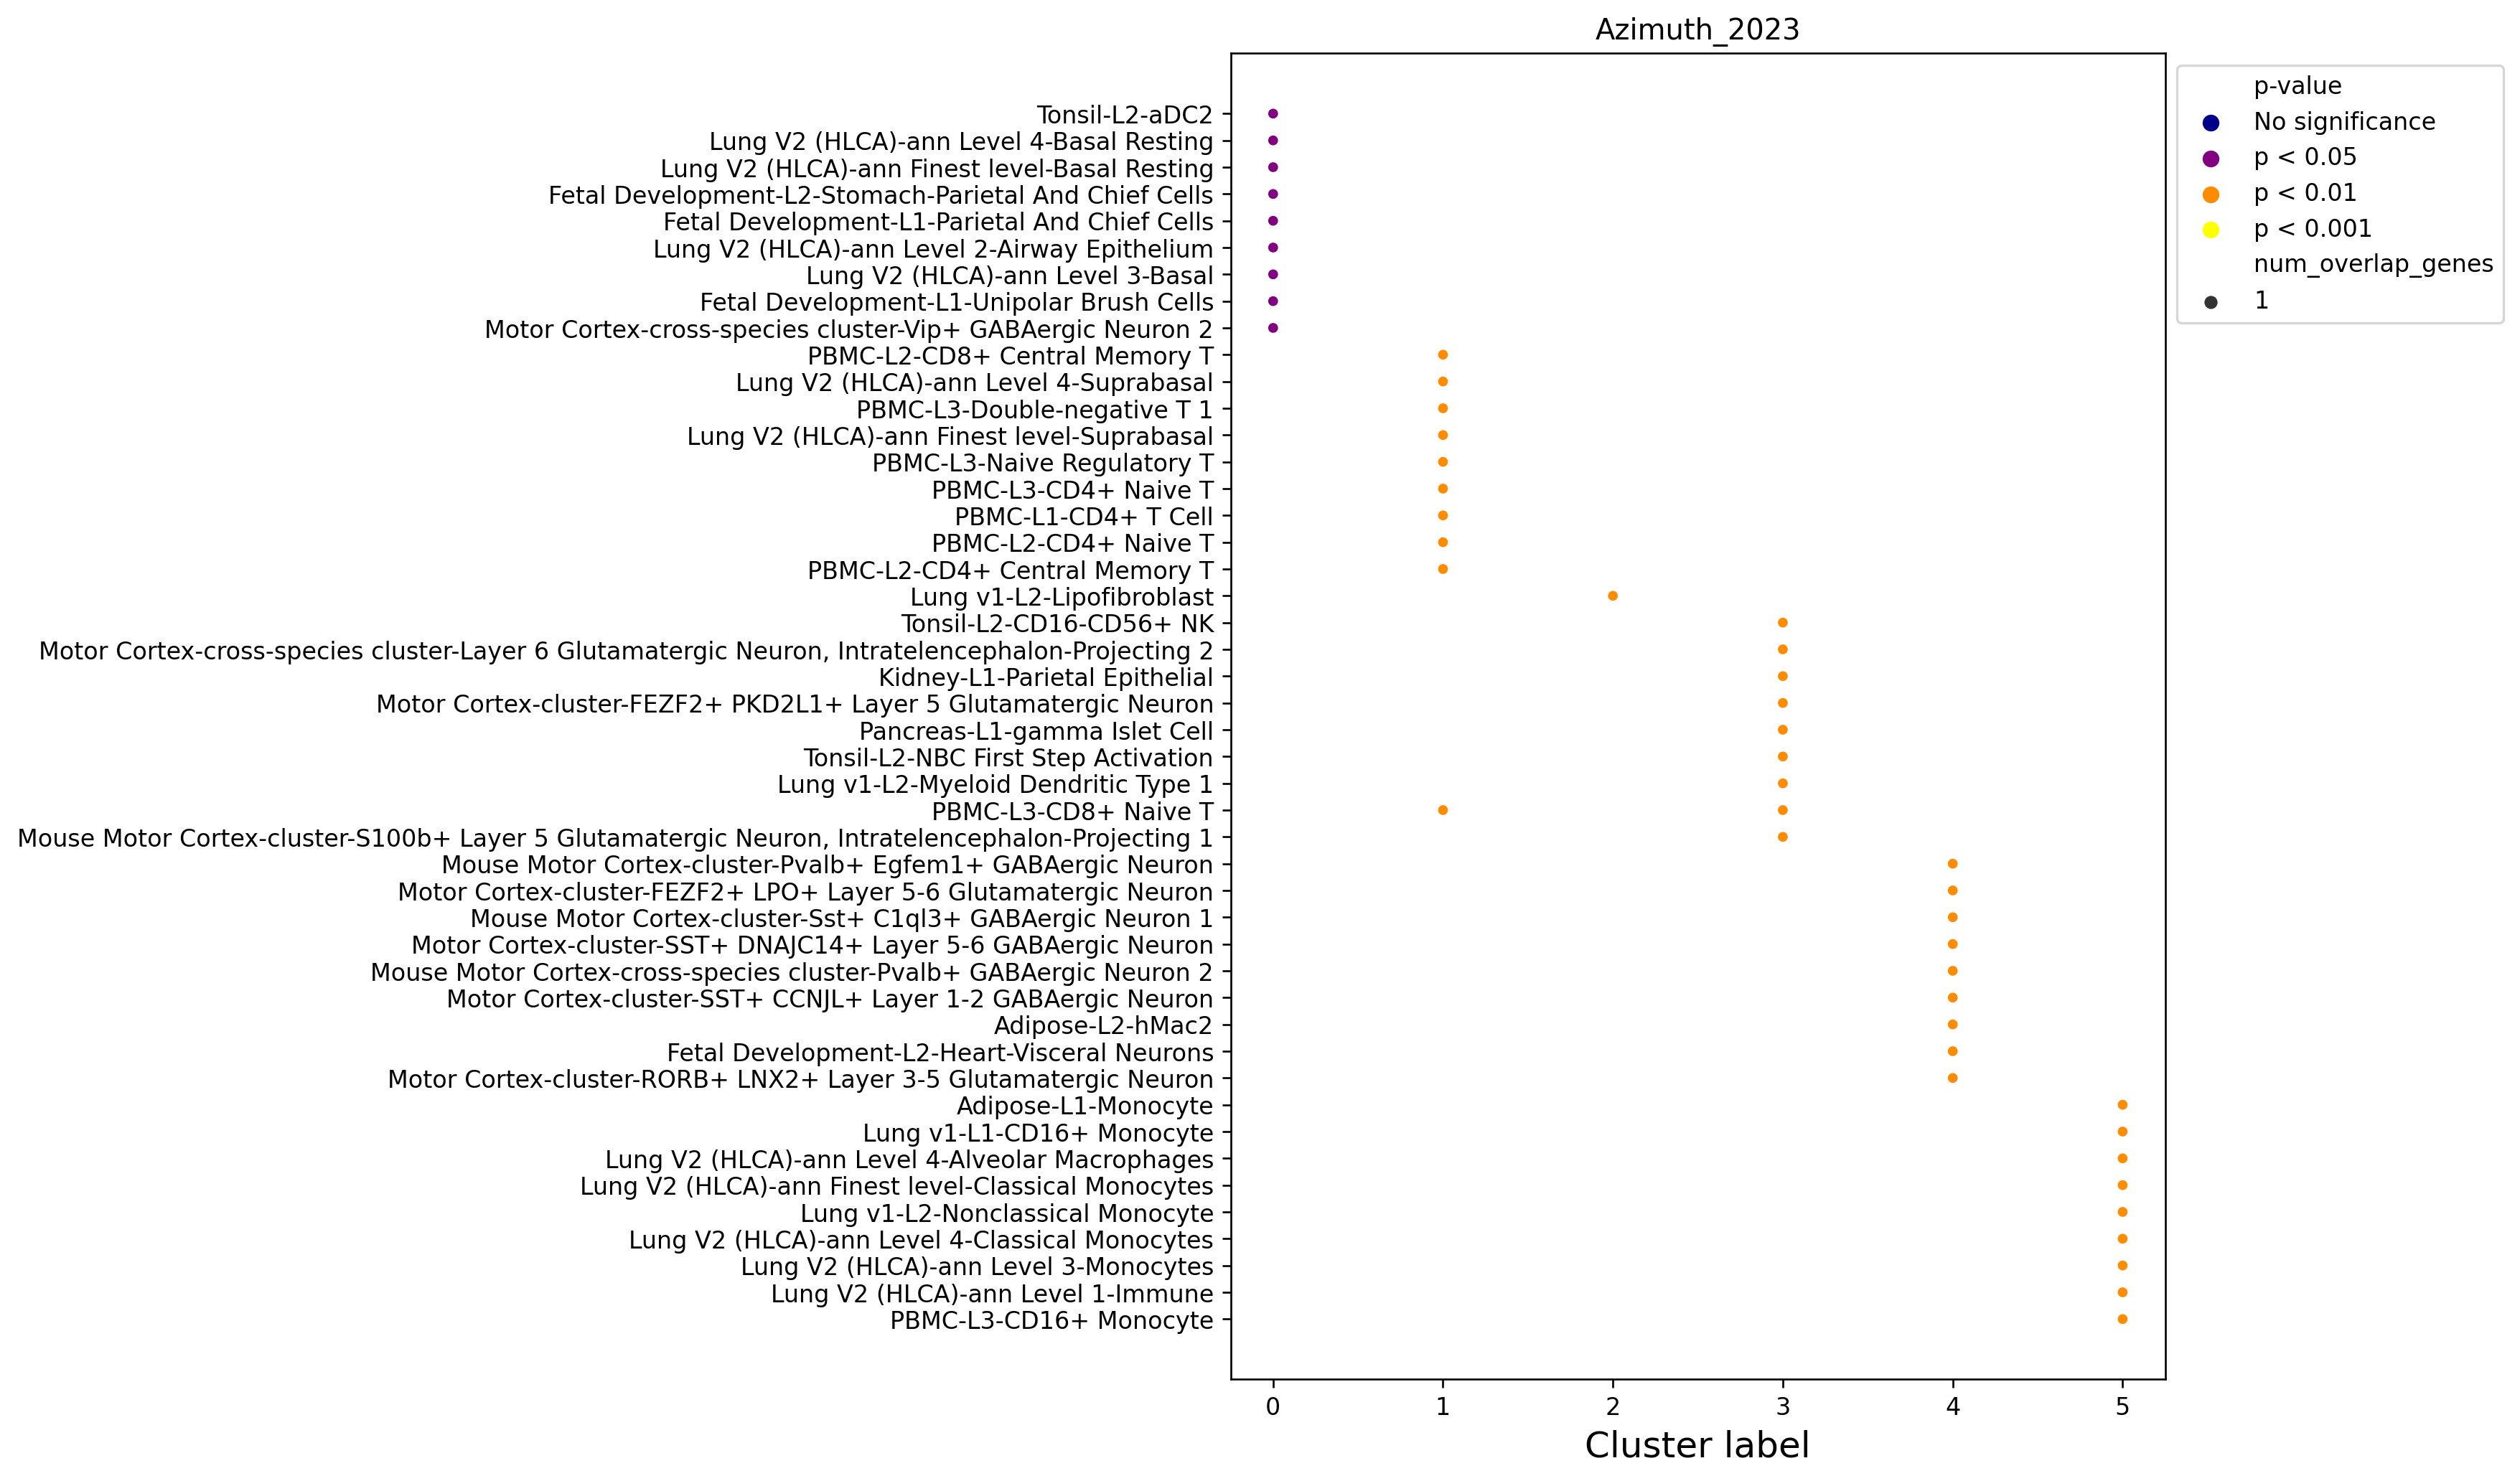

In [78]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Allen_Brain_Atlas_10x_scRNA_2021


In [79]:
db_name = 'Allen_Brain_Atlas_10x_scRNA_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [80]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  Combined score  \
Term                                                                      
Human Inh L1-2 VIP PTGER3 up     1  0.015487  11.928571       49.715013   
Mouse 6 Lamp5 Lhx6 down          2  0.016173   6.539042       26.969724   
Human Inh L2-5 VIP BSPRY up      3  0.026394  43.122222      156.732460   
Mouse 125 DG down                4  0.030237   5.092673       17.817650   
Mouse 63 Sst Chodl down          5  0.032392  34.484444      118.276512   

                                  Overlapping genes  Adjusted P-value  \
Term                                                                    
Human Inh L1-2 VIP PTGER3 up          [RGS2, NRXN2]          0.260672   
Mouse 6 Lamp5 Lhx6 down       [GDE1, NRXN2, DLGAP4]          0.260672   
Human Inh L2-5 VIP BSPRY up                [ZBTB18]          0.260672   
Mouse 125 DG down             [GDE1, NRXN2, DLGAP4]          0.260672   
Mouse 63 Sst Chodl down                    [ZBTB18]          0.260672   

                              Old p-value  Old adjusted p-value  \
Term                                                              
Human Inh L1-2 VIP PTGER3 up            0                     0   
Mouse 6 Lamp5 Lhx6 down                 0                     0   
Human Inh L2-5 VIP BSPRY up             0                     0   
Mouse 125 DG down                       0                     0   
Mouse 63 Sst Chodl down                 0                     0   

                              num_overlap_genes  neg_log10(p_adj)  \
Term                                                                
Human Inh L1-2 VIP PTGER3 up                  2          0.583906   
Mouse 6 Lamp5 Lhx6 down                       3          0.583906   
Human Inh L2-5 VIP BSPRY up                   1          0.583906   
Mouse 125 DG down                             3          0.583906   
Mouse 63 Sst Chodl down                       1          0.583906   

                              cluster_label  
Term                                         
Human Inh L1-2 VIP PTGER3 up              0  
Mouse 6 Lamp5 Lhx6 down                   0  
Human Inh L2-5 VIP BSPRY up               0  
Mouse 125 DG down                         0  
Mouse 63 Sst Chodl down                   0

In [81]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

4

In [82]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

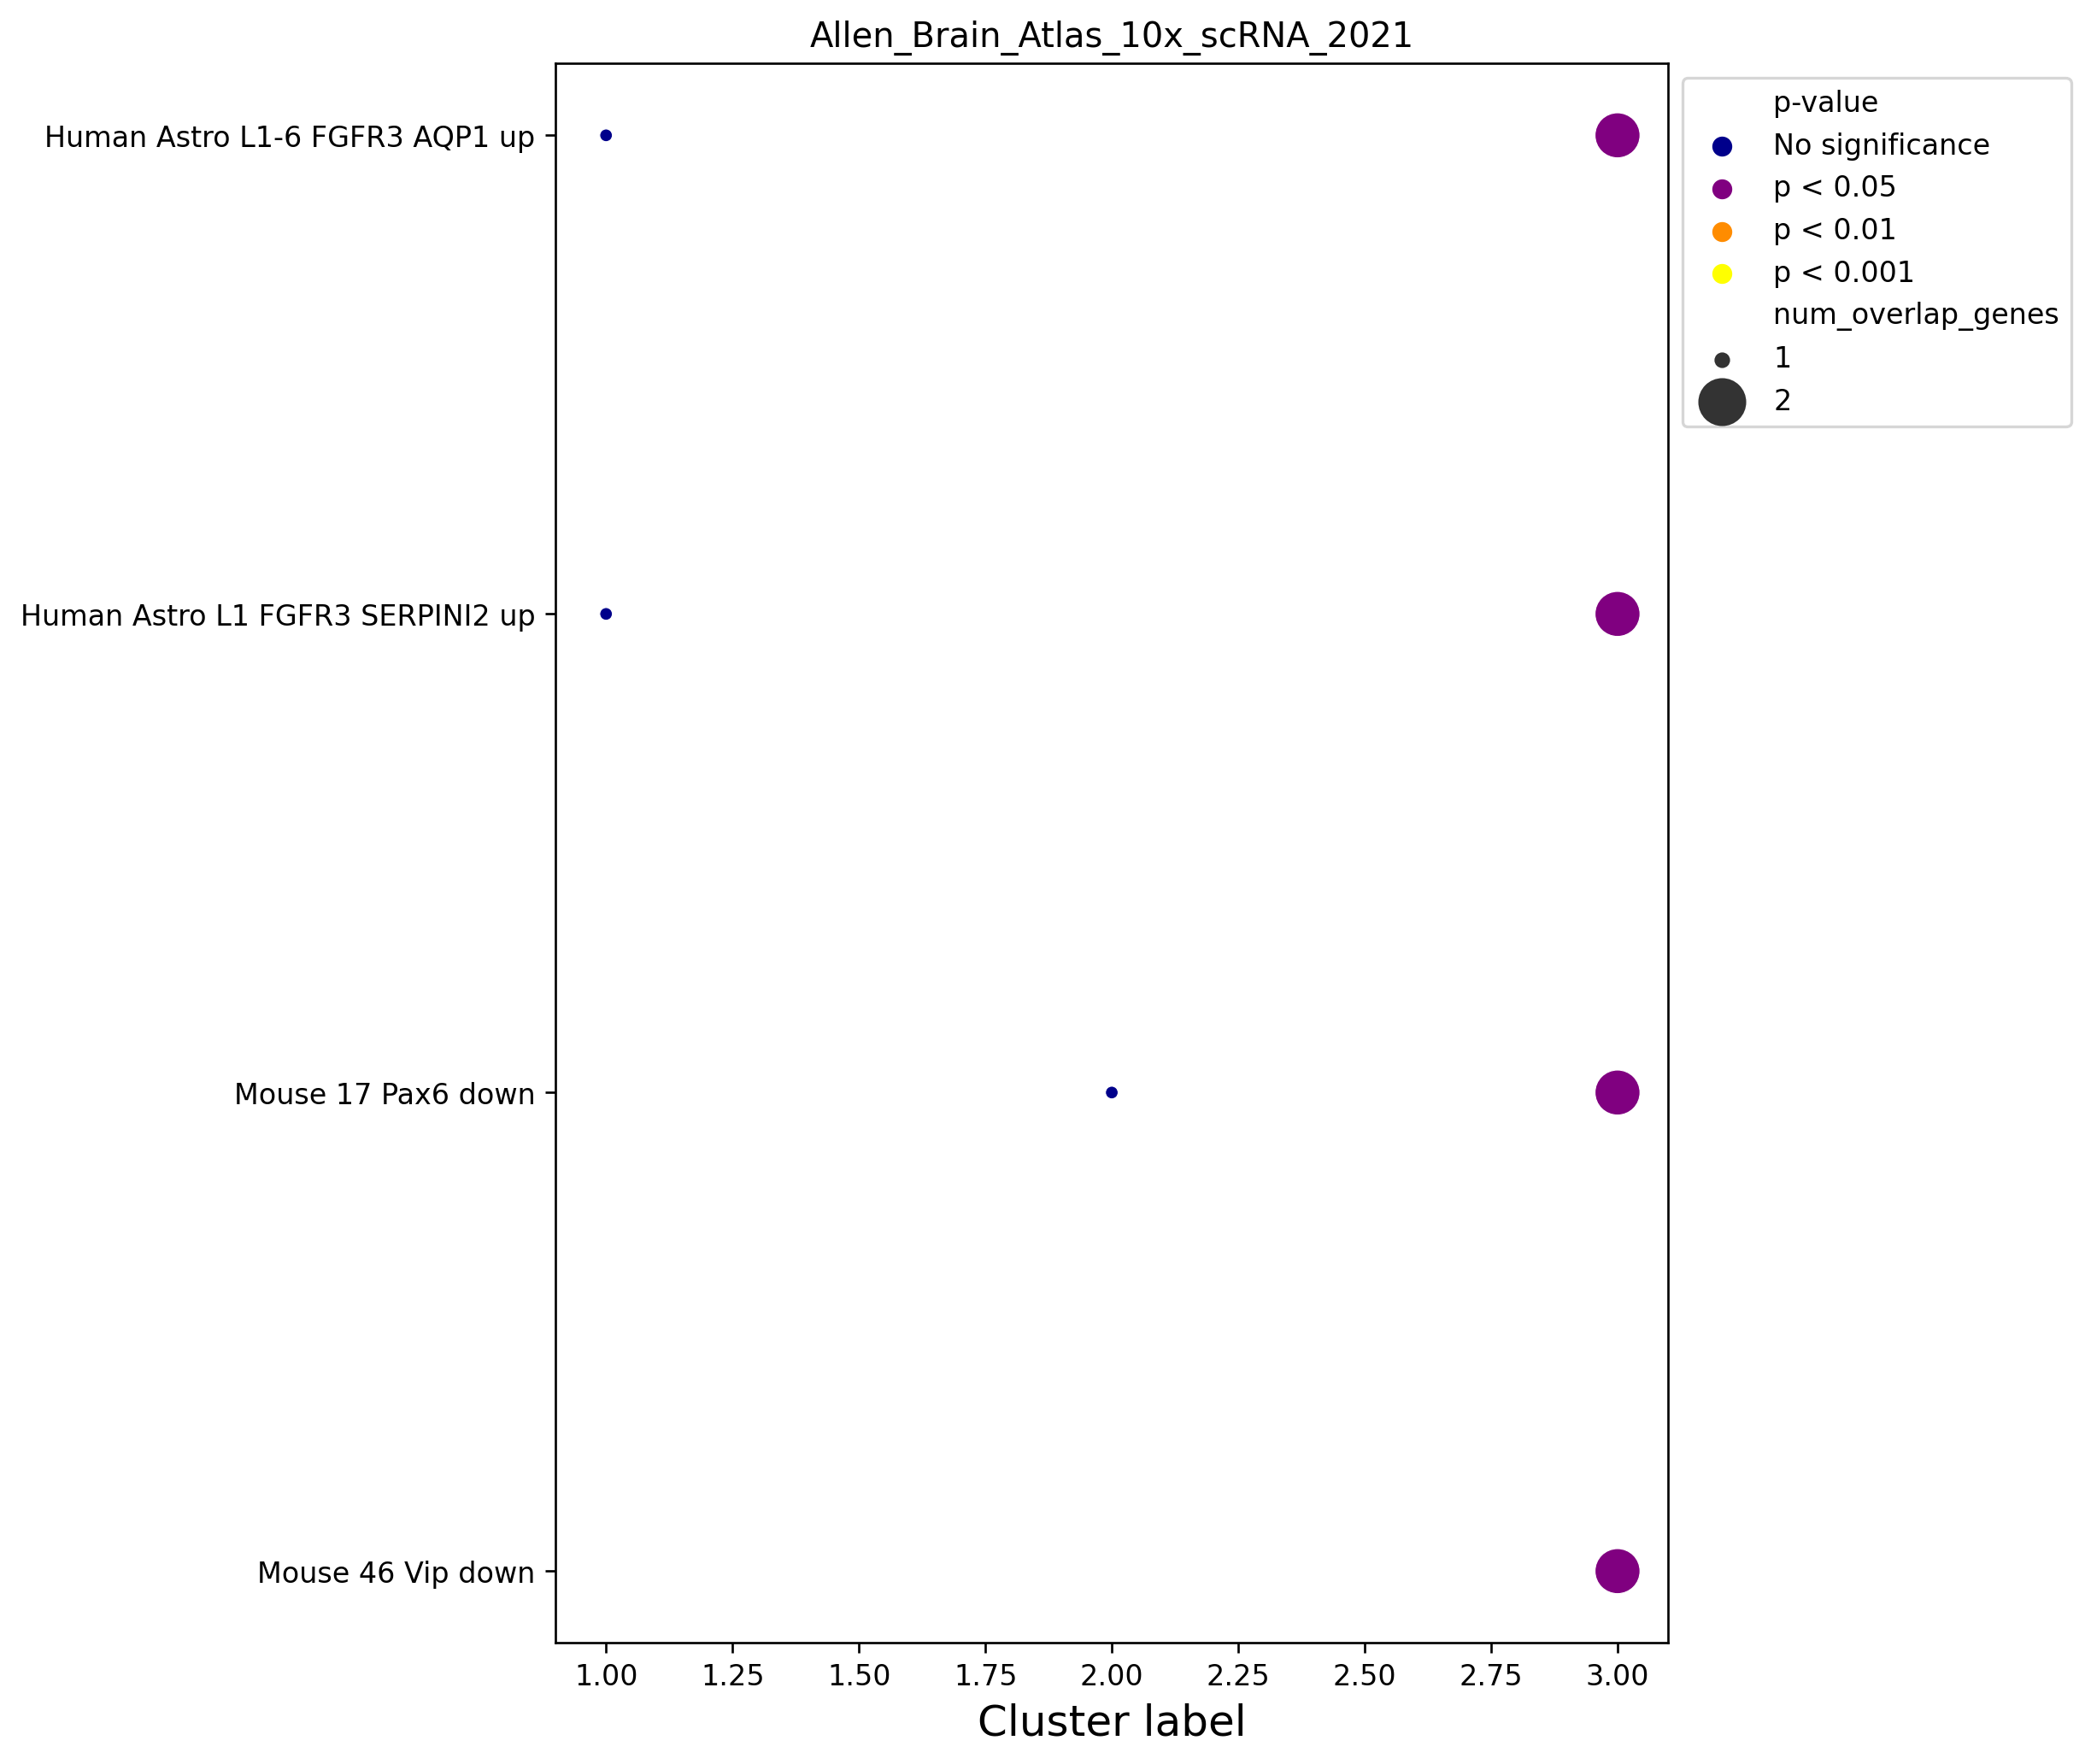

In [83]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [84]:
db_name = 'Reactome_2022'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [85]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Neurexins And Neuroligins R-HSA-6794361                1  0.000089   
Protein-protein Interactions At Synapses R-HSA-...     2  0.000301   
COPI-dependent Golgi-to-ER Retrograde Traffic R...     3  0.003884   
Chylomicron Remodeling R-HSA-8963901                   4  0.004104   
Glycerophospholipid Catabolism R-HSA-6814848           5  0.008192   

                                                       Z-score  \
Term                                                             
Neurexins And Neuroligins R-HSA-6794361              43.525328   
Protein-protein Interactions At Synapses R-HSA-...   28.245421   
COPI-dependent Golgi-to-ER Retrograde Traffic R...   25.097403   
Chylomicron Remodeling R-HSA-8963901                518.200000   
Glycerophospholipid Catabolism R-HSA-6814848        172.688889   

                                                    Combined score  \
Term                                                                 
Neurexins And Neuroligins R-HSA-6794361                 405.735984   
Protein-protein Interactions At Synapses R-HSA-...      229.057638   
COPI-dependent Golgi-to-ER Retrograde Traffic R...      139.315275   
Chylomicron Remodeling R-HSA-8963901                   2847.943283   
Glycerophospholipid Catabolism R-HSA-6814848            829.703384   

                                                         Overlapping genes  \
Term                                                                         
Neurexins And Neuroligins R-HSA-6794361             [NRXN1, NRXN2, DLGAP4]   
Protein-protein Interactions At Synapses R-HSA-...  [NRXN1, NRXN2, DLGAP4]   
COPI-dependent Golgi-to-ER Retrograde Traffic R...         [TMED3, KIF21B]   
Chylomicron Remodeling R-HSA-8963901                                 [LPL]   
Glycerophospholipid Catabolism R-HSA-6814848                        [GDE1]   

                                                    Adjusted P-value  \
Term                                                                   
Neurexins And Neuroligins R-HSA-6794361                     0.007961   
Protein-protein Interactions At Synapses R-HSA-...          0.013379   
COPI-dependent Golgi-to-ER Retrograde Traffic R...          0.091310   
Chylomicron Remodeling R-HSA-8963901                        0.091310   
Glycerophospholipid Catabolism R-HSA-6814848                0.125581   

                                                    Old p-value  \
Term                                                              
Neurexins And Neuroligins R-HSA-6794361                       0   
Protein-protein Interactions At Synapses R-HSA-...            0   
COPI-dependent Golgi-to-ER Retrograde Traffic R...            0   
Chylomicron Remodeling R-HSA-8963901                          0   
Glycerophospholipid Catabolism R-HSA-6814848                  0   

                                                    Old adjusted p-value  \
Term                                                                       
Neurexins And Neuroligins R-HSA-6794361                                0   
Protein-protein Interactions At Synapses R-HSA-...                     0   
COPI-dependent Golgi-to-ER Retrograde Traffic R...                     0   
Chylomicron Remodeling R-HSA-8963901                                   0   
Glycerophospholipid Catabolism R-HSA-6814848                           0   

                                                    num_overlap_genes  \
Term                                                                    
Neurexins And Neuroligins R-HSA-6794361                             3   
Protein-protein Interactions At Synapses R-HSA-...                  3   
COPI-dependent Golgi-to-ER Retrograde Traffic R...                  2   
Chylomicron Remodeling R-HSA-8963901                                1   
Glycerophospholipid Catabolism R-HSA-6814848                        1   

                                        

In [86]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

6

In [87]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

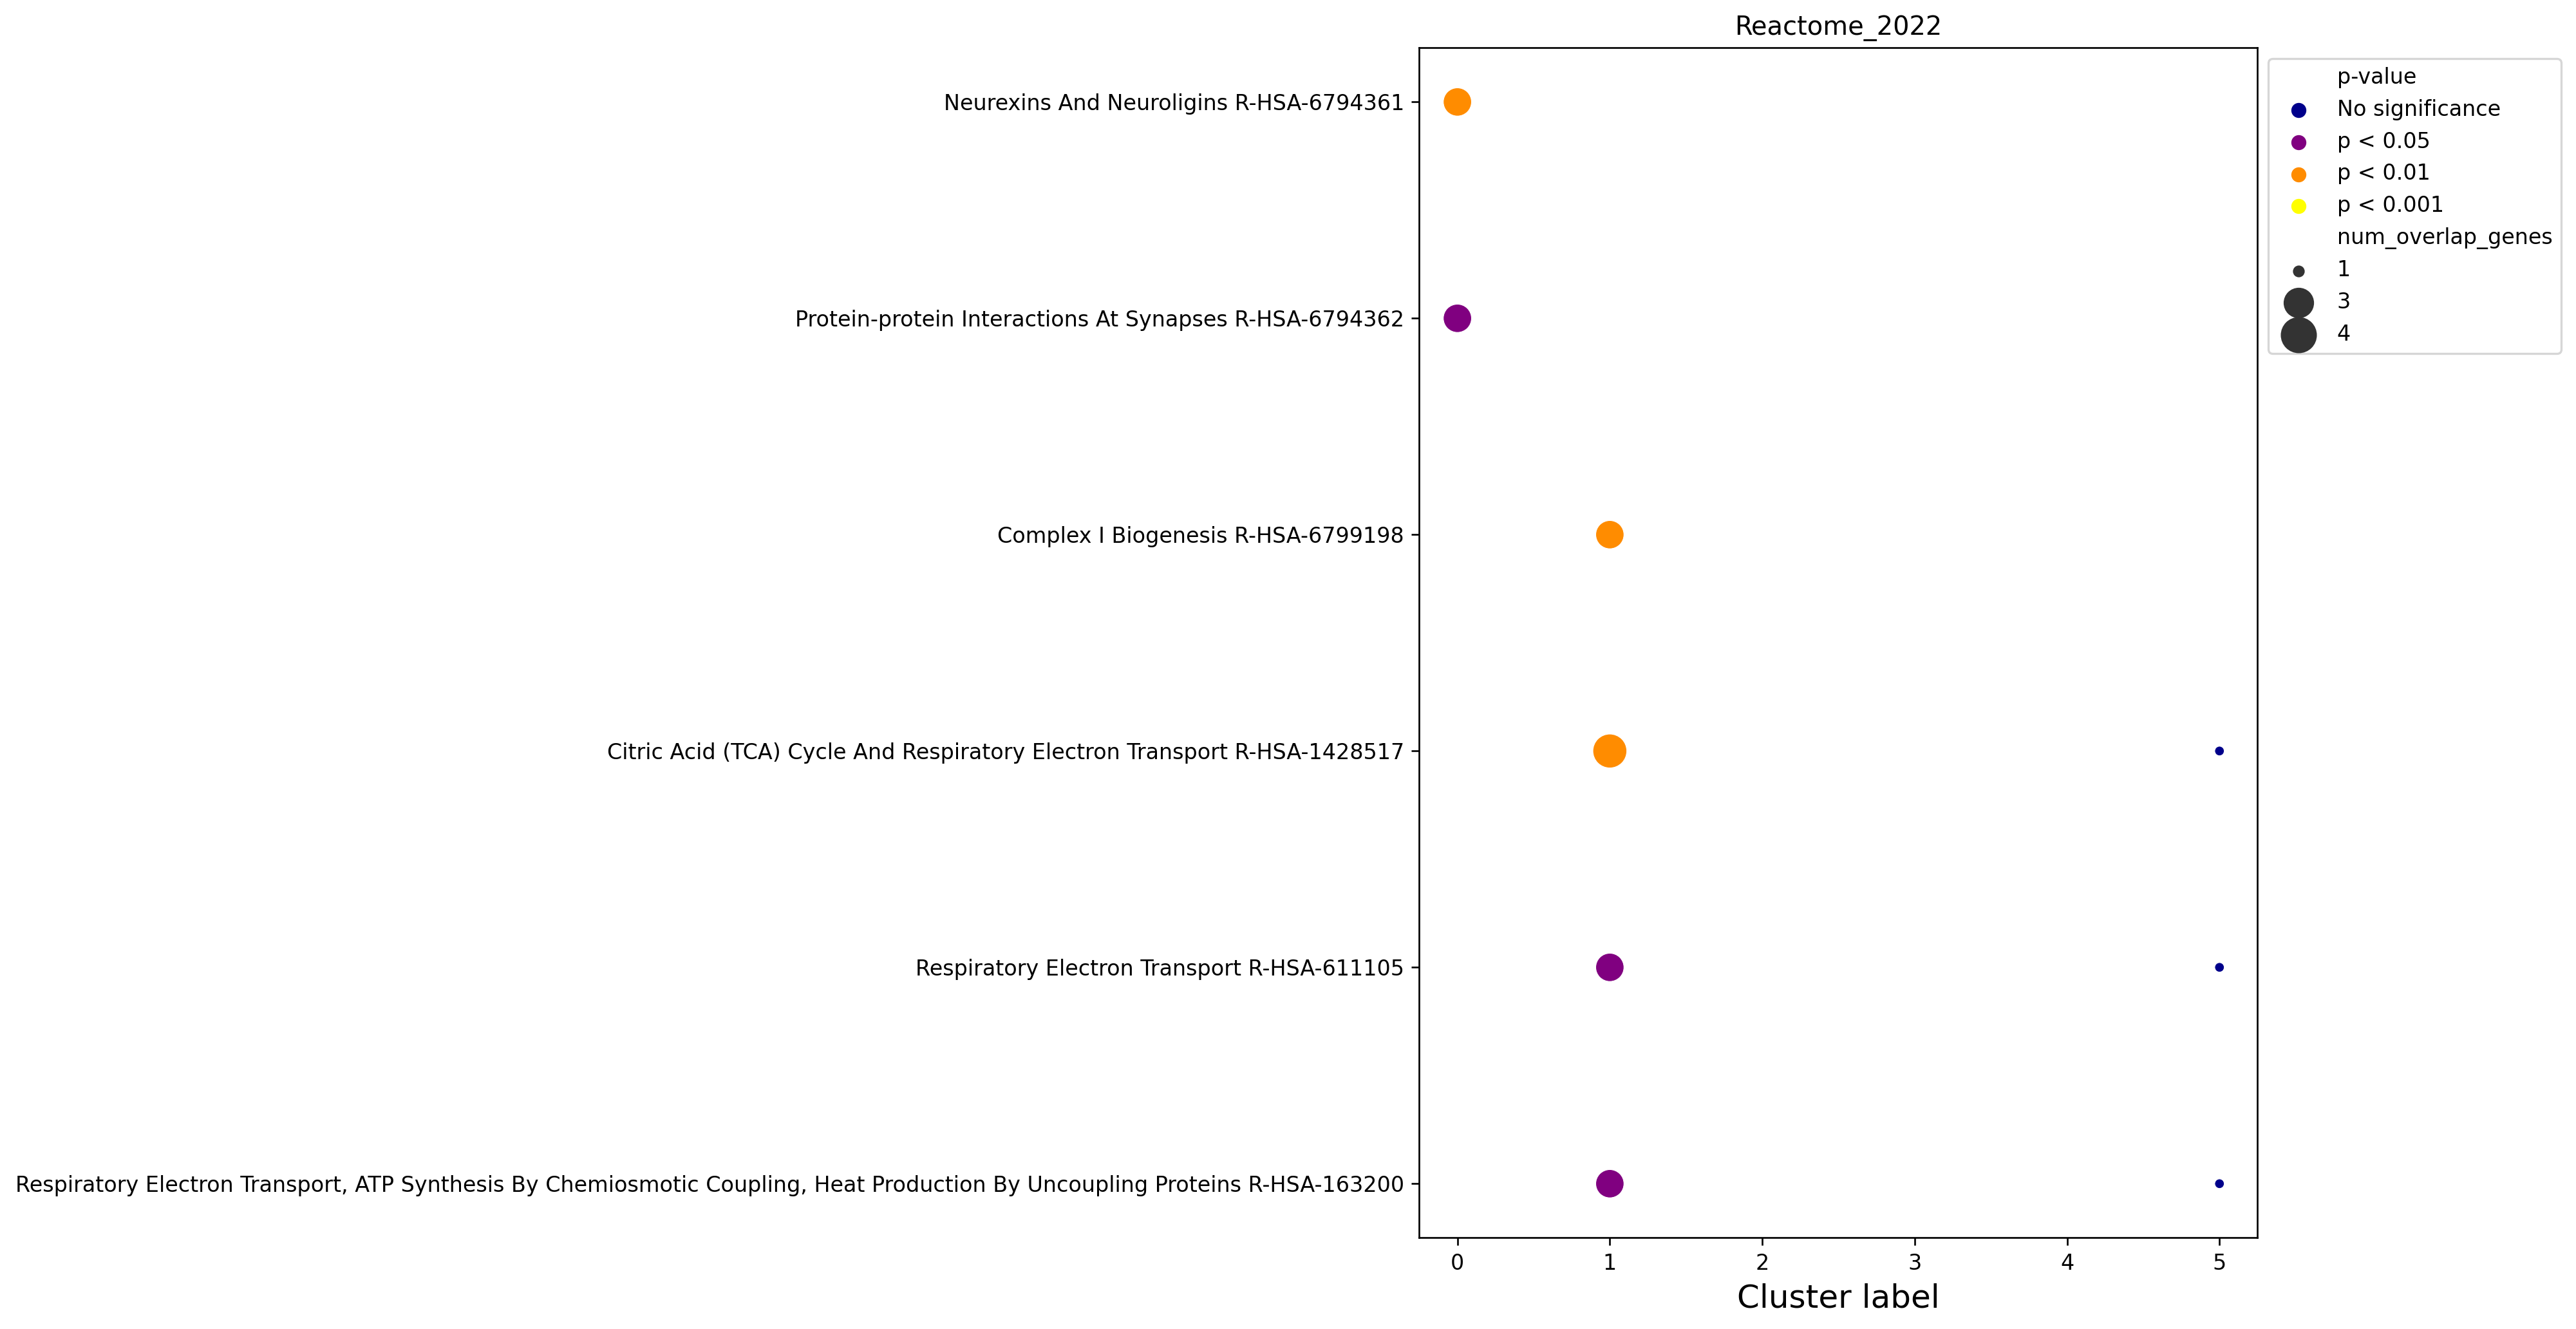

In [88]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## SynGO_2022

In [89]:
db_name = 'SynGO_2022'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [90]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                            
Maintenance Of Postsynaptic Specialization Stru...    1  0.010230  129.500000   
Regulation Of Postsynaptic Specialization Assem...    2  0.012264  103.586667   
Synapse Assembly (GO:0007416) BP                      3  0.014294   86.311111   
Regulation Of Postsynaptic Density Assembly (GO...    4  0.020362   57.518519   
Postsynaptic Specialization (GO:0099572) CC           5  0.020362   57.518519   

                                                    Combined score  \
Term                                                                 
Maintenance Of Postsynaptic Specialization Stru...      593.424913   
Regulation Of Postsynaptic Specialization Assem...      455.892368   
Synapse Assembly (GO:0007416) BP                        366.639488   
Regulation Of Postsynaptic Density Assembly (GO...      223.982396   
Postsynaptic Specialization (GO:0099572) CC             223.982396   

                                                   Overlapping genes  \
Term                                                                   
Maintenance Of Postsynaptic Specialization Stru...         [SYNGAP1]   
Regulation Of Postsynaptic Specialization Assem...           [NRXN1]   
Synapse Assembly (GO:0007416) BP                             [NRXN1]   
Regulation Of Postsynaptic Density Assembly (GO...           [NRXN1]   
Postsynaptic Specialization (GO:0099572) CC                 [DLGAP4]   

                                                    Adjusted P-value  \
Term                                                                   
Maintenance Of Postsynaptic Specialization Stru...          0.056795   
Regulation Of Postsynaptic Specialization Assem...          0.056795   
Synapse Assembly (GO:0007416) BP                            0.056795   
Regulation Of Postsynaptic Density Assembly (GO...          0.056795   
Postsynaptic Specialization (GO:0099572) CC                 0.056795   

                                                   Old p-value  \
Term                                                             
Maintenance Of Postsynaptic Specialization Stru...           0   
Regulation Of Postsynaptic Specialization Assem...           0   
Synapse Assembly (GO:0007416) BP                             0   
Regulation Of Postsynaptic Density Assembly (GO...           0   
Postsynaptic Specialization (GO:0099572) CC                  0   

                                                   Old adjusted p-value  \
Term                                                                      
Maintenance Of Postsynaptic Specialization Stru...                    0   
Regulation Of Postsynaptic Specialization Assem...                    0   
Synapse Assembly (GO:0007416) BP                                      0   
Regulation Of Postsynaptic Density Assembly (GO...                    0   
Postsynaptic Specialization (GO:0099572) CC                           0   

                                                   num_overlap_genes  \
Term                                                                   
Maintenance Of Postsynaptic Specialization Stru...                 1   
Regulation Of Postsynaptic Specialization Assem...                 1   
Synapse Assembly (GO:0007416) BP                                   1   
Regulation Of Postsynaptic Density Assembly (GO...                 1   
Postsynaptic Specialization (GO:0099572) CC                        1   

                                                    neg_log10(p_adj)  \
Term                                                                   
Maintenance Of Postsynaptic Specialization Stru...          1.245693   
Regulation Of Postsynaptic Specialization Assem...          1.245693   
Synapse Assembly (GO:0007416) BP                            1.245693   
Regulation Of Postsynaptic Density Assembly (GO...          1.245693   
Postsynaptic Specialization (GO:0099572) CC             

In [91]:
enrich_res[enrich_res.cluster_label == 2]

Empty DataFrame
Columns: [Rank, p-val, Z-score, Combined score, Overlapping genes, Adjusted P-value, Old p-value, Old adjusted p-value, num_overlap_genes, neg_log10(p_adj), cluster_label]
Index: []

In [92]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

8

In [93]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

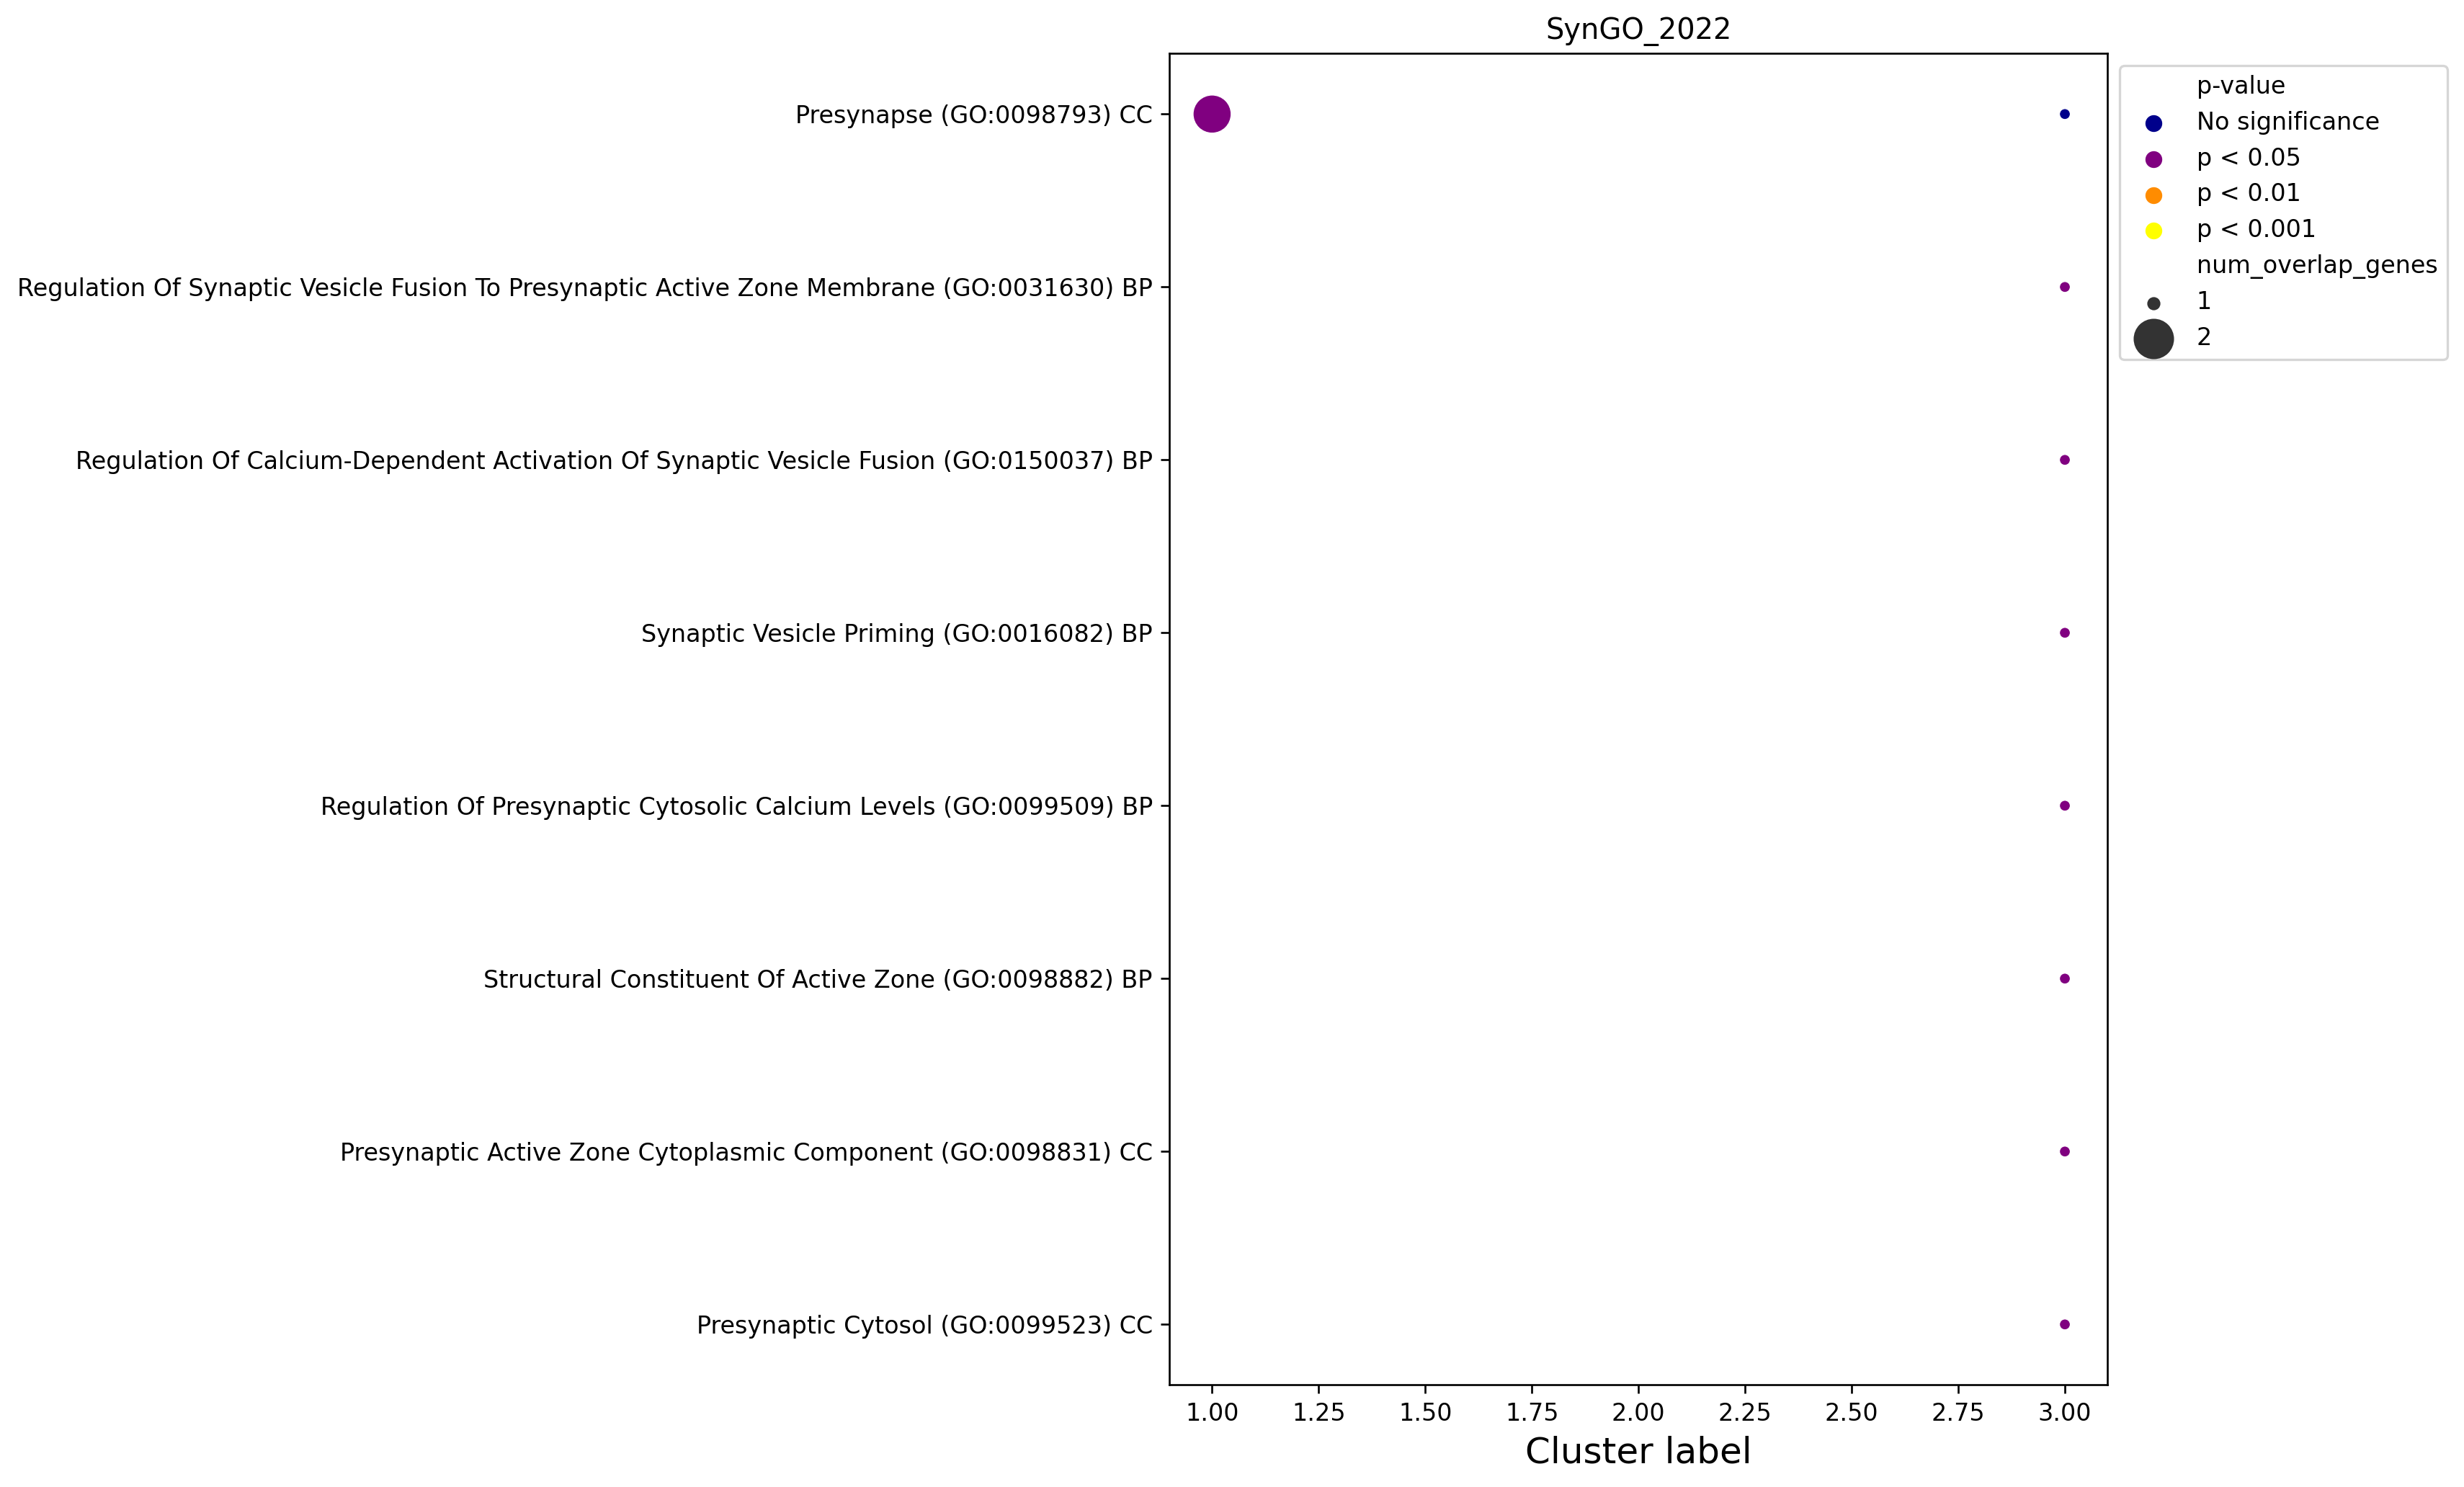

In [94]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [95]:
db_name = 'MGI_Mammalian_Phenotype_Level_4_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [96]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
decreased circulating aspartate transaminase le...     1  0.000049   
abnormal lipid homeostasis MP:0002118                  2  0.000250   
impaired spatial learning MP:0012307                   3  0.002663   
abnormal pulmonary alveolus morphology MP:0002270      4  0.004051   
pale spleen MP:0009246                                 5  0.004104   

                                                       Z-score  \
Term                                                             
decreased circulating aspartate transaminase le...   54.132867   
abnormal lipid homeostasis MP:0002118                30.176010   
impaired spatial learning MP:0012307                 30.706349   
abnormal pulmonary alveolus morphology MP:0002270    24.536508   
pale spleen MP:0009246                              518.200000   

                                                    Combined score  \
Term                                                                 
decreased circulating aspartate transaminase le...      537.520094   
abnormal lipid homeostasis MP:0002118                   250.313211   
impaired spatial learning MP:0012307                    182.033792   
abnormal pulmonary alveolus morphology MP:0002270       135.164130   
pale spleen MP:0009246                                 2847.943283   

                                                           Overlapping genes  \
Term                                                                           
decreased circulating aspartate transaminase le...  [ZBTB46, KIF21B, DLGAP4]   
abnormal lipid homeostasis MP:0002118                  [ASAH1, LPL, ST3GAL5]   
impaired spatial learning MP:0012307                        [KIF21B, DLGAP4]   
abnormal pulmonary alveolus morphology MP:0002270               [ASAH1, LPL]   
pale spleen MP:0009246                                               [ASAH1]   

                                                    Adjusted P-value  \
Term                                                                   
decreased circulating aspartate transaminase le...          0.010960   
abnormal lipid homeostasis MP:0002118                       0.028095   
impaired spatial learning MP:0012307                        0.067660   
abnormal pulmonary alveolus morphology MP:0002270           0.067660   
pale spleen MP:0009246                                      0.067660   

                                                    Old p-value  \
Term                                                              
decreased circulating aspartate transaminase le...            0   
abnormal lipid homeostasis MP:0002118                         0   
impaired spatial learning MP:0012307                          0   
abnormal pulmonary alveolus morphology MP:0002270             0   
pale spleen MP:0009246                                        0   

                                                    Old adjusted p-value  \
Term                                                                       
decreased circulating aspartate transaminase le...                     0   
abnormal lipid homeostasis MP:0002118                                  0   
impaired spatial learning MP:0012307                                   0   
abnormal pulmonary alveolus morphology MP:0002270                      0   
pale spleen MP:0009246                                                 0   

                                                    num_overlap_genes  \
Term                                                                    
decreased circulating aspartate transaminase le...                  3   
abnormal lipid homeostasis MP:0002118                               3   
impaired spatial learning MP:0012307                                2   
abnormal pulmonary alveolus morphology MP:0002270                   2   
pale spleen MP:0009246                                              1   

                          

In [97]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

29

In [98]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

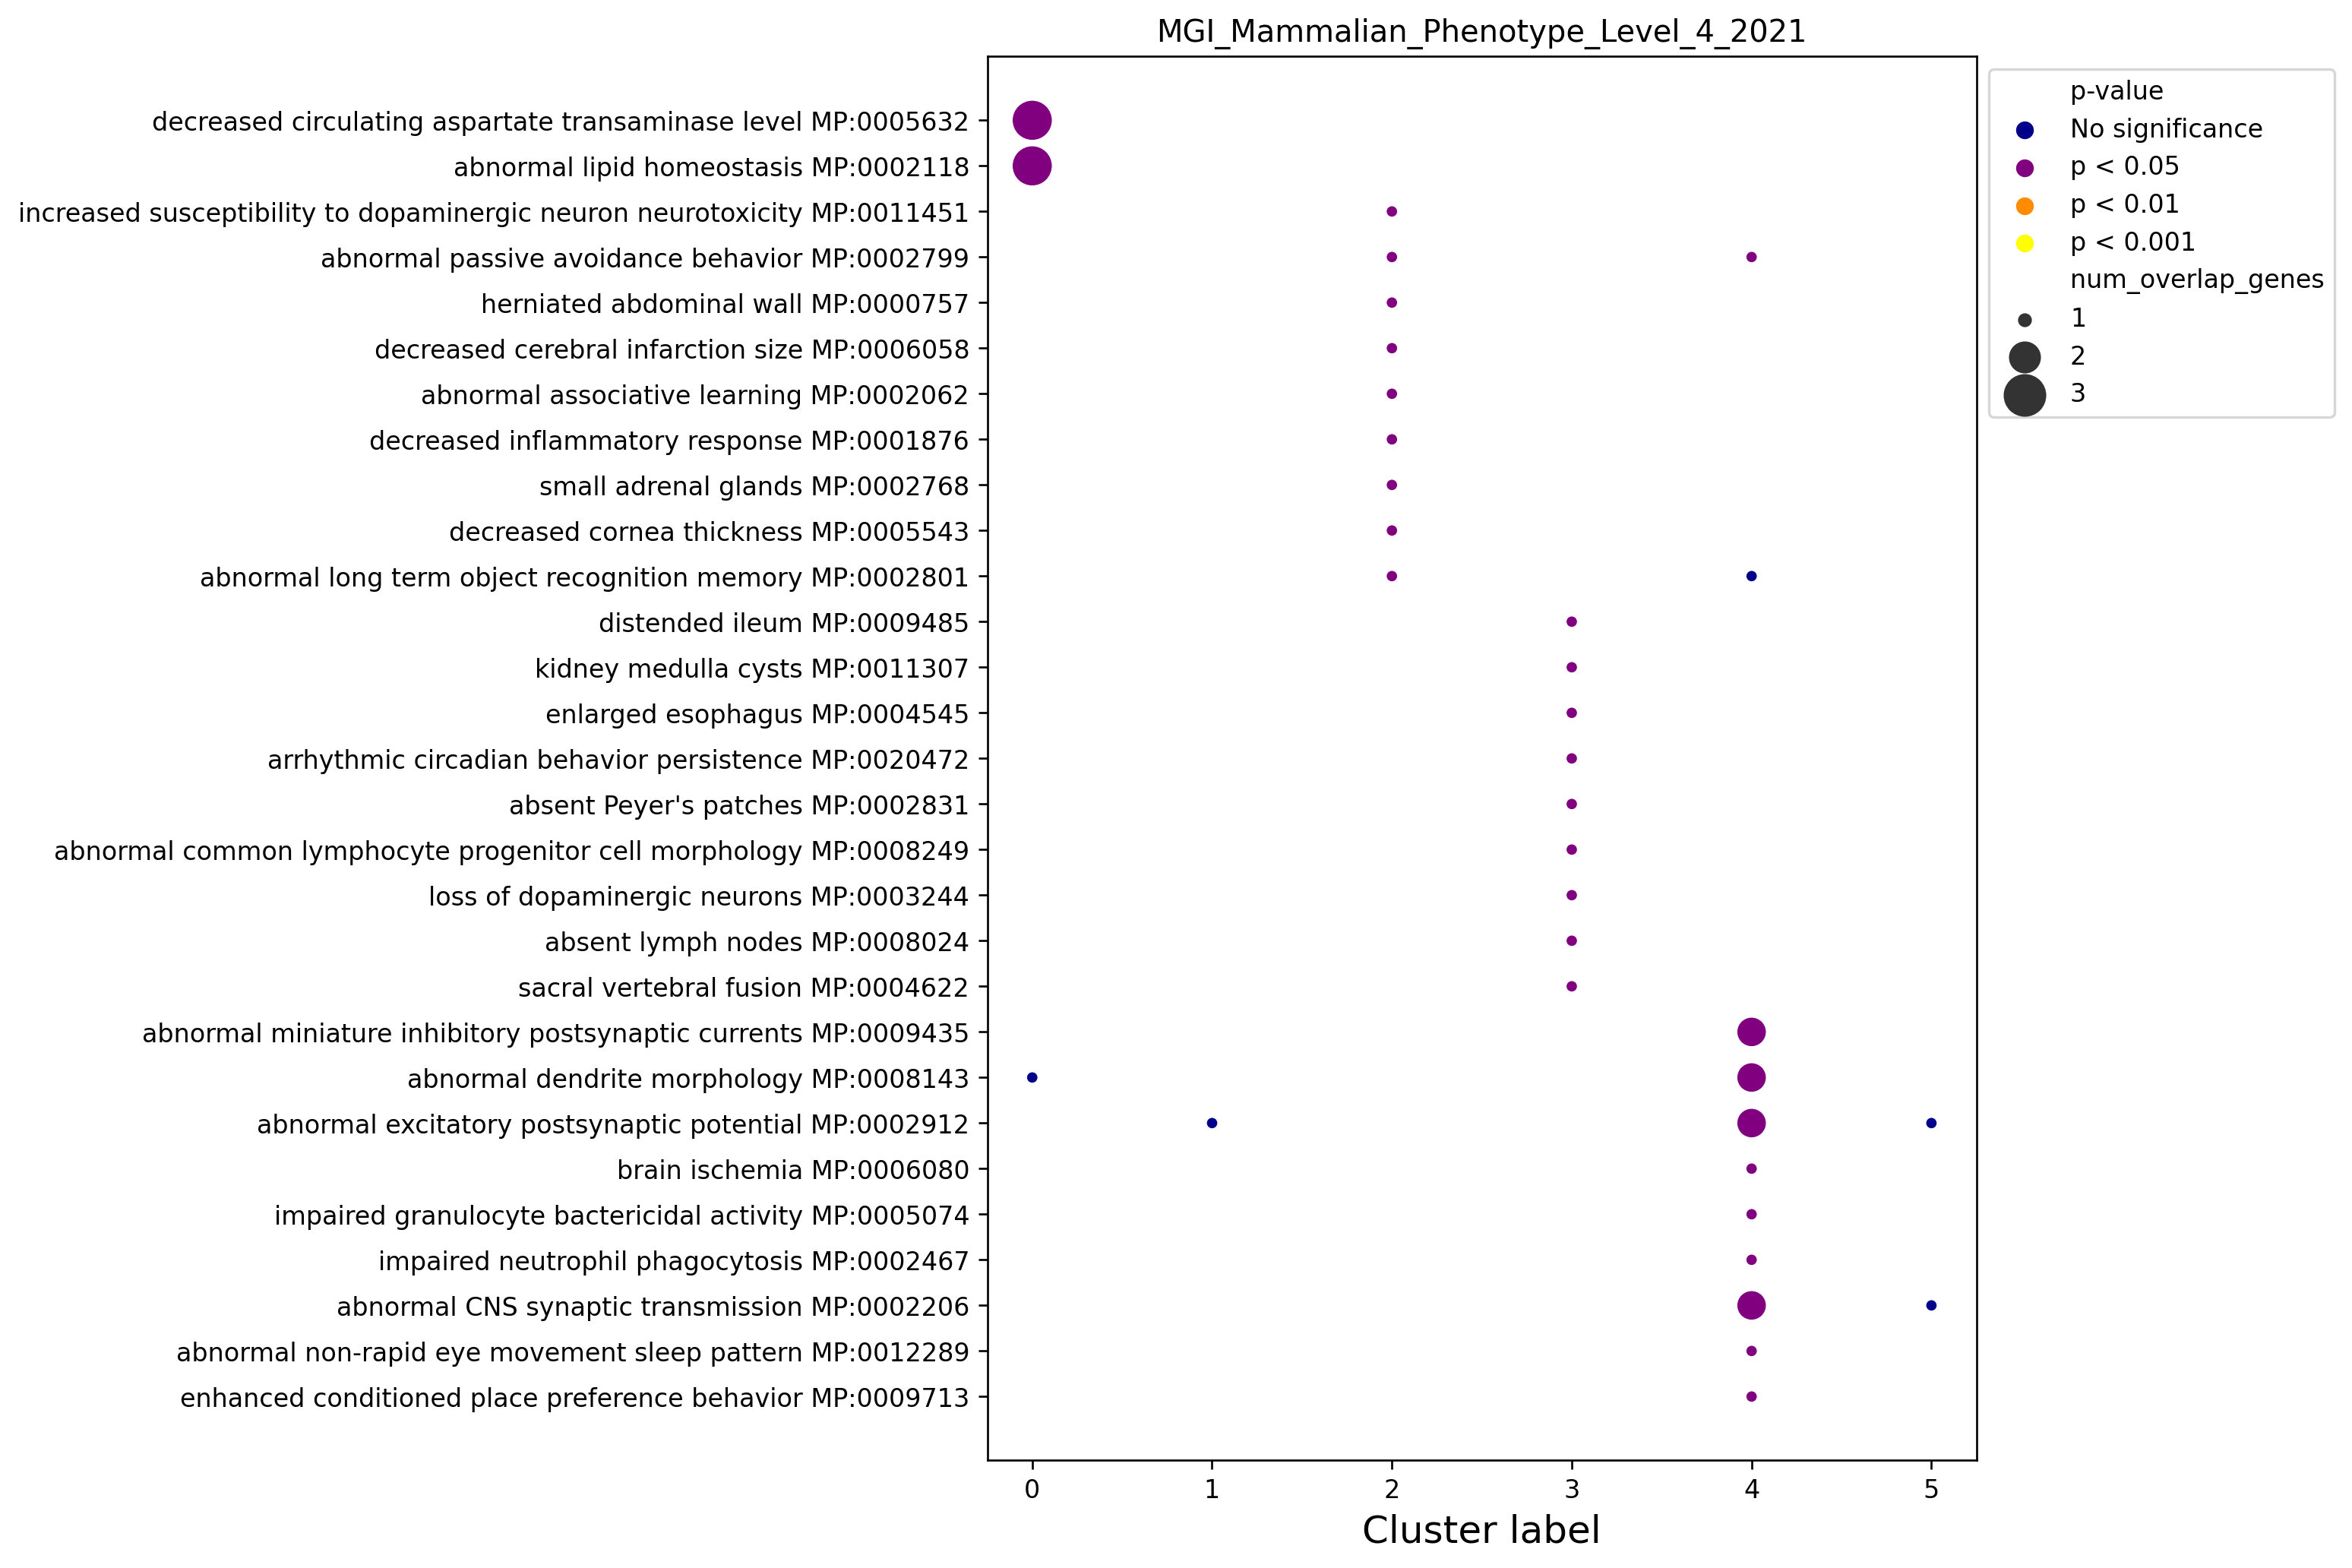

In [99]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [100]:
db_name = 'KEGG_2021_Human'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [101]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  Combined score  \
Term                                                                        
Cell adhesion molecules            1  0.005128  21.633053      114.073743   
Glycosphingolipid biosynthesis     2  0.032392  34.484444      118.276512   
Cholesterol metabolism             3  0.040335  27.210526       87.360629   
Olfactory transduction             4  0.042311  25.846667       81.745617   
Ferroptosis                        5  0.046252  23.490909       72.203055   

                               Overlapping genes  Adjusted P-value  \
Term                                                                 
Cell adhesion molecules           [NRXN1, NRXN2]          0.071786   
Glycosphingolipid biosynthesis         [ST3GAL5]          0.101470   
Cholesterol metabolism                     [LPL]          0.101470   
Olfactory transduction                    [RGS2]          0.101470   
Ferroptosis                           [MAP1LC3B]          0.101470   

                                Old p-value  Old adjusted p-value  \
Term                                                                
Cell adhesion molecules                   0                     0   
Glycosphingolipid biosynthesis            0                     0   
Cholesterol metabolism                    0                     0   
Olfactory transduction                    0                     0   
Ferroptosis                               0                     0   

                                num_overlap_genes  neg_log10(p_adj)  \
Term                                                                  
Cell adhesion molecules                         2          1.143960   
Glycosphingolipid biosynthesis                  1          0.993661   
Cholesterol metabolism                          1          0.993661   
Olfactory transduction                          1          0.993661   
Ferroptosis                                     1          0.993661   

                                cluster_label  
Term                                           
Cell adhesion molecules                     0  
Glycosphingolipid biosynthesis              0  
Cholesterol metabolism                      0  
Olfactory transduction                      0  
Ferroptosis                                 0

In [102]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

2

In [103]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

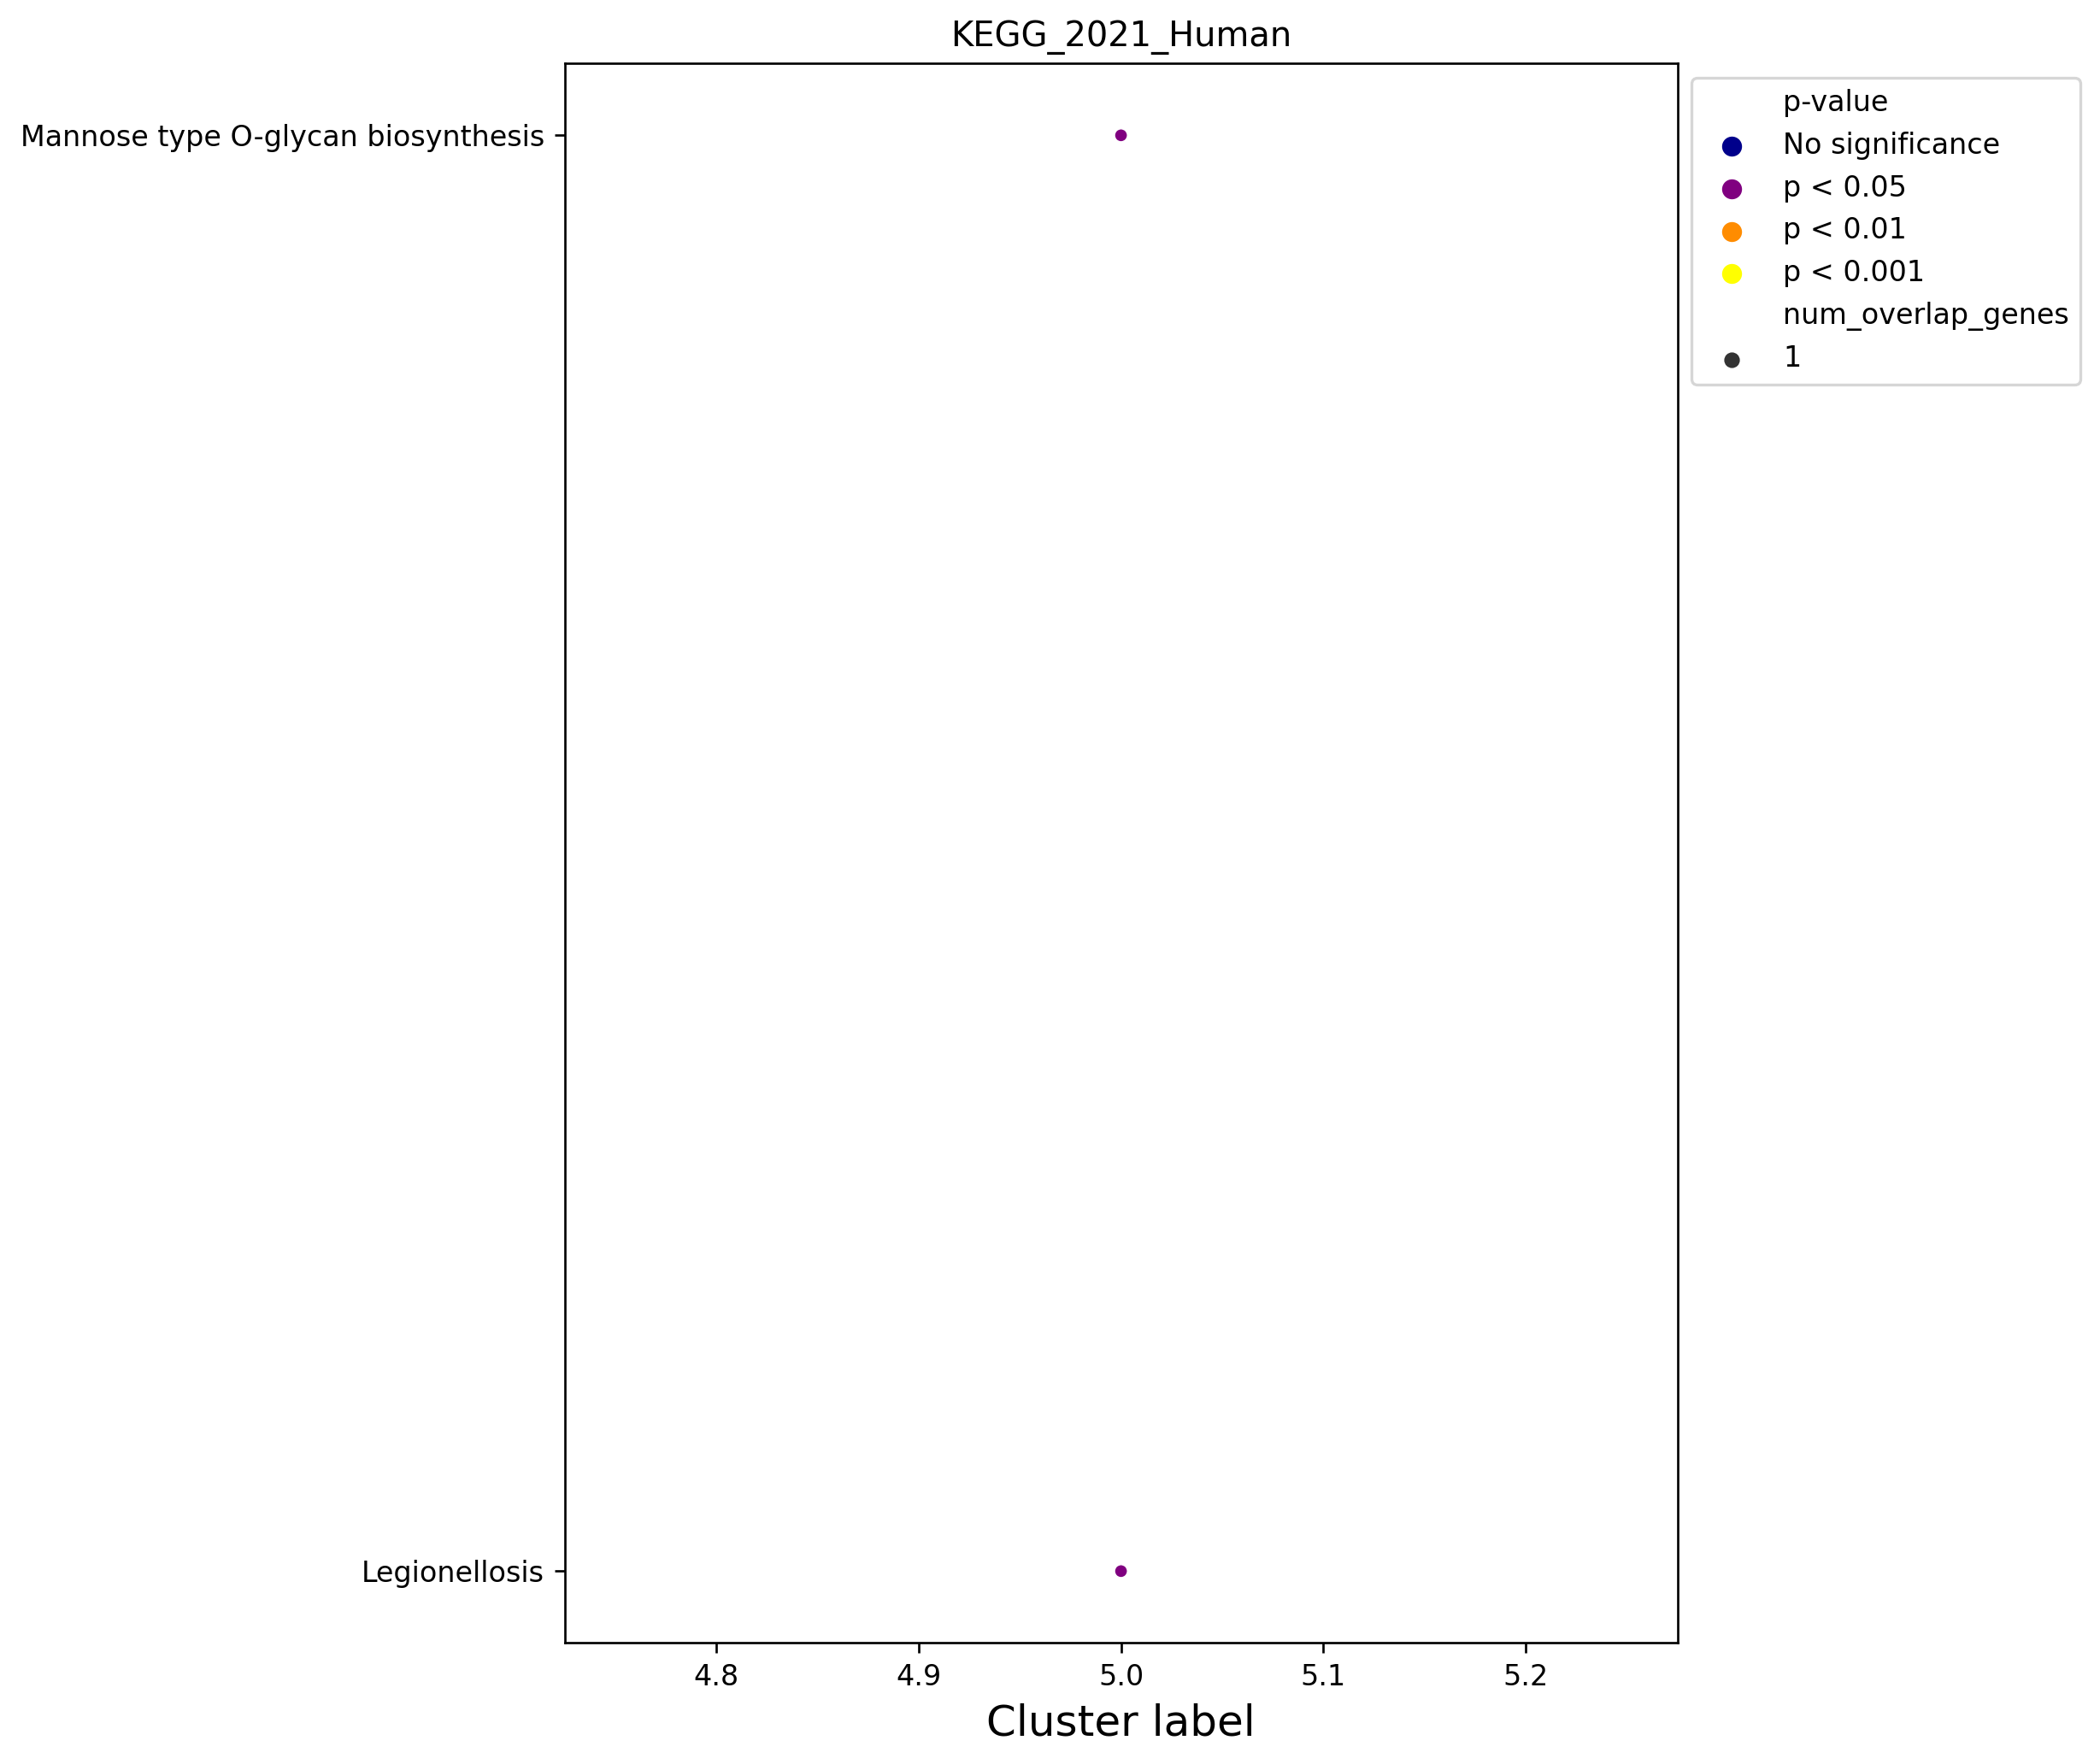

In [104]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## UK_Biobank_GWAS_v1

In [155]:
db_name = 'UK_Biobank_GWAS_v1'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [156]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Other/unspecified seropositiverheumatoid arthri...     1  0.004104   
Recent restlessness 20516                              2  0.010230   
Self-reported eczema/dermatitis 20002 1452             3  0.010230   
Loneliness/isolation 2020                              4  0.012264   
Self-reported angina 20002 1074                        5  0.016321   

                                                       Z-score  \
Term                                                             
Other/unspecified seropositiverheumatoid arthri...  518.200000   
Recent restlessness 20516                           129.500000   
Self-reported eczema/dermatitis 20002 1452          129.500000   
Loneliness/isolation 2020                           103.586667   
Self-reported angina 20002 1074                      73.971429   

                                                    Combined score  \
Term                                                                 
Other/unspecified seropositiverheumatoid arthri...     2847.943283   
Recent restlessness 20516                               593.424913   
Self-reported eczema/dermatitis 20002 1452              593.424913   
Loneliness/isolation 2020                               455.892368   
Self-reported angina 20002 1074                         304.415577   

                                                   Overlapping genes  \
Term                                                                   
Other/unspecified seropositiverheumatoid arthri...         [SYNGAP1]   
Recent restlessness 20516                                    [NRXN2]   
Self-reported eczema/dermatitis 20002 1452                  [ZBTB46]   
Loneliness/isolation 2020                                    [NRXN1]   
Self-reported angina 20002 1074                                [LPL]   

                                                    Adjusted P-value  \
Term                                                                   
Other/unspecified seropositiverheumatoid arthri...          0.202811   
Recent restlessness 20516                                   0.202811   
Self-reported eczema/dermatitis 20002 1452                  0.202811   
Loneliness/isolation 2020                                   0.202811   
Self-reported angina 20002 1074                             0.202811   

                                                    Old p-value  \
Term                                                              
Other/unspecified seropositiverheumatoid arthri...            0   
Recent restlessness 20516                                     0   
Self-reported eczema/dermatitis 20002 1452                    0   
Loneliness/isolation 2020                                     0   
Self-reported angina 20002 1074                               0   

                                                    Old adjusted p-value  \
Term                                                                       
Other/unspecified seropositiverheumatoid arthri...                     0   
Recent restlessness 20516                                              0   
Self-reported eczema/dermatitis 20002 1452                             0   
Loneliness/isolation 2020                                              0   
Self-reported angina 20002 1074                                        0   

                                                    num_overlap_genes  \
Term                                                                    
Other/unspecified seropositiverheumatoid arthri...                  1   
Recent restlessness 20516                                           1   
Self-reported eczema/dermatitis 20002 1452                          1   
Loneliness/isolation 2020                                           1   
Self-reported angina 20002 1074                                     1   

                                                    neg_log10(p_adj)  \
Term      

In [157]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

9

In [158]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

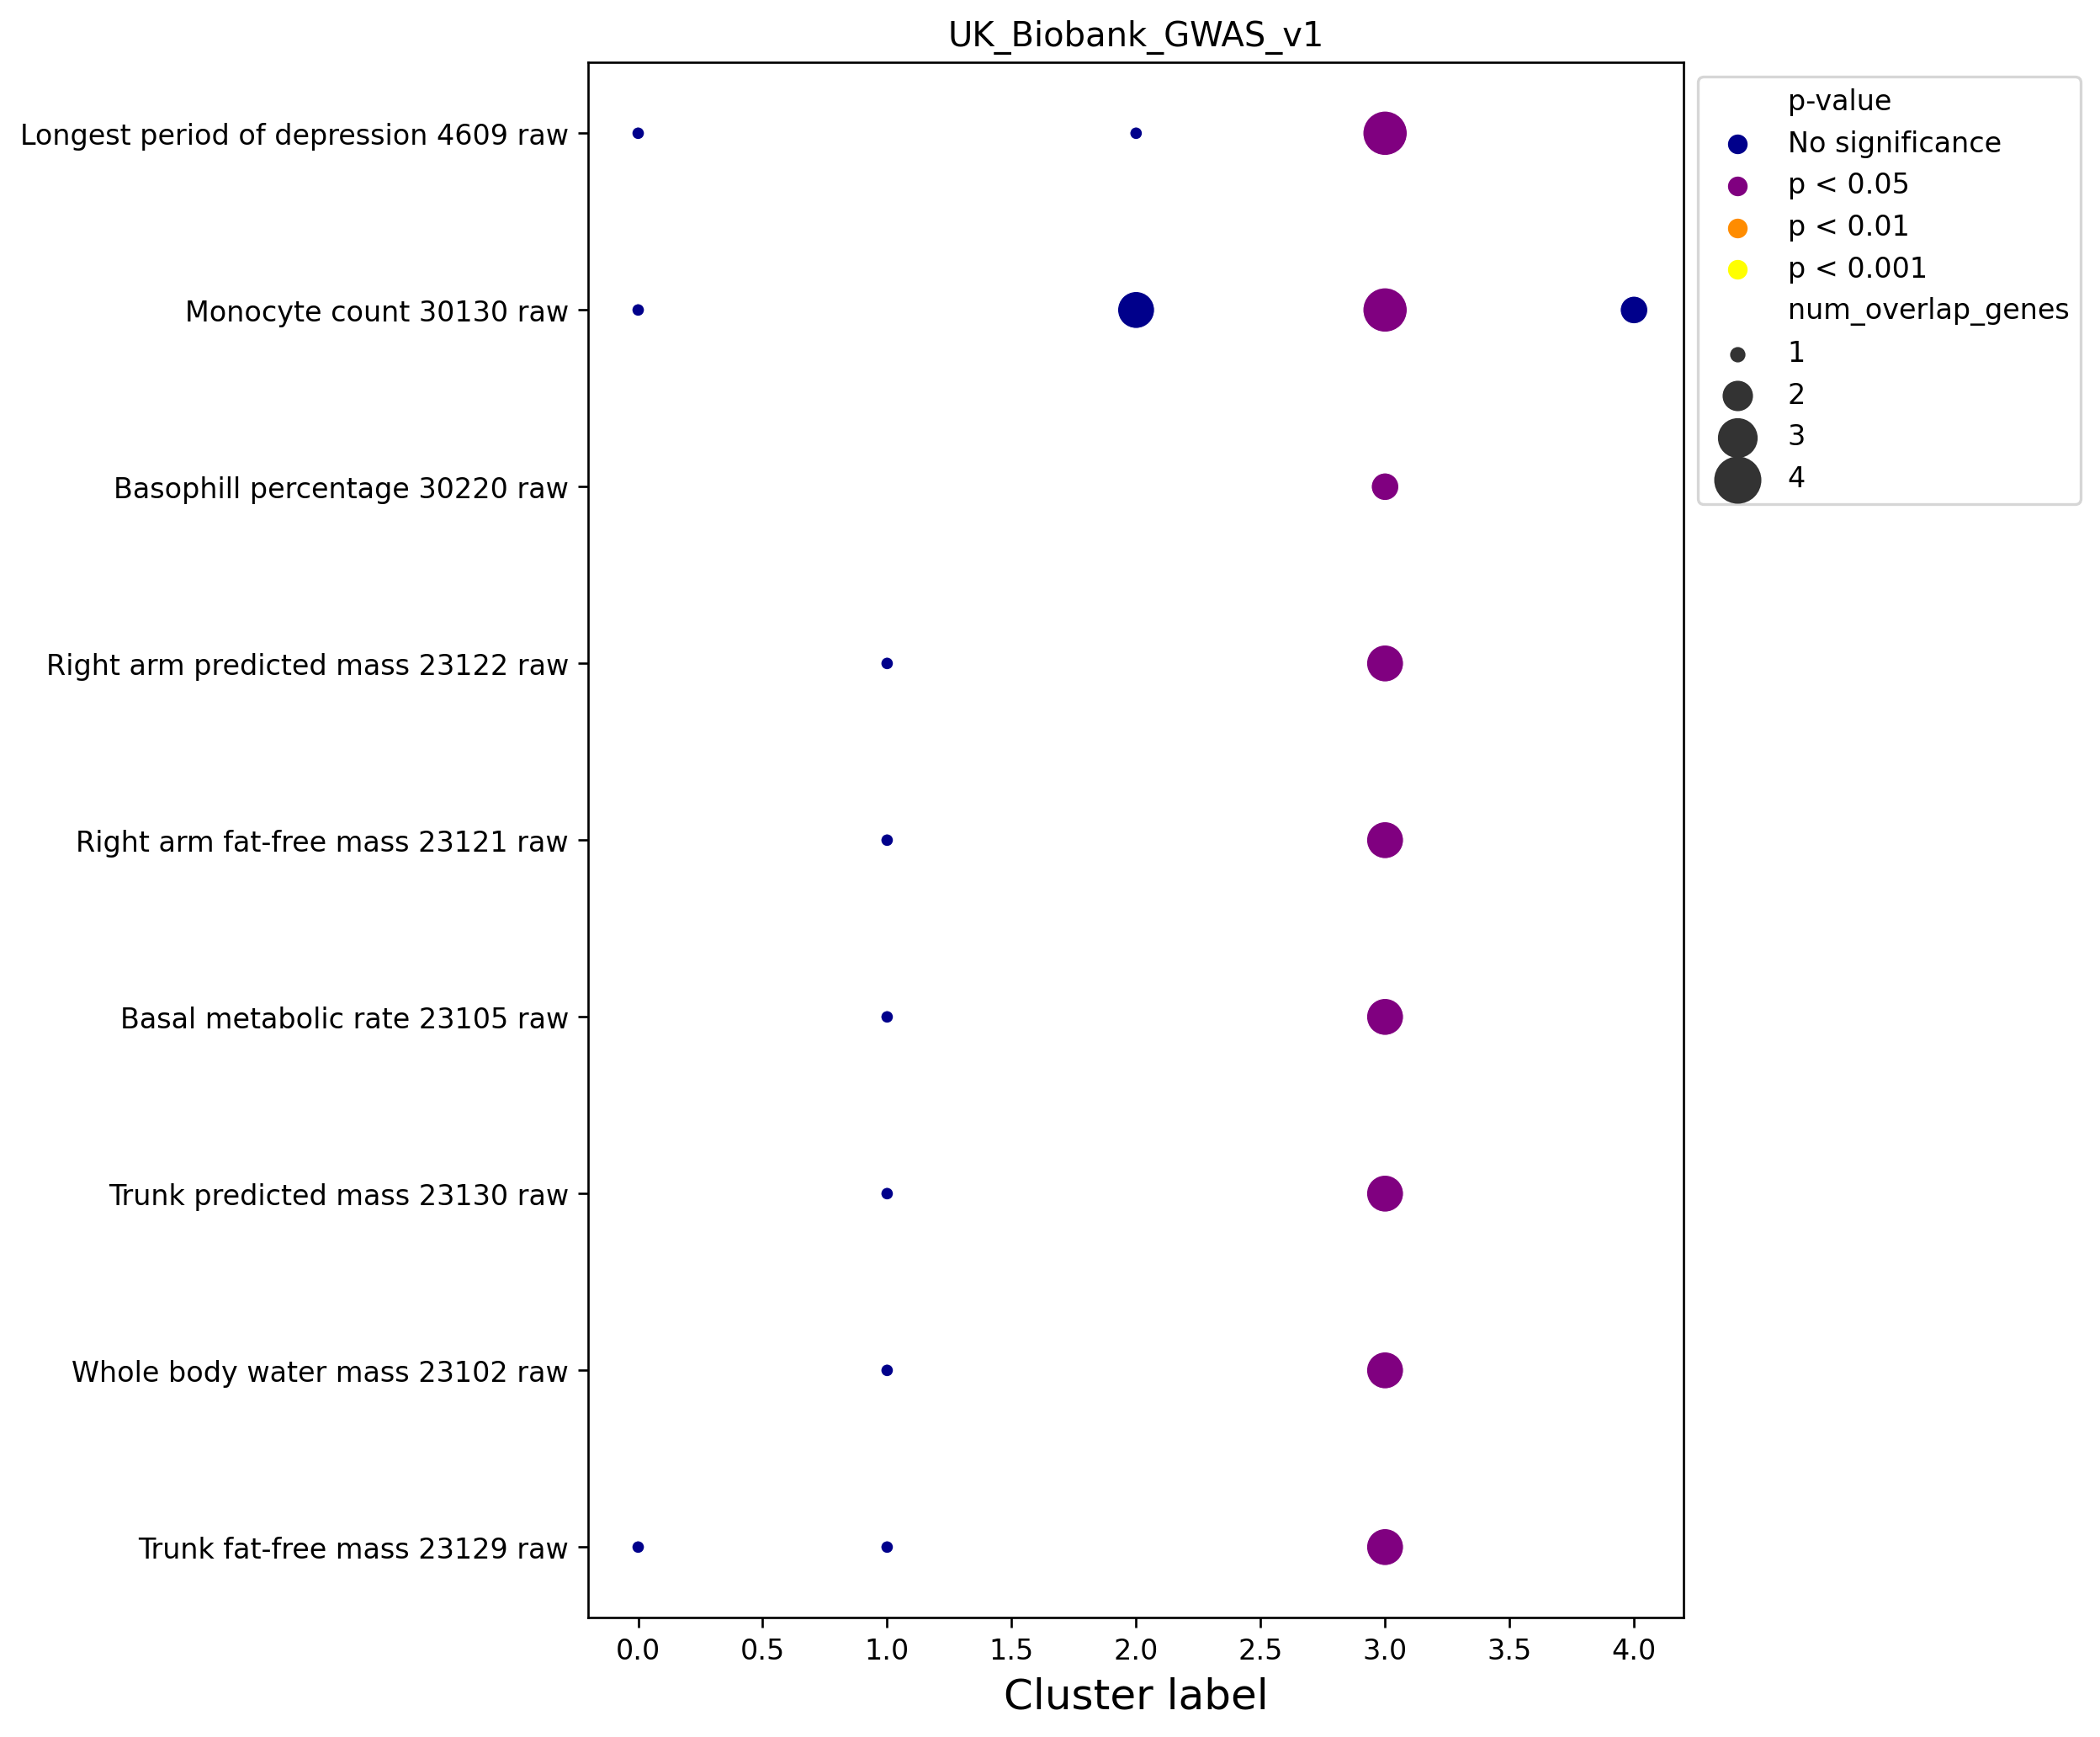

In [159]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))